# Introduction

Typically, hyper-parameter tuning is performed by doing a grid serach over the space of hyper-parameter values.

However, the space of hyper-parameter values can be large. 

Training multiple models over the range of hyper-parameter values can be time consuming even with parallelization. 

Randomized algorithms for hyper-parameter search exist and may provide satisfactory results at low computation cost, e.g. RandomizedSearchCV and HalvingRandomSerachCV in scikit-learn. Nevertheless, we can still miss out on a better configuration for the model.

Surrogate models allow optimal hyper-parameter search in a non-exhaustive way, guiding the search towards more promising candidates.

In this notebook, we train an XGBoost model to predict a model score associated to a hyper-parameter value. This way, we do not have to run a complete trining to calculate model score.

The general algorithm can be summarized as follows: n configurations are randomly drawn. The surrogate model performs a gain estimation for each one. the most promising configuration is then actually tested on the model to be trained. the gain obtained is reused to enrich the urrogate model.

As a case study, we apply the hyper-parameter model to the Boston dataset and compare results.

# Acknowledgment

This python notebook is an implementation of the Optimizer in Chapter 6 of "Practical Gradient Boosting" by Guillaume Saupin

# Configuration space and sampling

There are two prerequisites for finding an optimal hyper-parameter configuration:

    1) It is necessary to be able to describe this space of exploration.
    
    2) It is necessary to be able to sample configurations of this space.
    
The CongifSpace library in python makes this possible.

In [1]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, UniformIntegerHyperparameter

num_trees = UniformIntegerHyperparameter("num_trees", 10, 50, default_value = 10)

max_features = UniformIntegerHyperparameter("max_features", 1, 100, default_value = 1)

min_weight_frac_leaf =  UniformFloatHyperparameter("min_weight_frac_leaf", 0.0, 0.5, default_value = 0.0)

min_samples_to_split = UniformIntegerHyperparameter("min_samples_to_split", 2, 20, default_value = 2)

min_samples_in_leaf = UniformIntegerHyperparameter("min_samples_in_leaf", 1, 20, default_value = 1)

max_leaf_nodes = UniformIntegerHyperparameter("max_leaf_node", 10, 1000, default_value = 100)

It is also possible to add categorical parameters

In [2]:
do_bootstrapping = CategoricalHyperparameter("do_bootstrapping", ["true", "false"], default_value = "true")
criterion = CategoricalHyperparameter("criterion", ["mse", "mae"], default_value = "mse")

Finally, all these parameters can be grouped in a configuration space

In [3]:
cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, min_weight_frac_leaf, max_features, min_samples_to_split, min_samples_in_leaf,
                       max_leaf_nodes, criterion, do_bootstrapping])

[num_trees, Type: UniformInteger, Range: [10, 50], Default: 10,
 min_weight_frac_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0,
 max_features, Type: UniformInteger, Range: [1, 100], Default: 1,
 min_samples_to_split, Type: UniformInteger, Range: [2, 20], Default: 2,
 min_samples_in_leaf, Type: UniformInteger, Range: [1, 20], Default: 1,
 max_leaf_node, Type: UniformInteger, Range: [10, 1000], Default: 100,
 criterion, Type: Categorical, Choices: {mse, mae}, Default: mse,
 do_bootstrapping, Type: Categorical, Choices: {true, false}, Default: true]

The configutation space can be queried to provide a random configuration

In [4]:
cs.sample_configuration()

Configuration(values={
  'criterion': 'mae',
  'do_bootstrapping': 'true',
  'max_features': 32,
  'max_leaf_node': 130,
  'min_samples_in_leaf': 7,
  'min_samples_to_split': 10,
  'min_weight_frac_leaf': 0.373663668924116,
  'num_trees': 38,
})

# Optimizer

In [37]:
import pandas as pd
import numpy as np

class Optimizer:
    def __init__(self,
                algo_score,
                max_iter,
                max_intensification,
                model,
                cs):
        self.trajectory = []
        self.algo_score = algo_score
        self.max_iter = max_iter
        self.max_intensification = max_intensification
        self.internal_model = model()
        self.cfgs = []
        self.scores = {}
        self.best_cfg = None
        self.best_score = None
        self.cs = cs
        
    def cfg_to_dtf(self, cfgs):
        
        try:
            cfgs2 = [dict(cfg) for cfg in cfgs]
        except:
            print(cfg2)
            
        dtf = pd.DataFrame(cfgs2)
        
        return dtf
    
    def optimize(self):
        
        cfg = self.cs.sample_configuration()
        self.cfgs.append(cfg)
        self.trajectory.append(cfg)
        
        score = self.algo_score(cfg)
        self.scores[cfg] = score
        self.best_cfg = cfg
        self.best_score = score
        dtf = self.cfg_to_dtf(self.cfgs)
        
        for i in range(self.max_iter):
            
            if dtf.shape[0] > 1:
                
                scores = np.array([val for key, val in self.scores.items()])
                self.internal_model.fit(dtf, scores)
                
                candidates = [self.cs.sample_configuration() for i in range(self.max_intensification)]
                candidate_scores = self.internal_model.predict(self.cfg_to_dtf(candidates))
                
                best_candidates = np.argmax(candidate_scores)
                
                cfg = candidates[best_candidates]
                
            else:
                
                cfg = self.cs.sample_configuration()
                
            self.cfgs.append(cfg)
            score = self.algo_score(cfg)
            self.scores[cfg] = score
            
            if score > self.best_score:
                self.best_cfg = cfg
                self.best_score = score
                self.trajectory.append(cfg)
            
            dtf = self.cfg_to_dtf(self.cfgs)

# Case study: Boston Dataset

In [38]:
from sklearn.datasets import load_boston

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


# Case stude: California housing

In [39]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [40]:
def run(data, target, cfg):
    
    cfg_dict = {key:cfg[key] for key in cfg}
    
    rfr = RandomForestRegressor(**cfg_dict)
    
    def rmse(y, y_pred):
        return np.sqrt(np.mean(y_pred - y)**2)
    
    rmse_scorer = make_scorer(rmse, greater_is_better = False)
    score = cross_val_score(rfr, data, target, cv = 5, scoring=rmse_scorer, verbose = 0)
    score = np.mean(score)
    
    return score

In [41]:
num_trees = UniformIntegerHyperparameter("n_estimators", 10, 50, default_value = 10)

max_features = UniformIntegerHyperparameter("max_features", 1, 13, default_value = 1)

min_weight_frac_leaf =  UniformFloatHyperparameter("min_weight_fraction_leaf", 0.0, 0.5, default_value = 0.0)

min_samples_to_split = UniformIntegerHyperparameter("min_samples_split", 2, 20, default_value = 2)

min_samples_in_leaf = UniformIntegerHyperparameter("min_samples_leaf", 1, 20, default_value = 1)

max_leaf_nodes = UniformIntegerHyperparameter("max_leaf_nodes", 10, 1000, default_value = 100)

do_bootstrapping = CategoricalHyperparameter("bootstrap", [True, False], default_value = True)

criterion = CategoricalHyperparameter("criterion", ["friedman_mse", "absolute_error"], default_value = "friedman_mse")

In [42]:
cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, min_weight_frac_leaf, max_features, min_samples_to_split, min_samples_in_leaf,
                       max_leaf_nodes, criterion, do_bootstrapping])

[n_estimators, Type: UniformInteger, Range: [10, 50], Default: 10,
 min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0,
 max_features, Type: UniformInteger, Range: [1, 13], Default: 1,
 min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2,
 min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1,
 max_leaf_nodes, Type: UniformInteger, Range: [10, 1000], Default: 100,
 criterion, Type: Categorical, Choices: {friedman_mse, absolute_error}, Default: friedman_mse,
 bootstrap, Type: Categorical, Choices: {True, False}, Default: True]

In [43]:
housing = fetch_california_housing()
max_intensity = 25

In [44]:
%%time
optimizer = Optimizer(lambda cfg: run(housing.data, housing.target, cfg), 50, 250,
                     lambda: CatBoostRegressor(cat_features = ["criterion", "bootstrap"]), cs)
optimizer.optimize()

Learning rate set to 0.015337
0:	learn: 0.0010511	total: 573us	remaining: 572ms
1:	learn: 0.0010471	total: 834us	remaining: 416ms
2:	learn: 0.0010431	total: 1.06ms	remaining: 354ms
3:	learn: 0.0010391	total: 1.31ms	remaining: 327ms
4:	learn: 0.0010351	total: 1.52ms	remaining: 303ms
5:	learn: 0.0010311	total: 1.73ms	remaining: 287ms
6:	learn: 0.0010272	total: 1.97ms	remaining: 280ms
7:	learn: 0.0010233	total: 2.19ms	remaining: 272ms
8:	learn: 0.0010193	total: 2.43ms	remaining: 268ms
9:	learn: 0.0010154	total: 2.66ms	remaining: 263ms
10:	learn: 0.0010115	total: 2.88ms	remaining: 259ms
11:	learn: 0.0010076	total: 3.09ms	remaining: 254ms
12:	learn: 0.0010038	total: 3.3ms	remaining: 251ms
13:	learn: 0.0009999	total: 3.52ms	remaining: 248ms
14:	learn: 0.0009961	total: 3.72ms	remaining: 244ms
15:	learn: 0.0009923	total: 3.94ms	remaining: 242ms
16:	learn: 0.0009885	total: 4.17ms	remaining: 241ms
17:	learn: 0.0009847	total: 4.45ms	remaining: 243ms
18:	learn: 0.0009809	total: 4.61ms	remaining: 2

630:	learn: 0.0000934	total: 111ms	remaining: 64.8ms
631:	learn: 0.0000931	total: 111ms	remaining: 64.7ms
632:	learn: 0.0000927	total: 111ms	remaining: 64.5ms
633:	learn: 0.0000924	total: 111ms	remaining: 64.3ms
634:	learn: 0.0000920	total: 112ms	remaining: 64.1ms
635:	learn: 0.0000917	total: 112ms	remaining: 63.9ms
636:	learn: 0.0000913	total: 112ms	remaining: 63.7ms
637:	learn: 0.0000910	total: 112ms	remaining: 63.6ms
638:	learn: 0.0000906	total: 112ms	remaining: 63.4ms
639:	learn: 0.0000903	total: 112ms	remaining: 63.2ms
640:	learn: 0.0000899	total: 112ms	remaining: 63ms
641:	learn: 0.0000896	total: 113ms	remaining: 62.8ms
642:	learn: 0.0000892	total: 113ms	remaining: 62.6ms
643:	learn: 0.0000889	total: 113ms	remaining: 62.5ms
644:	learn: 0.0000886	total: 113ms	remaining: 62.3ms
645:	learn: 0.0000882	total: 113ms	remaining: 62.1ms
646:	learn: 0.0000879	total: 113ms	remaining: 61.9ms
647:	learn: 0.0000875	total: 114ms	remaining: 61.7ms
648:	learn: 0.0000872	total: 114ms	remaining: 61

Learning rate set to 0.016352
0:	learn: 0.0081694	total: 423us	remaining: 423ms
1:	learn: 0.0081298	total: 637us	remaining: 318ms
2:	learn: 0.0080965	total: 926us	remaining: 308ms
3:	learn: 0.0080634	total: 1.26ms	remaining: 314ms
4:	learn: 0.0080497	total: 1.51ms	remaining: 300ms
5:	learn: 0.0080107	total: 1.76ms	remaining: 291ms
6:	learn: 0.0079779	total: 2.05ms	remaining: 291ms
7:	learn: 0.0079453	total: 2.31ms	remaining: 287ms
8:	learn: 0.0079319	total: 2.55ms	remaining: 281ms
9:	learn: 0.0078995	total: 2.83ms	remaining: 281ms
10:	learn: 0.0078672	total: 3.09ms	remaining: 278ms
11:	learn: 0.0078290	total: 3.33ms	remaining: 274ms
12:	learn: 0.0077970	total: 3.64ms	remaining: 277ms
13:	learn: 0.0077651	total: 3.93ms	remaining: 277ms
14:	learn: 0.0077275	total: 4.16ms	remaining: 273ms
15:	learn: 0.0076959	total: 4.46ms	remaining: 274ms
16:	learn: 0.0076644	total: 4.75ms	remaining: 275ms
17:	learn: 0.0076331	total: 5.04ms	remaining: 275ms
18:	learn: 0.0076019	total: 5.32ms	remaining: 2

512:	learn: 0.0009752	total: 147ms	remaining: 139ms
513:	learn: 0.0009712	total: 148ms	remaining: 140ms
514:	learn: 0.0009673	total: 148ms	remaining: 139ms
515:	learn: 0.0009633	total: 148ms	remaining: 139ms
516:	learn: 0.0009594	total: 148ms	remaining: 139ms
517:	learn: 0.0009554	total: 149ms	remaining: 138ms
518:	learn: 0.0009515	total: 149ms	remaining: 138ms
519:	learn: 0.0009476	total: 149ms	remaining: 138ms
520:	learn: 0.0009438	total: 150ms	remaining: 138ms
521:	learn: 0.0009399	total: 150ms	remaining: 137ms
522:	learn: 0.0009361	total: 150ms	remaining: 137ms
523:	learn: 0.0009322	total: 150ms	remaining: 137ms
524:	learn: 0.0009284	total: 151ms	remaining: 136ms
525:	learn: 0.0009246	total: 151ms	remaining: 136ms
526:	learn: 0.0009209	total: 151ms	remaining: 136ms
527:	learn: 0.0009171	total: 151ms	remaining: 135ms
528:	learn: 0.0009133	total: 152ms	remaining: 135ms
529:	learn: 0.0009096	total: 152ms	remaining: 135ms
530:	learn: 0.0009059	total: 152ms	remaining: 134ms
531:	learn: 

Learning rate set to 0.017112
0:	learn: 0.0238968	total: 389us	remaining: 389ms
1:	learn: 0.0237803	total: 660us	remaining: 330ms
2:	learn: 0.0236699	total: 1.07ms	remaining: 355ms
3:	learn: 0.0235687	total: 1.43ms	remaining: 357ms
4:	learn: 0.0234678	total: 1.8ms	remaining: 358ms
5:	learn: 0.0233590	total: 2.17ms	remaining: 359ms
6:	learn: 0.0232591	total: 2.54ms	remaining: 361ms
7:	learn: 0.0231462	total: 2.74ms	remaining: 340ms
8:	learn: 0.0230446	total: 2.98ms	remaining: 328ms
9:	learn: 0.0229460	total: 3.27ms	remaining: 323ms
10:	learn: 0.0228478	total: 3.54ms	remaining: 318ms
11:	learn: 0.0227501	total: 3.83ms	remaining: 315ms
12:	learn: 0.0226448	total: 4.09ms	remaining: 310ms
13:	learn: 0.0225479	total: 4.38ms	remaining: 309ms
14:	learn: 0.0224515	total: 4.62ms	remaining: 304ms
15:	learn: 0.0223554	total: 4.86ms	remaining: 299ms
16:	learn: 0.0222521	total: 5.1ms	remaining: 295ms
17:	learn: 0.0221569	total: 5.43ms	remaining: 296ms
18:	learn: 0.0220621	total: 5.85ms	remaining: 30

420:	learn: 0.0038814	total: 149ms	remaining: 204ms
421:	learn: 0.0038648	total: 149ms	remaining: 204ms
422:	learn: 0.0038483	total: 149ms	remaining: 204ms
423:	learn: 0.0038318	total: 150ms	remaining: 203ms
424:	learn: 0.0038154	total: 150ms	remaining: 203ms
425:	learn: 0.0037991	total: 150ms	remaining: 203ms
426:	learn: 0.0037829	total: 151ms	remaining: 202ms
427:	learn: 0.0037667	total: 151ms	remaining: 202ms
428:	learn: 0.0037506	total: 151ms	remaining: 202ms
429:	learn: 0.0037345	total: 152ms	remaining: 201ms
430:	learn: 0.0037185	total: 152ms	remaining: 201ms
431:	learn: 0.0037026	total: 152ms	remaining: 201ms
432:	learn: 0.0036868	total: 153ms	remaining: 200ms
433:	learn: 0.0036710	total: 153ms	remaining: 200ms
434:	learn: 0.0036553	total: 154ms	remaining: 199ms
435:	learn: 0.0036397	total: 154ms	remaining: 199ms
436:	learn: 0.0036241	total: 154ms	remaining: 199ms
437:	learn: 0.0036086	total: 154ms	remaining: 198ms
438:	learn: 0.0035932	total: 155ms	remaining: 198ms
439:	learn: 

770:	learn: 0.0008656	total: 309ms	remaining: 91.9ms
771:	learn: 0.0008619	total: 310ms	remaining: 91.6ms
772:	learn: 0.0008582	total: 311ms	remaining: 91.2ms
773:	learn: 0.0008546	total: 311ms	remaining: 90.8ms
774:	learn: 0.0008509	total: 312ms	remaining: 90.5ms
775:	learn: 0.0008473	total: 313ms	remaining: 90.2ms
776:	learn: 0.0008436	total: 313ms	remaining: 89.9ms
777:	learn: 0.0008400	total: 314ms	remaining: 89.5ms
778:	learn: 0.0008364	total: 314ms	remaining: 89.1ms
779:	learn: 0.0008329	total: 315ms	remaining: 88.7ms
780:	learn: 0.0008293	total: 315ms	remaining: 88.4ms
781:	learn: 0.0008257	total: 316ms	remaining: 88ms
782:	learn: 0.0008222	total: 316ms	remaining: 87.6ms
783:	learn: 0.0008187	total: 316ms	remaining: 87.2ms
784:	learn: 0.0008152	total: 317ms	remaining: 86.8ms
785:	learn: 0.0008117	total: 317ms	remaining: 86.3ms
786:	learn: 0.0008082	total: 317ms	remaining: 85.9ms
787:	learn: 0.0008048	total: 318ms	remaining: 85.5ms
788:	learn: 0.0008013	total: 318ms	remaining: 85

Learning rate set to 0.017726
0:	learn: 0.0224716	total: 373us	remaining: 373ms
1:	learn: 0.0223582	total: 746us	remaining: 372ms
2:	learn: 0.0222455	total: 1.14ms	remaining: 380ms
3:	learn: 0.0221335	total: 1.54ms	remaining: 383ms
4:	learn: 0.0220026	total: 1.89ms	remaining: 376ms
5:	learn: 0.0219051	total: 2.27ms	remaining: 376ms
6:	learn: 0.0218340	total: 2.56ms	remaining: 363ms
7:	learn: 0.0217372	total: 2.94ms	remaining: 364ms
8:	learn: 0.0216409	total: 3.29ms	remaining: 362ms
9:	learn: 0.0215398	total: 3.64ms	remaining: 361ms
10:	learn: 0.0214392	total: 3.89ms	remaining: 350ms
11:	learn: 0.0213317	total: 4.24ms	remaining: 349ms
12:	learn: 0.0212371	total: 4.7ms	remaining: 357ms
13:	learn: 0.0211430	total: 5.05ms	remaining: 356ms
14:	learn: 0.0210493	total: 5.45ms	remaining: 358ms
15:	learn: 0.0209463	total: 5.77ms	remaining: 355ms
16:	learn: 0.0208486	total: 6.15ms	remaining: 356ms
17:	learn: 0.0207562	total: 6.54ms	remaining: 357ms
18:	learn: 0.0206239	total: 6.77ms	remaining: 3

463:	learn: 0.0027279	total: 150ms	remaining: 173ms
464:	learn: 0.0027158	total: 151ms	remaining: 174ms
465:	learn: 0.0027038	total: 151ms	remaining: 173ms
466:	learn: 0.0026918	total: 152ms	remaining: 173ms
467:	learn: 0.0026799	total: 152ms	remaining: 173ms
468:	learn: 0.0026680	total: 152ms	remaining: 172ms
469:	learn: 0.0026562	total: 153ms	remaining: 172ms
470:	learn: 0.0026444	total: 153ms	remaining: 172ms
471:	learn: 0.0026327	total: 153ms	remaining: 172ms
472:	learn: 0.0026210	total: 154ms	remaining: 171ms
473:	learn: 0.0026094	total: 154ms	remaining: 171ms
474:	learn: 0.0025978	total: 154ms	remaining: 171ms
475:	learn: 0.0025863	total: 155ms	remaining: 170ms
476:	learn: 0.0025749	total: 155ms	remaining: 170ms
477:	learn: 0.0025635	total: 155ms	remaining: 170ms
478:	learn: 0.0025521	total: 156ms	remaining: 169ms
479:	learn: 0.0025408	total: 156ms	remaining: 169ms
480:	learn: 0.0025295	total: 156ms	remaining: 169ms
481:	learn: 0.0025183	total: 157ms	remaining: 168ms
482:	learn: 

903:	learn: 0.0003865	total: 308ms	remaining: 32.7ms
904:	learn: 0.0003848	total: 308ms	remaining: 32.4ms
905:	learn: 0.0003831	total: 309ms	remaining: 32ms
906:	learn: 0.0003814	total: 309ms	remaining: 31.7ms
907:	learn: 0.0003797	total: 310ms	remaining: 31.4ms
908:	learn: 0.0003780	total: 310ms	remaining: 31ms
909:	learn: 0.0003763	total: 310ms	remaining: 30.7ms
910:	learn: 0.0003747	total: 311ms	remaining: 30.3ms
911:	learn: 0.0003730	total: 311ms	remaining: 30ms
912:	learn: 0.0003713	total: 311ms	remaining: 29.7ms
913:	learn: 0.0003697	total: 312ms	remaining: 29.3ms
914:	learn: 0.0003681	total: 312ms	remaining: 29ms
915:	learn: 0.0003664	total: 312ms	remaining: 28.6ms
916:	learn: 0.0003648	total: 313ms	remaining: 28.3ms
917:	learn: 0.0003632	total: 313ms	remaining: 27.9ms
918:	learn: 0.0003616	total: 313ms	remaining: 27.6ms
919:	learn: 0.0003600	total: 313ms	remaining: 27.3ms
920:	learn: 0.0003584	total: 314ms	remaining: 26.9ms
921:	learn: 0.0003568	total: 314ms	remaining: 26.6ms
9

403:	learn: 0.0038702	total: 155ms	remaining: 228ms
404:	learn: 0.0038525	total: 155ms	remaining: 228ms
405:	learn: 0.0038350	total: 156ms	remaining: 228ms
406:	learn: 0.0038175	total: 156ms	remaining: 227ms
407:	learn: 0.0038001	total: 156ms	remaining: 227ms
408:	learn: 0.0037827	total: 157ms	remaining: 226ms
409:	learn: 0.0037655	total: 157ms	remaining: 226ms
410:	learn: 0.0037483	total: 157ms	remaining: 225ms
411:	learn: 0.0037312	total: 158ms	remaining: 225ms
412:	learn: 0.0037142	total: 158ms	remaining: 225ms
413:	learn: 0.0036972	total: 158ms	remaining: 224ms
414:	learn: 0.0036804	total: 159ms	remaining: 224ms
415:	learn: 0.0036636	total: 159ms	remaining: 223ms
416:	learn: 0.0036469	total: 159ms	remaining: 223ms
417:	learn: 0.0036303	total: 160ms	remaining: 222ms
418:	learn: 0.0036137	total: 160ms	remaining: 222ms
419:	learn: 0.0035972	total: 160ms	remaining: 221ms
420:	learn: 0.0035808	total: 161ms	remaining: 221ms
421:	learn: 0.0035645	total: 161ms	remaining: 221ms
422:	learn: 

899:	learn: 0.0004009	total: 314ms	remaining: 34.9ms
900:	learn: 0.0003990	total: 315ms	remaining: 34.6ms
901:	learn: 0.0003972	total: 315ms	remaining: 34.2ms
902:	learn: 0.0003954	total: 316ms	remaining: 33.9ms
903:	learn: 0.0003936	total: 316ms	remaining: 33.5ms
904:	learn: 0.0003918	total: 316ms	remaining: 33.2ms
905:	learn: 0.0003900	total: 316ms	remaining: 32.8ms
906:	learn: 0.0003882	total: 317ms	remaining: 32.5ms
907:	learn: 0.0003865	total: 317ms	remaining: 32.1ms
908:	learn: 0.0003847	total: 317ms	remaining: 31.8ms
909:	learn: 0.0003830	total: 318ms	remaining: 31.4ms
910:	learn: 0.0003812	total: 318ms	remaining: 31.1ms
911:	learn: 0.0003795	total: 318ms	remaining: 30.7ms
912:	learn: 0.0003777	total: 319ms	remaining: 30.4ms
913:	learn: 0.0003760	total: 319ms	remaining: 30ms
914:	learn: 0.0003743	total: 319ms	remaining: 29.7ms
915:	learn: 0.0003726	total: 320ms	remaining: 29.3ms
916:	learn: 0.0003709	total: 320ms	remaining: 29ms
917:	learn: 0.0003692	total: 320ms	remaining: 28.6

396:	learn: 0.0040317	total: 151ms	remaining: 229ms
397:	learn: 0.0040129	total: 151ms	remaining: 229ms
398:	learn: 0.0039941	total: 152ms	remaining: 229ms
399:	learn: 0.0039755	total: 152ms	remaining: 228ms
400:	learn: 0.0039569	total: 152ms	remaining: 228ms
401:	learn: 0.0039384	total: 153ms	remaining: 227ms
402:	learn: 0.0039200	total: 153ms	remaining: 227ms
403:	learn: 0.0039017	total: 154ms	remaining: 227ms
404:	learn: 0.0038834	total: 154ms	remaining: 226ms
405:	learn: 0.0038653	total: 155ms	remaining: 226ms
406:	learn: 0.0038472	total: 155ms	remaining: 226ms
407:	learn: 0.0038292	total: 155ms	remaining: 225ms
408:	learn: 0.0038113	total: 156ms	remaining: 225ms
409:	learn: 0.0037935	total: 156ms	remaining: 224ms
410:	learn: 0.0037758	total: 156ms	remaining: 224ms
411:	learn: 0.0037582	total: 157ms	remaining: 224ms
412:	learn: 0.0037406	total: 157ms	remaining: 223ms
413:	learn: 0.0037231	total: 157ms	remaining: 223ms
414:	learn: 0.0037057	total: 158ms	remaining: 223ms
415:	learn: 

830:	learn: 0.0005279	total: 316ms	remaining: 64.3ms
831:	learn: 0.0005254	total: 317ms	remaining: 63.9ms
832:	learn: 0.0005230	total: 317ms	remaining: 63.5ms
833:	learn: 0.0005205	total: 317ms	remaining: 63.1ms
834:	learn: 0.0005181	total: 318ms	remaining: 62.8ms
835:	learn: 0.0005157	total: 318ms	remaining: 62.4ms
836:	learn: 0.0005133	total: 318ms	remaining: 62ms
837:	learn: 0.0005109	total: 319ms	remaining: 61.6ms
838:	learn: 0.0005085	total: 319ms	remaining: 61.2ms
839:	learn: 0.0005061	total: 320ms	remaining: 60.9ms
840:	learn: 0.0005037	total: 320ms	remaining: 60.5ms
841:	learn: 0.0005014	total: 321ms	remaining: 60.2ms
842:	learn: 0.0004990	total: 321ms	remaining: 59.8ms
843:	learn: 0.0004967	total: 321ms	remaining: 59.4ms
844:	learn: 0.0004944	total: 322ms	remaining: 59ms
845:	learn: 0.0004921	total: 322ms	remaining: 58.6ms
846:	learn: 0.0004898	total: 323ms	remaining: 58.3ms
847:	learn: 0.0004875	total: 323ms	remaining: 57.9ms
848:	learn: 0.0004852	total: 324ms	remaining: 57.6

Learning rate set to 0.019093
0:	learn: 0.0262984	total: 536us	remaining: 536ms
1:	learn: 0.0261729	total: 995us	remaining: 497ms
2:	learn: 0.0260631	total: 1.51ms	remaining: 503ms
3:	learn: 0.0258955	total: 2.03ms	remaining: 507ms
4:	learn: 0.0257654	total: 2.57ms	remaining: 511ms
5:	learn: 0.0256329	total: 3.05ms	remaining: 505ms
6:	learn: 0.0255013	total: 3.49ms	remaining: 495ms
7:	learn: 0.0253761	total: 3.92ms	remaining: 486ms
8:	learn: 0.0252549	total: 4.43ms	remaining: 488ms
9:	learn: 0.0251067	total: 4.79ms	remaining: 474ms
10:	learn: 0.0249520	total: 5.14ms	remaining: 463ms
11:	learn: 0.0248269	total: 5.61ms	remaining: 462ms
12:	learn: 0.0247201	total: 5.97ms	remaining: 453ms
13:	learn: 0.0246021	total: 6.55ms	remaining: 461ms
14:	learn: 0.0245031	total: 6.93ms	remaining: 455ms
15:	learn: 0.0243569	total: 7.29ms	remaining: 448ms
16:	learn: 0.0241990	total: 7.75ms	remaining: 448ms
17:	learn: 0.0241020	total: 8.27ms	remaining: 451ms
18:	learn: 0.0239784	total: 8.72ms	remaining: 

360:	learn: 0.0041840	total: 160ms	remaining: 283ms
361:	learn: 0.0041640	total: 161ms	remaining: 283ms
362:	learn: 0.0041441	total: 161ms	remaining: 283ms
363:	learn: 0.0041242	total: 161ms	remaining: 282ms
364:	learn: 0.0041045	total: 162ms	remaining: 282ms
365:	learn: 0.0040849	total: 163ms	remaining: 282ms
366:	learn: 0.0040654	total: 163ms	remaining: 281ms
367:	learn: 0.0040460	total: 164ms	remaining: 281ms
368:	learn: 0.0040267	total: 164ms	remaining: 280ms
369:	learn: 0.0040075	total: 164ms	remaining: 280ms
370:	learn: 0.0039883	total: 165ms	remaining: 280ms
371:	learn: 0.0039693	total: 165ms	remaining: 279ms
372:	learn: 0.0039503	total: 166ms	remaining: 279ms
373:	learn: 0.0039315	total: 166ms	remaining: 278ms
374:	learn: 0.0039127	total: 167ms	remaining: 278ms
375:	learn: 0.0038940	total: 167ms	remaining: 278ms
376:	learn: 0.0038754	total: 168ms	remaining: 277ms
377:	learn: 0.0038569	total: 168ms	remaining: 277ms
378:	learn: 0.0038385	total: 169ms	remaining: 276ms
379:	learn: 

703:	learn: 0.0008105	total: 325ms	remaining: 137ms
704:	learn: 0.0008066	total: 326ms	remaining: 136ms
705:	learn: 0.0008028	total: 326ms	remaining: 136ms
706:	learn: 0.0007989	total: 327ms	remaining: 135ms
707:	learn: 0.0007951	total: 328ms	remaining: 135ms
708:	learn: 0.0007913	total: 328ms	remaining: 135ms
709:	learn: 0.0007876	total: 329ms	remaining: 134ms
710:	learn: 0.0007838	total: 329ms	remaining: 134ms
711:	learn: 0.0007801	total: 330ms	remaining: 133ms
712:	learn: 0.0007763	total: 330ms	remaining: 133ms
713:	learn: 0.0007726	total: 331ms	remaining: 132ms
714:	learn: 0.0007689	total: 331ms	remaining: 132ms
715:	learn: 0.0007653	total: 332ms	remaining: 132ms
716:	learn: 0.0007616	total: 332ms	remaining: 131ms
717:	learn: 0.0007580	total: 333ms	remaining: 131ms
718:	learn: 0.0007544	total: 333ms	remaining: 130ms
719:	learn: 0.0007508	total: 334ms	remaining: 130ms
720:	learn: 0.0007472	total: 334ms	remaining: 129ms
721:	learn: 0.0007436	total: 335ms	remaining: 129ms
722:	learn: 

Learning rate set to 0.019451
0:	learn: 0.0271718	total: 448us	remaining: 448ms
1:	learn: 0.0270804	total: 814us	remaining: 407ms
2:	learn: 0.0269487	total: 1.26ms	remaining: 419ms
3:	learn: 0.0267965	total: 1.67ms	remaining: 417ms
4:	learn: 0.0266273	total: 2.1ms	remaining: 418ms
5:	learn: 0.0264950	total: 2.56ms	remaining: 424ms
6:	learn: 0.0263629	total: 2.96ms	remaining: 421ms
7:	learn: 0.0262347	total: 3.4ms	remaining: 422ms
8:	learn: 0.0261427	total: 3.83ms	remaining: 422ms
9:	learn: 0.0260294	total: 4.17ms	remaining: 413ms
10:	learn: 0.0258796	total: 4.57ms	remaining: 411ms
11:	learn: 0.0257921	total: 4.96ms	remaining: 409ms
12:	learn: 0.0256772	total: 5.31ms	remaining: 403ms
13:	learn: 0.0255523	total: 5.93ms	remaining: 418ms
14:	learn: 0.0253833	total: 6.34ms	remaining: 417ms
15:	learn: 0.0252392	total: 7.02ms	remaining: 432ms
16:	learn: 0.0251130	total: 7.57ms	remaining: 438ms
17:	learn: 0.0250037	total: 7.98ms	remaining: 435ms
18:	learn: 0.0248821	total: 8.47ms	remaining: 43

335:	learn: 0.0044738	total: 152ms	remaining: 301ms
336:	learn: 0.0044520	total: 153ms	remaining: 301ms
337:	learn: 0.0044304	total: 153ms	remaining: 300ms
338:	learn: 0.0044088	total: 154ms	remaining: 300ms
339:	learn: 0.0043874	total: 154ms	remaining: 299ms
340:	learn: 0.0043661	total: 155ms	remaining: 299ms
341:	learn: 0.0043448	total: 155ms	remaining: 298ms
342:	learn: 0.0043237	total: 156ms	remaining: 298ms
343:	learn: 0.0043027	total: 156ms	remaining: 298ms
344:	learn: 0.0042818	total: 157ms	remaining: 297ms
345:	learn: 0.0042610	total: 157ms	remaining: 297ms
346:	learn: 0.0042403	total: 157ms	remaining: 296ms
347:	learn: 0.0042197	total: 158ms	remaining: 296ms
348:	learn: 0.0041992	total: 158ms	remaining: 295ms
349:	learn: 0.0041788	total: 159ms	remaining: 295ms
350:	learn: 0.0041585	total: 159ms	remaining: 294ms
351:	learn: 0.0041383	total: 160ms	remaining: 294ms
352:	learn: 0.0041181	total: 160ms	remaining: 293ms
353:	learn: 0.0040892	total: 160ms	remaining: 292ms
354:	learn: 

697:	learn: 0.0007645	total: 314ms	remaining: 136ms
698:	learn: 0.0007607	total: 315ms	remaining: 135ms
699:	learn: 0.0007570	total: 315ms	remaining: 135ms
700:	learn: 0.0007534	total: 315ms	remaining: 135ms
701:	learn: 0.0007497	total: 316ms	remaining: 134ms
702:	learn: 0.0007460	total: 316ms	remaining: 134ms
703:	learn: 0.0007424	total: 317ms	remaining: 133ms
704:	learn: 0.0007388	total: 317ms	remaining: 133ms
705:	learn: 0.0007352	total: 318ms	remaining: 132ms
706:	learn: 0.0007316	total: 318ms	remaining: 132ms
707:	learn: 0.0007281	total: 319ms	remaining: 131ms
708:	learn: 0.0007245	total: 319ms	remaining: 131ms
709:	learn: 0.0007210	total: 319ms	remaining: 130ms
710:	learn: 0.0007175	total: 320ms	remaining: 130ms
711:	learn: 0.0007140	total: 320ms	remaining: 130ms
712:	learn: 0.0007105	total: 321ms	remaining: 129ms
713:	learn: 0.0007071	total: 321ms	remaining: 129ms
714:	learn: 0.0007037	total: 322ms	remaining: 128ms
715:	learn: 0.0007002	total: 322ms	remaining: 128ms
716:	learn: 

Learning rate set to 0.019778
0:	learn: 0.0272979	total: 638us	remaining: 638ms
1:	learn: 0.0271603	total: 1.06ms	remaining: 531ms
2:	learn: 0.0269801	total: 1.52ms	remaining: 506ms
3:	learn: 0.0268183	total: 1.88ms	remaining: 468ms
4:	learn: 0.0266890	total: 2.19ms	remaining: 435ms
5:	learn: 0.0265360	total: 2.56ms	remaining: 425ms
6:	learn: 0.0263892	total: 3.06ms	remaining: 435ms
7:	learn: 0.0262139	total: 3.49ms	remaining: 433ms
8:	learn: 0.0260441	total: 3.92ms	remaining: 431ms
9:	learn: 0.0258819	total: 4.31ms	remaining: 426ms
10:	learn: 0.0257336	total: 4.71ms	remaining: 424ms
11:	learn: 0.0255958	total: 5.02ms	remaining: 414ms
12:	learn: 0.0254256	total: 5.44ms	remaining: 413ms
13:	learn: 0.0252789	total: 5.82ms	remaining: 410ms
14:	learn: 0.0251427	total: 6.27ms	remaining: 412ms
15:	learn: 0.0250005	total: 6.77ms	remaining: 416ms
16:	learn: 0.0248333	total: 7.2ms	remaining: 416ms
17:	learn: 0.0247232	total: 7.64ms	remaining: 417ms
18:	learn: 0.0245585	total: 7.99ms	remaining: 

408:	learn: 0.0027622	total: 161ms	remaining: 232ms
409:	learn: 0.0027485	total: 161ms	remaining: 232ms
410:	learn: 0.0027349	total: 162ms	remaining: 232ms
411:	learn: 0.0027214	total: 162ms	remaining: 231ms
412:	learn: 0.0027080	total: 163ms	remaining: 231ms
413:	learn: 0.0026946	total: 163ms	remaining: 231ms
414:	learn: 0.0026813	total: 163ms	remaining: 230ms
415:	learn: 0.0026680	total: 164ms	remaining: 230ms
416:	learn: 0.0026548	total: 164ms	remaining: 230ms
417:	learn: 0.0026417	total: 165ms	remaining: 229ms
418:	learn: 0.0026286	total: 165ms	remaining: 229ms
419:	learn: 0.0026156	total: 166ms	remaining: 229ms
420:	learn: 0.0026027	total: 166ms	remaining: 228ms
421:	learn: 0.0025898	total: 166ms	remaining: 228ms
422:	learn: 0.0025770	total: 167ms	remaining: 228ms
423:	learn: 0.0025643	total: 167ms	remaining: 227ms
424:	learn: 0.0025516	total: 168ms	remaining: 227ms
425:	learn: 0.0025390	total: 168ms	remaining: 227ms
426:	learn: 0.0025264	total: 169ms	remaining: 226ms
427:	learn: 

795:	learn: 0.0004057	total: 324ms	remaining: 83ms
796:	learn: 0.0004037	total: 324ms	remaining: 82.6ms
797:	learn: 0.0004017	total: 325ms	remaining: 82.2ms
798:	learn: 0.0003997	total: 325ms	remaining: 81.8ms
799:	learn: 0.0003977	total: 326ms	remaining: 81.4ms
800:	learn: 0.0003957	total: 326ms	remaining: 81ms
801:	learn: 0.0003938	total: 326ms	remaining: 80.6ms
802:	learn: 0.0003918	total: 327ms	remaining: 80.2ms
803:	learn: 0.0003899	total: 327ms	remaining: 79.8ms
804:	learn: 0.0003880	total: 328ms	remaining: 79.4ms
805:	learn: 0.0003860	total: 328ms	remaining: 79ms
806:	learn: 0.0003841	total: 329ms	remaining: 78.6ms
807:	learn: 0.0003822	total: 329ms	remaining: 78.2ms
808:	learn: 0.0003803	total: 330ms	remaining: 77.8ms
809:	learn: 0.0003785	total: 330ms	remaining: 77.4ms
810:	learn: 0.0003766	total: 330ms	remaining: 77ms
811:	learn: 0.0003747	total: 331ms	remaining: 76.6ms
812:	learn: 0.0003729	total: 331ms	remaining: 76.2ms
813:	learn: 0.0003710	total: 332ms	remaining: 75.8ms
8

Learning rate set to 0.020078
0:	learn: 0.0266632	total: 574us	remaining: 574ms
1:	learn: 0.0265048	total: 1.1ms	remaining: 551ms
2:	learn: 0.0263476	total: 1.47ms	remaining: 488ms
3:	learn: 0.0261832	total: 1.79ms	remaining: 446ms
4:	learn: 0.0260018	total: 2.13ms	remaining: 425ms
5:	learn: 0.0258625	total: 2.63ms	remaining: 436ms
6:	learn: 0.0257534	total: 3.11ms	remaining: 442ms
7:	learn: 0.0255712	total: 3.55ms	remaining: 440ms
8:	learn: 0.0254556	total: 4.05ms	remaining: 446ms
9:	learn: 0.0253398	total: 4.41ms	remaining: 437ms
10:	learn: 0.0251921	total: 4.95ms	remaining: 445ms
11:	learn: 0.0250473	total: 5.42ms	remaining: 447ms
12:	learn: 0.0248846	total: 5.86ms	remaining: 445ms
13:	learn: 0.0247513	total: 6.35ms	remaining: 447ms
14:	learn: 0.0246082	total: 6.81ms	remaining: 447ms
15:	learn: 0.0244816	total: 7.24ms	remaining: 445ms
16:	learn: 0.0243572	total: 7.77ms	remaining: 449ms
17:	learn: 0.0241851	total: 8.15ms	remaining: 444ms
18:	learn: 0.0240116	total: 8.65ms	remaining: 

351:	learn: 0.0035933	total: 159ms	remaining: 292ms
352:	learn: 0.0035753	total: 159ms	remaining: 292ms
353:	learn: 0.0035573	total: 160ms	remaining: 291ms
354:	learn: 0.0035395	total: 160ms	remaining: 291ms
355:	learn: 0.0035217	total: 161ms	remaining: 290ms
356:	learn: 0.0035042	total: 161ms	remaining: 290ms
357:	learn: 0.0034866	total: 161ms	remaining: 290ms
358:	learn: 0.0034691	total: 162ms	remaining: 289ms
359:	learn: 0.0034517	total: 162ms	remaining: 289ms
360:	learn: 0.0034344	total: 163ms	remaining: 288ms
361:	learn: 0.0034171	total: 164ms	remaining: 288ms
362:	learn: 0.0034000	total: 164ms	remaining: 288ms
363:	learn: 0.0033829	total: 164ms	remaining: 287ms
364:	learn: 0.0033659	total: 165ms	remaining: 287ms
365:	learn: 0.0033490	total: 165ms	remaining: 287ms
366:	learn: 0.0033322	total: 166ms	remaining: 286ms
367:	learn: 0.0033155	total: 166ms	remaining: 286ms
368:	learn: 0.0032989	total: 167ms	remaining: 286ms
369:	learn: 0.0032823	total: 167ms	remaining: 285ms
370:	learn: 

704:	learn: 0.0006082	total: 324ms	remaining: 136ms
705:	learn: 0.0006052	total: 325ms	remaining: 135ms
706:	learn: 0.0006021	total: 325ms	remaining: 135ms
707:	learn: 0.0005991	total: 325ms	remaining: 134ms
708:	learn: 0.0005961	total: 326ms	remaining: 134ms
709:	learn: 0.0005931	total: 326ms	remaining: 133ms
710:	learn: 0.0005901	total: 327ms	remaining: 133ms
711:	learn: 0.0005872	total: 327ms	remaining: 132ms
712:	learn: 0.0005842	total: 328ms	remaining: 132ms
713:	learn: 0.0005813	total: 328ms	remaining: 131ms
714:	learn: 0.0005784	total: 329ms	remaining: 131ms
715:	learn: 0.0005755	total: 329ms	remaining: 131ms
716:	learn: 0.0005726	total: 330ms	remaining: 130ms
717:	learn: 0.0005697	total: 330ms	remaining: 130ms
718:	learn: 0.0005668	total: 331ms	remaining: 129ms
719:	learn: 0.0005640	total: 331ms	remaining: 129ms
720:	learn: 0.0005612	total: 332ms	remaining: 128ms
721:	learn: 0.0005584	total: 332ms	remaining: 128ms
722:	learn: 0.0005555	total: 333ms	remaining: 127ms
723:	learn: 

Learning rate set to 0.020356
0:	learn: 0.0256592	total: 529us	remaining: 529ms
1:	learn: 0.0254612	total: 943us	remaining: 471ms
2:	learn: 0.0253183	total: 1.63ms	remaining: 542ms
3:	learn: 0.0251122	total: 1.98ms	remaining: 494ms
4:	learn: 0.0249762	total: 2.42ms	remaining: 482ms
5:	learn: 0.0248382	total: 2.76ms	remaining: 458ms
6:	learn: 0.0247060	total: 3.11ms	remaining: 441ms
7:	learn: 0.0245101	total: 3.53ms	remaining: 438ms
8:	learn: 0.0243489	total: 3.91ms	remaining: 431ms
9:	learn: 0.0241982	total: 4.33ms	remaining: 429ms
10:	learn: 0.0240557	total: 4.75ms	remaining: 427ms
11:	learn: 0.0239088	total: 5.21ms	remaining: 429ms
12:	learn: 0.0237565	total: 5.61ms	remaining: 426ms
13:	learn: 0.0236291	total: 6.17ms	remaining: 435ms
14:	learn: 0.0234874	total: 6.69ms	remaining: 439ms
15:	learn: 0.0233578	total: 7.15ms	remaining: 440ms
16:	learn: 0.0232028	total: 7.57ms	remaining: 438ms
17:	learn: 0.0230352	total: 7.9ms	remaining: 431ms
18:	learn: 0.0228676	total: 8.28ms	remaining: 4

348:	learn: 0.0034606	total: 152ms	remaining: 284ms
349:	learn: 0.0034430	total: 153ms	remaining: 284ms
350:	learn: 0.0034255	total: 154ms	remaining: 284ms
351:	learn: 0.0034081	total: 154ms	remaining: 283ms
352:	learn: 0.0033907	total: 154ms	remaining: 283ms
353:	learn: 0.0033735	total: 155ms	remaining: 283ms
354:	learn: 0.0033563	total: 155ms	remaining: 282ms
355:	learn: 0.0033388	total: 156ms	remaining: 282ms
356:	learn: 0.0033219	total: 156ms	remaining: 282ms
357:	learn: 0.0033050	total: 157ms	remaining: 281ms
358:	learn: 0.0032882	total: 157ms	remaining: 281ms
359:	learn: 0.0032714	total: 158ms	remaining: 280ms
360:	learn: 0.0032548	total: 158ms	remaining: 280ms
361:	learn: 0.0032382	total: 159ms	remaining: 280ms
362:	learn: 0.0032217	total: 159ms	remaining: 279ms
363:	learn: 0.0032053	total: 160ms	remaining: 279ms
364:	learn: 0.0031887	total: 160ms	remaining: 278ms
365:	learn: 0.0031725	total: 160ms	remaining: 278ms
366:	learn: 0.0031563	total: 161ms	remaining: 277ms
367:	learn: 

724:	learn: 0.0005041	total: 325ms	remaining: 123ms
725:	learn: 0.0005015	total: 326ms	remaining: 123ms
726:	learn: 0.0004990	total: 326ms	remaining: 123ms
727:	learn: 0.0004965	total: 327ms	remaining: 122ms
728:	learn: 0.0004939	total: 327ms	remaining: 122ms
729:	learn: 0.0004914	total: 328ms	remaining: 121ms
730:	learn: 0.0004889	total: 328ms	remaining: 121ms
731:	learn: 0.0004864	total: 329ms	remaining: 120ms
732:	learn: 0.0004839	total: 329ms	remaining: 120ms
733:	learn: 0.0004815	total: 330ms	remaining: 119ms
734:	learn: 0.0004790	total: 330ms	remaining: 119ms
735:	learn: 0.0004766	total: 331ms	remaining: 119ms
736:	learn: 0.0004742	total: 331ms	remaining: 118ms
737:	learn: 0.0004718	total: 332ms	remaining: 118ms
738:	learn: 0.0004694	total: 332ms	remaining: 117ms
739:	learn: 0.0004670	total: 333ms	remaining: 117ms
740:	learn: 0.0004646	total: 333ms	remaining: 116ms
741:	learn: 0.0004622	total: 334ms	remaining: 116ms
742:	learn: 0.0004599	total: 334ms	remaining: 116ms
743:	learn: 

Learning rate set to 0.020615
0:	learn: 0.0254744	total: 646us	remaining: 646ms
1:	learn: 0.0252742	total: 1.11ms	remaining: 554ms
2:	learn: 0.0250757	total: 1.55ms	remaining: 516ms
3:	learn: 0.0249343	total: 1.85ms	remaining: 460ms
4:	learn: 0.0247592	total: 2.34ms	remaining: 467ms
5:	learn: 0.0246493	total: 2.7ms	remaining: 448ms
6:	learn: 0.0244922	total: 3.2ms	remaining: 454ms
7:	learn: 0.0243734	total: 3.62ms	remaining: 449ms
8:	learn: 0.0242514	total: 4.22ms	remaining: 465ms
9:	learn: 0.0241081	total: 4.71ms	remaining: 467ms
10:	learn: 0.0239717	total: 5.18ms	remaining: 466ms
11:	learn: 0.0238642	total: 5.66ms	remaining: 466ms
12:	learn: 0.0237011	total: 6.05ms	remaining: 460ms
13:	learn: 0.0235970	total: 6.42ms	remaining: 452ms
14:	learn: 0.0234749	total: 7.08ms	remaining: 465ms
15:	learn: 0.0233178	total: 7.48ms	remaining: 460ms
16:	learn: 0.0232024	total: 8ms	remaining: 463ms
17:	learn: 0.0230501	total: 8.35ms	remaining: 456ms
18:	learn: 0.0229267	total: 8.86ms	remaining: 458m

351:	learn: 0.0036431	total: 165ms	remaining: 304ms
352:	learn: 0.0036243	total: 166ms	remaining: 304ms
353:	learn: 0.0036056	total: 166ms	remaining: 304ms
354:	learn: 0.0035870	total: 167ms	remaining: 303ms
355:	learn: 0.0035685	total: 167ms	remaining: 302ms
356:	learn: 0.0035501	total: 168ms	remaining: 302ms
357:	learn: 0.0035319	total: 168ms	remaining: 302ms
358:	learn: 0.0035136	total: 169ms	remaining: 301ms
359:	learn: 0.0034955	total: 169ms	remaining: 301ms
360:	learn: 0.0034775	total: 170ms	remaining: 300ms
361:	learn: 0.0034586	total: 170ms	remaining: 300ms
362:	learn: 0.0034397	total: 171ms	remaining: 299ms
363:	learn: 0.0034220	total: 171ms	remaining: 299ms
364:	learn: 0.0034034	total: 172ms	remaining: 298ms
365:	learn: 0.0033858	total: 172ms	remaining: 298ms
366:	learn: 0.0033684	total: 172ms	remaining: 297ms
367:	learn: 0.0033510	total: 173ms	remaining: 297ms
368:	learn: 0.0033338	total: 173ms	remaining: 296ms
369:	learn: 0.0033166	total: 174ms	remaining: 296ms
370:	learn: 

715:	learn: 0.0005548	total: 334ms	remaining: 133ms
716:	learn: 0.0005519	total: 335ms	remaining: 132ms
717:	learn: 0.0005491	total: 336ms	remaining: 132ms
718:	learn: 0.0005463	total: 336ms	remaining: 131ms
719:	learn: 0.0005434	total: 337ms	remaining: 131ms
720:	learn: 0.0005406	total: 337ms	remaining: 130ms
721:	learn: 0.0005379	total: 338ms	remaining: 130ms
722:	learn: 0.0005351	total: 338ms	remaining: 130ms
723:	learn: 0.0005323	total: 339ms	remaining: 129ms
724:	learn: 0.0005296	total: 339ms	remaining: 129ms
725:	learn: 0.0005269	total: 340ms	remaining: 128ms
726:	learn: 0.0005241	total: 340ms	remaining: 128ms
727:	learn: 0.0005214	total: 341ms	remaining: 127ms
728:	learn: 0.0005187	total: 341ms	remaining: 127ms
729:	learn: 0.0005161	total: 342ms	remaining: 126ms
730:	learn: 0.0005134	total: 342ms	remaining: 126ms
731:	learn: 0.0005108	total: 343ms	remaining: 125ms
732:	learn: 0.0005081	total: 343ms	remaining: 125ms
733:	learn: 0.0005055	total: 344ms	remaining: 125ms
734:	learn: 

Learning rate set to 0.020858
0:	learn: 0.0245171	total: 665us	remaining: 665ms
1:	learn: 0.0243547	total: 1.15ms	remaining: 576ms
2:	learn: 0.0242197	total: 1.76ms	remaining: 586ms
3:	learn: 0.0240698	total: 2.37ms	remaining: 590ms
4:	learn: 0.0239133	total: 3.09ms	remaining: 615ms
5:	learn: 0.0237789	total: 3.73ms	remaining: 618ms
6:	learn: 0.0236090	total: 4.41ms	remaining: 625ms
7:	learn: 0.0234332	total: 4.88ms	remaining: 605ms
8:	learn: 0.0232859	total: 5.39ms	remaining: 594ms
9:	learn: 0.0231457	total: 5.96ms	remaining: 590ms
10:	learn: 0.0230250	total: 6.57ms	remaining: 590ms
11:	learn: 0.0229119	total: 7.25ms	remaining: 597ms
12:	learn: 0.0227392	total: 8ms	remaining: 607ms
13:	learn: 0.0225982	total: 8.71ms	remaining: 614ms
14:	learn: 0.0225122	total: 9.35ms	remaining: 614ms
15:	learn: 0.0224213	total: 10ms	remaining: 617ms
16:	learn: 0.0222922	total: 10.6ms	remaining: 615ms
17:	learn: 0.0221499	total: 11.3ms	remaining: 619ms
18:	learn: 0.0220394	total: 11.9ms	remaining: 616m

288:	learn: 0.0048714	total: 167ms	remaining: 412ms
289:	learn: 0.0048461	total: 168ms	remaining: 412ms
290:	learn: 0.0048208	total: 169ms	remaining: 411ms
291:	learn: 0.0047956	total: 169ms	remaining: 411ms
292:	learn: 0.0047706	total: 170ms	remaining: 411ms
293:	learn: 0.0047457	total: 171ms	remaining: 410ms
294:	learn: 0.0047192	total: 172ms	remaining: 410ms
295:	learn: 0.0046946	total: 172ms	remaining: 410ms
296:	learn: 0.0046701	total: 173ms	remaining: 409ms
297:	learn: 0.0046455	total: 174ms	remaining: 409ms
298:	learn: 0.0046213	total: 174ms	remaining: 409ms
299:	learn: 0.0045963	total: 175ms	remaining: 408ms
300:	learn: 0.0045724	total: 176ms	remaining: 408ms
301:	learn: 0.0045488	total: 176ms	remaining: 408ms
302:	learn: 0.0045250	total: 177ms	remaining: 408ms
303:	learn: 0.0045014	total: 178ms	remaining: 408ms
304:	learn: 0.0044763	total: 179ms	remaining: 408ms
305:	learn: 0.0044521	total: 180ms	remaining: 408ms
306:	learn: 0.0044289	total: 181ms	remaining: 408ms
307:	learn: 

551:	learn: 0.0012302	total: 343ms	remaining: 278ms
552:	learn: 0.0012237	total: 344ms	remaining: 278ms
553:	learn: 0.0012174	total: 344ms	remaining: 277ms
554:	learn: 0.0012110	total: 345ms	remaining: 276ms
555:	learn: 0.0012047	total: 346ms	remaining: 276ms
556:	learn: 0.0011984	total: 346ms	remaining: 275ms
557:	learn: 0.0011922	total: 347ms	remaining: 275ms
558:	learn: 0.0011859	total: 347ms	remaining: 274ms
559:	learn: 0.0011798	total: 348ms	remaining: 273ms
560:	learn: 0.0011736	total: 349ms	remaining: 273ms
561:	learn: 0.0011675	total: 349ms	remaining: 272ms
562:	learn: 0.0011614	total: 350ms	remaining: 272ms
563:	learn: 0.0011553	total: 351ms	remaining: 271ms
564:	learn: 0.0011493	total: 351ms	remaining: 271ms
565:	learn: 0.0011433	total: 352ms	remaining: 270ms
566:	learn: 0.0011374	total: 353ms	remaining: 269ms
567:	learn: 0.0011314	total: 354ms	remaining: 269ms
568:	learn: 0.0011255	total: 354ms	remaining: 268ms
569:	learn: 0.0011197	total: 355ms	remaining: 268ms
570:	learn: 

815:	learn: 0.0003094	total: 519ms	remaining: 117ms
816:	learn: 0.0003078	total: 520ms	remaining: 116ms
817:	learn: 0.0003062	total: 520ms	remaining: 116ms
818:	learn: 0.0003046	total: 521ms	remaining: 115ms
819:	learn: 0.0003030	total: 521ms	remaining: 114ms
820:	learn: 0.0003014	total: 522ms	remaining: 114ms
821:	learn: 0.0002999	total: 522ms	remaining: 113ms
822:	learn: 0.0002983	total: 523ms	remaining: 112ms
823:	learn: 0.0002967	total: 523ms	remaining: 112ms
824:	learn: 0.0002952	total: 524ms	remaining: 111ms
825:	learn: 0.0002936	total: 524ms	remaining: 110ms
826:	learn: 0.0002921	total: 525ms	remaining: 110ms
827:	learn: 0.0002906	total: 526ms	remaining: 109ms
828:	learn: 0.0002891	total: 526ms	remaining: 109ms
829:	learn: 0.0002876	total: 527ms	remaining: 108ms
830:	learn: 0.0002861	total: 527ms	remaining: 107ms
831:	learn: 0.0002846	total: 528ms	remaining: 107ms
832:	learn: 0.0002831	total: 528ms	remaining: 106ms
833:	learn: 0.0002816	total: 529ms	remaining: 105ms
834:	learn: 

Learning rate set to 0.021086
0:	learn: 0.0244116	total: 715us	remaining: 715ms
1:	learn: 0.0242647	total: 1.12ms	remaining: 558ms
2:	learn: 0.0240995	total: 1.52ms	remaining: 506ms
3:	learn: 0.0239675	total: 1.87ms	remaining: 465ms
4:	learn: 0.0237914	total: 2.35ms	remaining: 469ms
5:	learn: 0.0236127	total: 2.87ms	remaining: 475ms
6:	learn: 0.0234644	total: 3.36ms	remaining: 476ms
7:	learn: 0.0232904	total: 3.75ms	remaining: 466ms
8:	learn: 0.0231351	total: 4.22ms	remaining: 465ms
9:	learn: 0.0229846	total: 4.58ms	remaining: 454ms
10:	learn: 0.0228434	total: 5.08ms	remaining: 456ms
11:	learn: 0.0227070	total: 5.55ms	remaining: 457ms
12:	learn: 0.0225907	total: 6.18ms	remaining: 469ms
13:	learn: 0.0224839	total: 6.61ms	remaining: 466ms
14:	learn: 0.0223213	total: 7.18ms	remaining: 471ms
15:	learn: 0.0221882	total: 7.78ms	remaining: 479ms
16:	learn: 0.0220322	total: 8.34ms	remaining: 482ms
17:	learn: 0.0218840	total: 8.91ms	remaining: 486ms
18:	learn: 0.0217393	total: 9.36ms	remaining:

338:	learn: 0.0035979	total: 156ms	remaining: 304ms
339:	learn: 0.0035787	total: 156ms	remaining: 303ms
340:	learn: 0.0035595	total: 157ms	remaining: 303ms
341:	learn: 0.0035399	total: 157ms	remaining: 303ms
342:	learn: 0.0035210	total: 158ms	remaining: 302ms
343:	learn: 0.0035023	total: 158ms	remaining: 302ms
344:	learn: 0.0034830	total: 159ms	remaining: 301ms
345:	learn: 0.0034638	total: 159ms	remaining: 301ms
346:	learn: 0.0034454	total: 160ms	remaining: 300ms
347:	learn: 0.0034271	total: 160ms	remaining: 300ms
348:	learn: 0.0034082	total: 161ms	remaining: 300ms
349:	learn: 0.0033894	total: 161ms	remaining: 299ms
350:	learn: 0.0033708	total: 162ms	remaining: 299ms
351:	learn: 0.0033528	total: 162ms	remaining: 298ms
352:	learn: 0.0033344	total: 162ms	remaining: 298ms
353:	learn: 0.0033167	total: 163ms	remaining: 297ms
354:	learn: 0.0032990	total: 163ms	remaining: 297ms
355:	learn: 0.0032815	total: 164ms	remaining: 296ms
356:	learn: 0.0032640	total: 164ms	remaining: 296ms
357:	learn: 

689:	learn: 0.0005524	total: 323ms	remaining: 145ms
690:	learn: 0.0005494	total: 324ms	remaining: 145ms
691:	learn: 0.0005466	total: 324ms	remaining: 144ms
692:	learn: 0.0005436	total: 325ms	remaining: 144ms
693:	learn: 0.0005407	total: 325ms	remaining: 143ms
694:	learn: 0.0005379	total: 326ms	remaining: 143ms
695:	learn: 0.0005349	total: 326ms	remaining: 143ms
696:	learn: 0.0005321	total: 327ms	remaining: 142ms
697:	learn: 0.0005293	total: 327ms	remaining: 142ms
698:	learn: 0.0005264	total: 328ms	remaining: 141ms
699:	learn: 0.0005236	total: 328ms	remaining: 141ms
700:	learn: 0.0005208	total: 329ms	remaining: 140ms
701:	learn: 0.0005181	total: 329ms	remaining: 140ms
702:	learn: 0.0005153	total: 330ms	remaining: 139ms
703:	learn: 0.0005125	total: 330ms	remaining: 139ms
704:	learn: 0.0005098	total: 331ms	remaining: 138ms
705:	learn: 0.0005071	total: 332ms	remaining: 138ms
706:	learn: 0.0005043	total: 332ms	remaining: 138ms
707:	learn: 0.0005016	total: 333ms	remaining: 137ms
708:	learn: 

Learning rate set to 0.021302
0:	learn: 0.0244291	total: 590us	remaining: 590ms
1:	learn: 0.0242623	total: 974us	remaining: 486ms
2:	learn: 0.0240791	total: 1.61ms	remaining: 535ms
3:	learn: 0.0239361	total: 2.16ms	remaining: 537ms
4:	learn: 0.0237749	total: 2.68ms	remaining: 534ms
5:	learn: 0.0236331	total: 3.08ms	remaining: 510ms
6:	learn: 0.0235198	total: 3.59ms	remaining: 509ms
7:	learn: 0.0233822	total: 4.02ms	remaining: 499ms
8:	learn: 0.0232188	total: 4.55ms	remaining: 501ms
9:	learn: 0.0230777	total: 5.02ms	remaining: 497ms
10:	learn: 0.0229577	total: 5.42ms	remaining: 488ms
11:	learn: 0.0228448	total: 5.89ms	remaining: 485ms
12:	learn: 0.0226633	total: 6.38ms	remaining: 484ms
13:	learn: 0.0225070	total: 6.73ms	remaining: 474ms
14:	learn: 0.0223498	total: 7.18ms	remaining: 471ms
15:	learn: 0.0222324	total: 7.64ms	remaining: 470ms
16:	learn: 0.0221191	total: 7.94ms	remaining: 459ms
17:	learn: 0.0219746	total: 8.3ms	remaining: 453ms
18:	learn: 0.0218271	total: 8.72ms	remaining: 4

333:	learn: 0.0036358	total: 153ms	remaining: 306ms
334:	learn: 0.0036158	total: 154ms	remaining: 306ms
335:	learn: 0.0035965	total: 155ms	remaining: 306ms
336:	learn: 0.0035772	total: 155ms	remaining: 305ms
337:	learn: 0.0035582	total: 156ms	remaining: 305ms
338:	learn: 0.0035393	total: 156ms	remaining: 304ms
339:	learn: 0.0035204	total: 157ms	remaining: 304ms
340:	learn: 0.0035013	total: 157ms	remaining: 304ms
341:	learn: 0.0034823	total: 157ms	remaining: 303ms
342:	learn: 0.0034636	total: 158ms	remaining: 302ms
343:	learn: 0.0034449	total: 158ms	remaining: 302ms
344:	learn: 0.0034260	total: 159ms	remaining: 302ms
345:	learn: 0.0034076	total: 159ms	remaining: 301ms
346:	learn: 0.0033823	total: 160ms	remaining: 301ms
347:	learn: 0.0033643	total: 160ms	remaining: 300ms
348:	learn: 0.0033463	total: 161ms	remaining: 300ms
349:	learn: 0.0033283	total: 161ms	remaining: 299ms
350:	learn: 0.0033091	total: 162ms	remaining: 299ms
351:	learn: 0.0032915	total: 162ms	remaining: 299ms
352:	learn: 

661:	learn: 0.0006055	total: 323ms	remaining: 165ms
662:	learn: 0.0006024	total: 324ms	remaining: 165ms
663:	learn: 0.0005993	total: 324ms	remaining: 164ms
664:	learn: 0.0005962	total: 325ms	remaining: 164ms
665:	learn: 0.0005929	total: 325ms	remaining: 163ms
666:	learn: 0.0005898	total: 326ms	remaining: 163ms
667:	learn: 0.0005868	total: 326ms	remaining: 162ms
668:	learn: 0.0005838	total: 327ms	remaining: 162ms
669:	learn: 0.0005808	total: 327ms	remaining: 161ms
670:	learn: 0.0005779	total: 328ms	remaining: 161ms
671:	learn: 0.0005749	total: 328ms	remaining: 160ms
672:	learn: 0.0005720	total: 329ms	remaining: 160ms
673:	learn: 0.0005691	total: 329ms	remaining: 159ms
674:	learn: 0.0005659	total: 330ms	remaining: 159ms
675:	learn: 0.0005630	total: 330ms	remaining: 158ms
676:	learn: 0.0005601	total: 331ms	remaining: 158ms
677:	learn: 0.0005573	total: 331ms	remaining: 157ms
678:	learn: 0.0005544	total: 332ms	remaining: 157ms
679:	learn: 0.0005516	total: 332ms	remaining: 156ms
680:	learn: 

Learning rate set to 0.021508
0:	learn: 0.0242810	total: 678us	remaining: 678ms
1:	learn: 0.0241441	total: 1.1ms	remaining: 548ms
2:	learn: 0.0240093	total: 1.61ms	remaining: 536ms
3:	learn: 0.0238790	total: 2.13ms	remaining: 531ms
4:	learn: 0.0237778	total: 2.53ms	remaining: 504ms
5:	learn: 0.0236072	total: 3.07ms	remaining: 509ms
6:	learn: 0.0234561	total: 3.6ms	remaining: 511ms
7:	learn: 0.0233177	total: 3.99ms	remaining: 495ms
8:	learn: 0.0231779	total: 4.54ms	remaining: 500ms
9:	learn: 0.0230481	total: 4.81ms	remaining: 476ms
10:	learn: 0.0228852	total: 5.31ms	remaining: 478ms
11:	learn: 0.0227535	total: 5.86ms	remaining: 482ms
12:	learn: 0.0226144	total: 6.39ms	remaining: 485ms
13:	learn: 0.0225102	total: 6.95ms	remaining: 490ms
14:	learn: 0.0223554	total: 7.5ms	remaining: 492ms
15:	learn: 0.0222389	total: 8.01ms	remaining: 493ms
16:	learn: 0.0220897	total: 8.53ms	remaining: 493ms
17:	learn: 0.0219490	total: 9.05ms	remaining: 494ms
18:	learn: 0.0217997	total: 9.54ms	remaining: 49

342:	learn: 0.0035309	total: 166ms	remaining: 319ms
343:	learn: 0.0035109	total: 167ms	remaining: 318ms
344:	learn: 0.0034923	total: 168ms	remaining: 318ms
345:	learn: 0.0034725	total: 168ms	remaining: 318ms
346:	learn: 0.0034538	total: 169ms	remaining: 317ms
347:	learn: 0.0034354	total: 169ms	remaining: 317ms
348:	learn: 0.0034169	total: 170ms	remaining: 317ms
349:	learn: 0.0033977	total: 170ms	remaining: 316ms
350:	learn: 0.0033803	total: 171ms	remaining: 316ms
351:	learn: 0.0033630	total: 171ms	remaining: 315ms
352:	learn: 0.0033449	total: 172ms	remaining: 315ms
353:	learn: 0.0033271	total: 172ms	remaining: 314ms
354:	learn: 0.0033083	total: 173ms	remaining: 314ms
355:	learn: 0.0032902	total: 173ms	remaining: 313ms
356:	learn: 0.0032717	total: 173ms	remaining: 312ms
357:	learn: 0.0032543	total: 174ms	remaining: 312ms
358:	learn: 0.0032377	total: 174ms	remaining: 311ms
359:	learn: 0.0032206	total: 175ms	remaining: 311ms
360:	learn: 0.0032033	total: 175ms	remaining: 310ms
361:	learn: 

672:	learn: 0.0005967	total: 336ms	remaining: 163ms
673:	learn: 0.0005935	total: 336ms	remaining: 163ms
674:	learn: 0.0005903	total: 337ms	remaining: 162ms
675:	learn: 0.0005872	total: 337ms	remaining: 162ms
676:	learn: 0.0005840	total: 338ms	remaining: 161ms
677:	learn: 0.0005809	total: 338ms	remaining: 161ms
678:	learn: 0.0005777	total: 339ms	remaining: 160ms
679:	learn: 0.0005746	total: 339ms	remaining: 160ms
680:	learn: 0.0005716	total: 340ms	remaining: 159ms
681:	learn: 0.0005685	total: 340ms	remaining: 159ms
682:	learn: 0.0005654	total: 341ms	remaining: 158ms
683:	learn: 0.0005624	total: 341ms	remaining: 158ms
684:	learn: 0.0005594	total: 342ms	remaining: 157ms
685:	learn: 0.0005563	total: 342ms	remaining: 157ms
686:	learn: 0.0005534	total: 343ms	remaining: 156ms
687:	learn: 0.0005504	total: 343ms	remaining: 156ms
688:	learn: 0.0005474	total: 344ms	remaining: 155ms
689:	learn: 0.0005445	total: 344ms	remaining: 155ms
690:	learn: 0.0005416	total: 345ms	remaining: 154ms
691:	learn: 

Learning rate set to 0.021703
0:	learn: 0.0241388	total: 518us	remaining: 518ms
1:	learn: 0.0239708	total: 968us	remaining: 484ms
2:	learn: 0.0237853	total: 1.37ms	remaining: 455ms
3:	learn: 0.0236722	total: 1.83ms	remaining: 457ms
4:	learn: 0.0235238	total: 2.32ms	remaining: 462ms
5:	learn: 0.0233607	total: 2.72ms	remaining: 451ms
6:	learn: 0.0232615	total: 3.14ms	remaining: 445ms
7:	learn: 0.0231378	total: 3.59ms	remaining: 445ms
8:	learn: 0.0229739	total: 4.07ms	remaining: 448ms
9:	learn: 0.0228295	total: 4.56ms	remaining: 452ms
10:	learn: 0.0227049	total: 5.02ms	remaining: 452ms
11:	learn: 0.0225712	total: 5.34ms	remaining: 440ms
12:	learn: 0.0224812	total: 5.7ms	remaining: 433ms
13:	learn: 0.0223394	total: 6.2ms	remaining: 437ms
14:	learn: 0.0222168	total: 6.6ms	remaining: 434ms
15:	learn: 0.0220792	total: 7.1ms	remaining: 437ms
16:	learn: 0.0219716	total: 7.55ms	remaining: 437ms
17:	learn: 0.0218253	total: 8.01ms	remaining: 437ms
18:	learn: 0.0216711	total: 8.47ms	remaining: 438m

346:	learn: 0.0034127	total: 158ms	remaining: 297ms
347:	learn: 0.0033913	total: 159ms	remaining: 299ms
348:	learn: 0.0033701	total: 160ms	remaining: 299ms
349:	learn: 0.0033491	total: 161ms	remaining: 299ms
350:	learn: 0.0033283	total: 162ms	remaining: 299ms
351:	learn: 0.0033076	total: 162ms	remaining: 299ms
352:	learn: 0.0032902	total: 163ms	remaining: 298ms
353:	learn: 0.0032697	total: 163ms	remaining: 298ms
354:	learn: 0.0032495	total: 164ms	remaining: 298ms
355:	learn: 0.0032294	total: 165ms	remaining: 298ms
356:	learn: 0.0032094	total: 165ms	remaining: 297ms
357:	learn: 0.0031925	total: 166ms	remaining: 297ms
358:	learn: 0.0031728	total: 166ms	remaining: 296ms
359:	learn: 0.0031561	total: 166ms	remaining: 296ms
360:	learn: 0.0031396	total: 167ms	remaining: 295ms
361:	learn: 0.0031203	total: 167ms	remaining: 295ms
362:	learn: 0.0031011	total: 168ms	remaining: 295ms
363:	learn: 0.0030820	total: 168ms	remaining: 294ms
364:	learn: 0.0030631	total: 169ms	remaining: 294ms
365:	learn: 

684:	learn: 0.0005468	total: 324ms	remaining: 149ms
685:	learn: 0.0005439	total: 325ms	remaining: 149ms
686:	learn: 0.0005409	total: 326ms	remaining: 148ms
687:	learn: 0.0005380	total: 326ms	remaining: 148ms
688:	learn: 0.0005351	total: 327ms	remaining: 147ms
689:	learn: 0.0005323	total: 327ms	remaining: 147ms
690:	learn: 0.0005294	total: 328ms	remaining: 147ms
691:	learn: 0.0005265	total: 328ms	remaining: 146ms
692:	learn: 0.0005237	total: 329ms	remaining: 146ms
693:	learn: 0.0005209	total: 329ms	remaining: 145ms
694:	learn: 0.0005181	total: 330ms	remaining: 145ms
695:	learn: 0.0005153	total: 330ms	remaining: 144ms
696:	learn: 0.0005125	total: 331ms	remaining: 144ms
697:	learn: 0.0005098	total: 331ms	remaining: 143ms
698:	learn: 0.0005070	total: 332ms	remaining: 143ms
699:	learn: 0.0005043	total: 333ms	remaining: 143ms
700:	learn: 0.0005016	total: 333ms	remaining: 142ms
701:	learn: 0.0004989	total: 334ms	remaining: 142ms
702:	learn: 0.0004962	total: 334ms	remaining: 141ms
703:	learn: 

Learning rate set to 0.021889
0:	learn: 0.0237564	total: 685us	remaining: 685ms
1:	learn: 0.0236205	total: 1.32ms	remaining: 659ms
2:	learn: 0.0234917	total: 1.97ms	remaining: 655ms
3:	learn: 0.0233410	total: 2.59ms	remaining: 646ms
4:	learn: 0.0232406	total: 2.93ms	remaining: 584ms
5:	learn: 0.0230673	total: 3.46ms	remaining: 573ms
6:	learn: 0.0229216	total: 4ms	remaining: 567ms
7:	learn: 0.0227918	total: 4.39ms	remaining: 545ms
8:	learn: 0.0226246	total: 4.79ms	remaining: 528ms
9:	learn: 0.0224781	total: 5.31ms	remaining: 526ms
10:	learn: 0.0223488	total: 5.82ms	remaining: 523ms
11:	learn: 0.0222330	total: 6.35ms	remaining: 523ms
12:	learn: 0.0220728	total: 6.78ms	remaining: 515ms
13:	learn: 0.0219202	total: 7.14ms	remaining: 503ms
14:	learn: 0.0217661	total: 7.64ms	remaining: 501ms
15:	learn: 0.0216475	total: 8.17ms	remaining: 502ms
16:	learn: 0.0214909	total: 8.69ms	remaining: 502ms
17:	learn: 0.0213294	total: 9.23ms	remaining: 504ms
18:	learn: 0.0211921	total: 9.66ms	remaining: 49

315:	learn: 0.0040032	total: 167ms	remaining: 362ms
316:	learn: 0.0039822	total: 168ms	remaining: 361ms
317:	learn: 0.0039615	total: 168ms	remaining: 361ms
318:	learn: 0.0039409	total: 169ms	remaining: 361ms
319:	learn: 0.0039206	total: 170ms	remaining: 360ms
320:	learn: 0.0039003	total: 170ms	remaining: 360ms
321:	learn: 0.0038805	total: 171ms	remaining: 359ms
322:	learn: 0.0038604	total: 171ms	remaining: 359ms
323:	learn: 0.0038409	total: 172ms	remaining: 359ms
324:	learn: 0.0038214	total: 172ms	remaining: 358ms
325:	learn: 0.0038021	total: 173ms	remaining: 358ms
326:	learn: 0.0037832	total: 174ms	remaining: 357ms
327:	learn: 0.0037638	total: 174ms	remaining: 357ms
328:	learn: 0.0037445	total: 175ms	remaining: 357ms
329:	learn: 0.0037257	total: 175ms	remaining: 356ms
330:	learn: 0.0037069	total: 176ms	remaining: 355ms
331:	learn: 0.0036880	total: 176ms	remaining: 355ms
332:	learn: 0.0036695	total: 177ms	remaining: 354ms
333:	learn: 0.0036515	total: 177ms	remaining: 354ms
334:	learn: 

645:	learn: 0.0006717	total: 340ms	remaining: 187ms
646:	learn: 0.0006678	total: 341ms	remaining: 186ms
647:	learn: 0.0006639	total: 342ms	remaining: 186ms
648:	learn: 0.0006601	total: 342ms	remaining: 185ms
649:	learn: 0.0006562	total: 343ms	remaining: 185ms
650:	learn: 0.0006524	total: 343ms	remaining: 184ms
651:	learn: 0.0006486	total: 344ms	remaining: 184ms
652:	learn: 0.0006449	total: 344ms	remaining: 183ms
653:	learn: 0.0006411	total: 345ms	remaining: 182ms
654:	learn: 0.0006374	total: 345ms	remaining: 182ms
655:	learn: 0.0006337	total: 346ms	remaining: 181ms
656:	learn: 0.0006301	total: 346ms	remaining: 181ms
657:	learn: 0.0006264	total: 347ms	remaining: 180ms
658:	learn: 0.0006228	total: 347ms	remaining: 180ms
659:	learn: 0.0006192	total: 348ms	remaining: 179ms
660:	learn: 0.0006158	total: 348ms	remaining: 179ms
661:	learn: 0.0006123	total: 349ms	remaining: 178ms
662:	learn: 0.0006088	total: 349ms	remaining: 178ms
663:	learn: 0.0006054	total: 350ms	remaining: 177ms
664:	learn: 

955:	learn: 0.0001193	total: 512ms	remaining: 23.5ms
956:	learn: 0.0001186	total: 512ms	remaining: 23ms
957:	learn: 0.0001180	total: 513ms	remaining: 22.5ms
958:	learn: 0.0001173	total: 513ms	remaining: 22ms
959:	learn: 0.0001167	total: 514ms	remaining: 21.4ms
960:	learn: 0.0001161	total: 515ms	remaining: 20.9ms
961:	learn: 0.0001154	total: 515ms	remaining: 20.3ms
962:	learn: 0.0001148	total: 516ms	remaining: 19.8ms
963:	learn: 0.0001142	total: 516ms	remaining: 19.3ms
964:	learn: 0.0001135	total: 517ms	remaining: 18.7ms
965:	learn: 0.0001129	total: 517ms	remaining: 18.2ms
966:	learn: 0.0001123	total: 518ms	remaining: 17.7ms
967:	learn: 0.0001117	total: 518ms	remaining: 17.1ms
968:	learn: 0.0001111	total: 519ms	remaining: 16.6ms
969:	learn: 0.0001105	total: 520ms	remaining: 16.1ms
970:	learn: 0.0001098	total: 520ms	remaining: 15.5ms
971:	learn: 0.0001092	total: 521ms	remaining: 15ms
972:	learn: 0.0001086	total: 521ms	remaining: 14.5ms
973:	learn: 0.0001080	total: 522ms	remaining: 13.9ms

333:	learn: 0.0035355	total: 157ms	remaining: 313ms
334:	learn: 0.0035178	total: 158ms	remaining: 314ms
335:	learn: 0.0035002	total: 159ms	remaining: 314ms
336:	learn: 0.0034828	total: 159ms	remaining: 313ms
337:	learn: 0.0034655	total: 160ms	remaining: 313ms
338:	learn: 0.0034440	total: 160ms	remaining: 312ms
339:	learn: 0.0034269	total: 161ms	remaining: 312ms
340:	learn: 0.0034099	total: 161ms	remaining: 312ms
341:	learn: 0.0033930	total: 162ms	remaining: 311ms
342:	learn: 0.0033762	total: 162ms	remaining: 311ms
343:	learn: 0.0033593	total: 163ms	remaining: 310ms
344:	learn: 0.0033427	total: 163ms	remaining: 310ms
345:	learn: 0.0033262	total: 164ms	remaining: 309ms
346:	learn: 0.0033099	total: 164ms	remaining: 309ms
347:	learn: 0.0032933	total: 165ms	remaining: 309ms
348:	learn: 0.0032771	total: 165ms	remaining: 308ms
349:	learn: 0.0032611	total: 166ms	remaining: 308ms
350:	learn: 0.0032452	total: 166ms	remaining: 308ms
351:	learn: 0.0032294	total: 167ms	remaining: 307ms
352:	learn: 

681:	learn: 0.0005753	total: 334ms	remaining: 156ms
682:	learn: 0.0005728	total: 335ms	remaining: 155ms
683:	learn: 0.0005703	total: 335ms	remaining: 155ms
684:	learn: 0.0005673	total: 336ms	remaining: 154ms
685:	learn: 0.0005648	total: 336ms	remaining: 154ms
686:	learn: 0.0005619	total: 337ms	remaining: 153ms
687:	learn: 0.0005594	total: 337ms	remaining: 153ms
688:	learn: 0.0005565	total: 338ms	remaining: 153ms
689:	learn: 0.0005541	total: 339ms	remaining: 152ms
690:	learn: 0.0005512	total: 339ms	remaining: 152ms
691:	learn: 0.0005488	total: 340ms	remaining: 151ms
692:	learn: 0.0005460	total: 340ms	remaining: 151ms
693:	learn: 0.0005436	total: 341ms	remaining: 150ms
694:	learn: 0.0005408	total: 341ms	remaining: 150ms
695:	learn: 0.0005385	total: 342ms	remaining: 149ms
696:	learn: 0.0005362	total: 342ms	remaining: 149ms
697:	learn: 0.0005334	total: 343ms	remaining: 148ms
698:	learn: 0.0005311	total: 343ms	remaining: 148ms
699:	learn: 0.0005283	total: 344ms	remaining: 147ms
700:	learn: 

Learning rate set to 0.022238
0:	learn: 0.0232933	total: 754us	remaining: 754ms
1:	learn: 0.0231617	total: 1.18ms	remaining: 587ms
2:	learn: 0.0230206	total: 1.7ms	remaining: 565ms
3:	learn: 0.0228878	total: 2.16ms	remaining: 539ms
4:	learn: 0.0227519	total: 2.73ms	remaining: 544ms
5:	learn: 0.0225803	total: 3.21ms	remaining: 532ms
6:	learn: 0.0224401	total: 3.88ms	remaining: 550ms
7:	learn: 0.0223094	total: 4.5ms	remaining: 558ms
8:	learn: 0.0221748	total: 5.09ms	remaining: 561ms
9:	learn: 0.0220369	total: 5.58ms	remaining: 552ms
10:	learn: 0.0218653	total: 6.05ms	remaining: 544ms
11:	learn: 0.0217744	total: 6.37ms	remaining: 524ms
12:	learn: 0.0216541	total: 6.96ms	remaining: 528ms
13:	learn: 0.0215014	total: 7.8ms	remaining: 549ms
14:	learn: 0.0213754	total: 8.64ms	remaining: 568ms
15:	learn: 0.0212625	total: 9.44ms	remaining: 580ms
16:	learn: 0.0211184	total: 10ms	remaining: 578ms
17:	learn: 0.0209799	total: 10.5ms	remaining: 573ms
18:	learn: 0.0208445	total: 11.1ms	remaining: 574m

342:	learn: 0.0033859	total: 164ms	remaining: 314ms
343:	learn: 0.0033687	total: 165ms	remaining: 315ms
344:	learn: 0.0033516	total: 166ms	remaining: 314ms
345:	learn: 0.0033346	total: 166ms	remaining: 314ms
346:	learn: 0.0033182	total: 167ms	remaining: 314ms
347:	learn: 0.0033014	total: 167ms	remaining: 314ms
348:	learn: 0.0032852	total: 168ms	remaining: 313ms
349:	learn: 0.0032691	total: 169ms	remaining: 313ms
350:	learn: 0.0032526	total: 169ms	remaining: 313ms
351:	learn: 0.0032367	total: 170ms	remaining: 312ms
352:	learn: 0.0032209	total: 170ms	remaining: 312ms
353:	learn: 0.0032052	total: 171ms	remaining: 312ms
354:	learn: 0.0031892	total: 171ms	remaining: 311ms
355:	learn: 0.0031737	total: 172ms	remaining: 311ms
356:	learn: 0.0031582	total: 173ms	remaining: 311ms
357:	learn: 0.0031425	total: 173ms	remaining: 311ms
358:	learn: 0.0031268	total: 174ms	remaining: 310ms
359:	learn: 0.0031112	total: 174ms	remaining: 310ms
360:	learn: 0.0030956	total: 175ms	remaining: 310ms
361:	learn: 

631:	learn: 0.0007238	total: 340ms	remaining: 198ms
632:	learn: 0.0007205	total: 340ms	remaining: 197ms
633:	learn: 0.0007163	total: 341ms	remaining: 197ms
634:	learn: 0.0007130	total: 341ms	remaining: 196ms
635:	learn: 0.0007088	total: 342ms	remaining: 196ms
636:	learn: 0.0007056	total: 343ms	remaining: 195ms
637:	learn: 0.0007015	total: 343ms	remaining: 195ms
638:	learn: 0.0006974	total: 344ms	remaining: 194ms
639:	learn: 0.0006942	total: 344ms	remaining: 194ms
640:	learn: 0.0006902	total: 345ms	remaining: 193ms
641:	learn: 0.0006870	total: 345ms	remaining: 193ms
642:	learn: 0.0006831	total: 346ms	remaining: 192ms
643:	learn: 0.0006800	total: 347ms	remaining: 192ms
644:	learn: 0.0006760	total: 347ms	remaining: 191ms
645:	learn: 0.0006729	total: 348ms	remaining: 191ms
646:	learn: 0.0006690	total: 348ms	remaining: 190ms
647:	learn: 0.0006660	total: 349ms	remaining: 190ms
648:	learn: 0.0006622	total: 350ms	remaining: 189ms
649:	learn: 0.0006592	total: 350ms	remaining: 189ms
650:	learn: 

928:	learn: 0.0001088	total: 508ms	remaining: 38.8ms
929:	learn: 0.0001082	total: 508ms	remaining: 38.3ms
930:	learn: 0.0001076	total: 509ms	remaining: 37.7ms
931:	learn: 0.0001070	total: 509ms	remaining: 37.2ms
932:	learn: 0.0001064	total: 510ms	remaining: 36.6ms
933:	learn: 0.0001058	total: 510ms	remaining: 36.1ms
934:	learn: 0.0001052	total: 511ms	remaining: 35.5ms
935:	learn: 0.0001046	total: 512ms	remaining: 35ms
936:	learn: 0.0001040	total: 512ms	remaining: 34.4ms
937:	learn: 0.0001035	total: 513ms	remaining: 33.9ms
938:	learn: 0.0001029	total: 513ms	remaining: 33.3ms
939:	learn: 0.0001023	total: 514ms	remaining: 32.8ms
940:	learn: 0.0001018	total: 514ms	remaining: 32.2ms
941:	learn: 0.0001012	total: 515ms	remaining: 31.7ms
942:	learn: 0.0001006	total: 515ms	remaining: 31.2ms
943:	learn: 0.0001001	total: 516ms	remaining: 30.6ms
944:	learn: 0.0000995	total: 517ms	remaining: 30.1ms
945:	learn: 0.0000990	total: 517ms	remaining: 29.5ms
946:	learn: 0.0000985	total: 518ms	remaining: 29

333:	learn: 0.0034257	total: 165ms	remaining: 328ms
334:	learn: 0.0034087	total: 165ms	remaining: 328ms
335:	learn: 0.0033916	total: 166ms	remaining: 327ms
336:	learn: 0.0033746	total: 166ms	remaining: 327ms
337:	learn: 0.0033579	total: 167ms	remaining: 326ms
338:	learn: 0.0033411	total: 167ms	remaining: 326ms
339:	learn: 0.0033243	total: 168ms	remaining: 326ms
340:	learn: 0.0033077	total: 168ms	remaining: 325ms
341:	learn: 0.0032914	total: 169ms	remaining: 325ms
342:	learn: 0.0032754	total: 169ms	remaining: 324ms
343:	learn: 0.0032592	total: 170ms	remaining: 324ms
344:	learn: 0.0032432	total: 170ms	remaining: 323ms
345:	learn: 0.0032273	total: 171ms	remaining: 323ms
346:	learn: 0.0032091	total: 171ms	remaining: 322ms
347:	learn: 0.0031935	total: 172ms	remaining: 322ms
348:	learn: 0.0031780	total: 172ms	remaining: 322ms
349:	learn: 0.0031623	total: 173ms	remaining: 321ms
350:	learn: 0.0031468	total: 173ms	remaining: 321ms
351:	learn: 0.0031316	total: 174ms	remaining: 320ms
352:	learn: 

649:	learn: 0.0006166	total: 327ms	remaining: 176ms
650:	learn: 0.0006131	total: 328ms	remaining: 176ms
651:	learn: 0.0006094	total: 328ms	remaining: 175ms
652:	learn: 0.0006056	total: 329ms	remaining: 175ms
653:	learn: 0.0006018	total: 330ms	remaining: 174ms
654:	learn: 0.0005984	total: 330ms	remaining: 174ms
655:	learn: 0.0005947	total: 331ms	remaining: 173ms
656:	learn: 0.0005910	total: 331ms	remaining: 173ms
657:	learn: 0.0005874	total: 332ms	remaining: 173ms
658:	learn: 0.0005840	total: 332ms	remaining: 172ms
659:	learn: 0.0005814	total: 333ms	remaining: 172ms
660:	learn: 0.0005781	total: 333ms	remaining: 171ms
661:	learn: 0.0005748	total: 334ms	remaining: 170ms
662:	learn: 0.0005713	total: 334ms	remaining: 170ms
663:	learn: 0.0005677	total: 335ms	remaining: 169ms
664:	learn: 0.0005645	total: 335ms	remaining: 169ms
665:	learn: 0.0005613	total: 336ms	remaining: 168ms
666:	learn: 0.0005588	total: 336ms	remaining: 168ms
667:	learn: 0.0005556	total: 337ms	remaining: 167ms
668:	learn: 

963:	learn: 0.0000891	total: 497ms	remaining: 18.6ms
964:	learn: 0.0000887	total: 498ms	remaining: 18.1ms
965:	learn: 0.0000882	total: 498ms	remaining: 17.5ms
966:	learn: 0.0000877	total: 499ms	remaining: 17ms
967:	learn: 0.0000873	total: 500ms	remaining: 16.5ms
968:	learn: 0.0000868	total: 500ms	remaining: 16ms
969:	learn: 0.0000863	total: 501ms	remaining: 15.5ms
970:	learn: 0.0000858	total: 501ms	remaining: 15ms
971:	learn: 0.0000853	total: 502ms	remaining: 14.5ms
972:	learn: 0.0000848	total: 502ms	remaining: 13.9ms
973:	learn: 0.0000843	total: 503ms	remaining: 13.4ms
974:	learn: 0.0000839	total: 503ms	remaining: 12.9ms
975:	learn: 0.0000834	total: 504ms	remaining: 12.4ms
976:	learn: 0.0000830	total: 504ms	remaining: 11.9ms
977:	learn: 0.0000825	total: 505ms	remaining: 11.4ms
978:	learn: 0.0000821	total: 506ms	remaining: 10.8ms
979:	learn: 0.0000816	total: 506ms	remaining: 10.3ms
980:	learn: 0.0000812	total: 507ms	remaining: 9.81ms
981:	learn: 0.0000807	total: 507ms	remaining: 9.3ms


326:	learn: 0.0035222	total: 165ms	remaining: 339ms
327:	learn: 0.0035046	total: 165ms	remaining: 339ms
328:	learn: 0.0034869	total: 166ms	remaining: 338ms
329:	learn: 0.0034694	total: 166ms	remaining: 338ms
330:	learn: 0.0034520	total: 167ms	remaining: 337ms
331:	learn: 0.0034347	total: 167ms	remaining: 337ms
332:	learn: 0.0034176	total: 168ms	remaining: 336ms
333:	learn: 0.0034005	total: 168ms	remaining: 336ms
334:	learn: 0.0033836	total: 169ms	remaining: 335ms
335:	learn: 0.0033667	total: 169ms	remaining: 335ms
336:	learn: 0.0033498	total: 170ms	remaining: 334ms
337:	learn: 0.0033331	total: 171ms	remaining: 334ms
338:	learn: 0.0033166	total: 171ms	remaining: 334ms
339:	learn: 0.0032974	total: 172ms	remaining: 333ms
340:	learn: 0.0032810	total: 172ms	remaining: 333ms
341:	learn: 0.0032644	total: 173ms	remaining: 333ms
342:	learn: 0.0032457	total: 173ms	remaining: 332ms
343:	learn: 0.0032270	total: 174ms	remaining: 332ms
344:	learn: 0.0032111	total: 175ms	remaining: 332ms
345:	learn: 

596:	learn: 0.0008808	total: 331ms	remaining: 223ms
597:	learn: 0.0008765	total: 331ms	remaining: 223ms
598:	learn: 0.0008723	total: 332ms	remaining: 222ms
599:	learn: 0.0008681	total: 333ms	remaining: 222ms
600:	learn: 0.0008639	total: 333ms	remaining: 221ms
601:	learn: 0.0008597	total: 334ms	remaining: 221ms
602:	learn: 0.0008556	total: 335ms	remaining: 220ms
603:	learn: 0.0008515	total: 335ms	remaining: 220ms
604:	learn: 0.0008474	total: 336ms	remaining: 219ms
605:	learn: 0.0008434	total: 336ms	remaining: 219ms
606:	learn: 0.0008394	total: 337ms	remaining: 218ms
607:	learn: 0.0008354	total: 338ms	remaining: 218ms
608:	learn: 0.0008315	total: 338ms	remaining: 217ms
609:	learn: 0.0008276	total: 339ms	remaining: 217ms
610:	learn: 0.0008237	total: 340ms	remaining: 216ms
611:	learn: 0.0008198	total: 341ms	remaining: 216ms
612:	learn: 0.0008160	total: 341ms	remaining: 215ms
613:	learn: 0.0008122	total: 342ms	remaining: 215ms
614:	learn: 0.0008084	total: 342ms	remaining: 214ms
615:	learn: 

889:	learn: 0.0001532	total: 506ms	remaining: 62.6ms
890:	learn: 0.0001522	total: 507ms	remaining: 62ms
891:	learn: 0.0001516	total: 508ms	remaining: 61.5ms
892:	learn: 0.0001511	total: 508ms	remaining: 60.9ms
893:	learn: 0.0001501	total: 509ms	remaining: 60.3ms
894:	learn: 0.0001488	total: 509ms	remaining: 59.8ms
895:	learn: 0.0001478	total: 510ms	remaining: 59.2ms
896:	learn: 0.0001473	total: 511ms	remaining: 58.6ms
897:	learn: 0.0001461	total: 511ms	remaining: 58ms
898:	learn: 0.0001449	total: 512ms	remaining: 57.5ms
899:	learn: 0.0001437	total: 512ms	remaining: 56.9ms
900:	learn: 0.0001429	total: 513ms	remaining: 56.3ms
901:	learn: 0.0001418	total: 513ms	remaining: 55.8ms
902:	learn: 0.0001410	total: 514ms	remaining: 55.2ms
903:	learn: 0.0001399	total: 514ms	remaining: 54.6ms
904:	learn: 0.0001391	total: 515ms	remaining: 54ms
905:	learn: 0.0001382	total: 515ms	remaining: 53.5ms
906:	learn: 0.0001378	total: 516ms	remaining: 52.9ms
907:	learn: 0.0001368	total: 516ms	remaining: 52.3ms

330:	learn: 0.0033107	total: 162ms	remaining: 327ms
331:	learn: 0.0032918	total: 162ms	remaining: 327ms
332:	learn: 0.0032757	total: 163ms	remaining: 326ms
333:	learn: 0.0032570	total: 163ms	remaining: 326ms
334:	learn: 0.0032385	total: 164ms	remaining: 325ms
335:	learn: 0.0032201	total: 164ms	remaining: 325ms
336:	learn: 0.0032043	total: 165ms	remaining: 325ms
337:	learn: 0.0031863	total: 166ms	remaining: 324ms
338:	learn: 0.0031685	total: 166ms	remaining: 324ms
339:	learn: 0.0031506	total: 167ms	remaining: 324ms
340:	learn: 0.0031353	total: 167ms	remaining: 323ms
341:	learn: 0.0031178	total: 168ms	remaining: 323ms
342:	learn: 0.0031003	total: 168ms	remaining: 323ms
343:	learn: 0.0030829	total: 169ms	remaining: 322ms
344:	learn: 0.0030658	total: 170ms	remaining: 322ms
345:	learn: 0.0030487	total: 170ms	remaining: 322ms
346:	learn: 0.0030317	total: 171ms	remaining: 321ms
347:	learn: 0.0030149	total: 171ms	remaining: 321ms
348:	learn: 0.0029981	total: 172ms	remaining: 321ms
349:	learn: 

624:	learn: 0.0007364	total: 329ms	remaining: 198ms
625:	learn: 0.0007332	total: 330ms	remaining: 197ms
626:	learn: 0.0007298	total: 330ms	remaining: 197ms
627:	learn: 0.0007264	total: 331ms	remaining: 196ms
628:	learn: 0.0007233	total: 332ms	remaining: 196ms
629:	learn: 0.0007202	total: 332ms	remaining: 195ms
630:	learn: 0.0007169	total: 333ms	remaining: 195ms
631:	learn: 0.0007136	total: 333ms	remaining: 194ms
632:	learn: 0.0007105	total: 334ms	remaining: 194ms
633:	learn: 0.0007073	total: 334ms	remaining: 193ms
634:	learn: 0.0007041	total: 335ms	remaining: 193ms
635:	learn: 0.0007011	total: 335ms	remaining: 192ms
636:	learn: 0.0006981	total: 336ms	remaining: 191ms
637:	learn: 0.0006949	total: 337ms	remaining: 191ms
638:	learn: 0.0006918	total: 337ms	remaining: 190ms
639:	learn: 0.0006888	total: 338ms	remaining: 190ms
640:	learn: 0.0006857	total: 338ms	remaining: 189ms
641:	learn: 0.0006826	total: 339ms	remaining: 189ms
642:	learn: 0.0006797	total: 339ms	remaining: 188ms
643:	learn: 

934:	learn: 0.0001277	total: 499ms	remaining: 34.7ms
935:	learn: 0.0001268	total: 499ms	remaining: 34.1ms
936:	learn: 0.0001261	total: 500ms	remaining: 33.6ms
937:	learn: 0.0001252	total: 500ms	remaining: 33.1ms
938:	learn: 0.0001244	total: 501ms	remaining: 32.5ms
939:	learn: 0.0001235	total: 501ms	remaining: 32ms
940:	learn: 0.0001228	total: 502ms	remaining: 31.5ms
941:	learn: 0.0001222	total: 502ms	remaining: 30.9ms
942:	learn: 0.0001211	total: 503ms	remaining: 30.4ms
943:	learn: 0.0001204	total: 503ms	remaining: 29.9ms
944:	learn: 0.0001197	total: 504ms	remaining: 29.3ms
945:	learn: 0.0001190	total: 504ms	remaining: 28.8ms
946:	learn: 0.0001183	total: 505ms	remaining: 28.3ms
947:	learn: 0.0001176	total: 505ms	remaining: 27.7ms
948:	learn: 0.0001168	total: 506ms	remaining: 27.2ms
949:	learn: 0.0001162	total: 506ms	remaining: 26.6ms
950:	learn: 0.0001152	total: 507ms	remaining: 26.1ms
951:	learn: 0.0001145	total: 507ms	remaining: 25.6ms
952:	learn: 0.0001138	total: 508ms	remaining: 25

310:	learn: 0.0036972	total: 158ms	remaining: 350ms
311:	learn: 0.0036785	total: 158ms	remaining: 349ms
312:	learn: 0.0036599	total: 159ms	remaining: 349ms
313:	learn: 0.0036379	total: 160ms	remaining: 349ms
314:	learn: 0.0036194	total: 160ms	remaining: 348ms
315:	learn: 0.0036011	total: 161ms	remaining: 348ms
316:	learn: 0.0035829	total: 161ms	remaining: 348ms
317:	learn: 0.0035649	total: 162ms	remaining: 347ms
318:	learn: 0.0035469	total: 163ms	remaining: 347ms
319:	learn: 0.0035289	total: 164ms	remaining: 348ms
320:	learn: 0.0035112	total: 164ms	remaining: 348ms
321:	learn: 0.0034909	total: 165ms	remaining: 348ms
322:	learn: 0.0034735	total: 166ms	remaining: 347ms
323:	learn: 0.0034561	total: 166ms	remaining: 347ms
324:	learn: 0.0034388	total: 167ms	remaining: 347ms
325:	learn: 0.0034190	total: 168ms	remaining: 346ms
326:	learn: 0.0034019	total: 168ms	remaining: 346ms
327:	learn: 0.0033823	total: 169ms	remaining: 345ms
328:	learn: 0.0033655	total: 169ms	remaining: 345ms
329:	learn: 

606:	learn: 0.0007876	total: 328ms	remaining: 212ms
607:	learn: 0.0007836	total: 329ms	remaining: 212ms
608:	learn: 0.0007791	total: 329ms	remaining: 211ms
609:	learn: 0.0007760	total: 330ms	remaining: 211ms
610:	learn: 0.0007730	total: 330ms	remaining: 210ms
611:	learn: 0.0007683	total: 331ms	remaining: 210ms
612:	learn: 0.0007653	total: 332ms	remaining: 209ms
613:	learn: 0.0007606	total: 332ms	remaining: 209ms
614:	learn: 0.0007577	total: 333ms	remaining: 208ms
615:	learn: 0.0007531	total: 333ms	remaining: 208ms
616:	learn: 0.0007502	total: 334ms	remaining: 207ms
617:	learn: 0.0007456	total: 335ms	remaining: 207ms
618:	learn: 0.0007427	total: 335ms	remaining: 206ms
619:	learn: 0.0007385	total: 336ms	remaining: 206ms
620:	learn: 0.0007356	total: 336ms	remaining: 205ms
621:	learn: 0.0007285	total: 337ms	remaining: 205ms
622:	learn: 0.0007215	total: 338ms	remaining: 204ms
623:	learn: 0.0007179	total: 338ms	remaining: 204ms
624:	learn: 0.0007110	total: 339ms	remaining: 203ms
625:	learn: 

897:	learn: 0.0001305	total: 497ms	remaining: 56.5ms
898:	learn: 0.0001297	total: 498ms	remaining: 55.9ms
899:	learn: 0.0001292	total: 499ms	remaining: 55.4ms
900:	learn: 0.0001284	total: 499ms	remaining: 54.9ms
901:	learn: 0.0001279	total: 500ms	remaining: 54.3ms
902:	learn: 0.0001271	total: 500ms	remaining: 53.7ms
903:	learn: 0.0001266	total: 501ms	remaining: 53.2ms
904:	learn: 0.0001258	total: 501ms	remaining: 52.6ms
905:	learn: 0.0001253	total: 502ms	remaining: 52.1ms
906:	learn: 0.0001246	total: 502ms	remaining: 51.5ms
907:	learn: 0.0001238	total: 503ms	remaining: 51ms
908:	learn: 0.0001234	total: 503ms	remaining: 50.4ms
909:	learn: 0.0001226	total: 504ms	remaining: 49.8ms
910:	learn: 0.0001219	total: 504ms	remaining: 49.3ms
911:	learn: 0.0001214	total: 505ms	remaining: 48.7ms
912:	learn: 0.0001207	total: 506ms	remaining: 48.2ms
913:	learn: 0.0001200	total: 506ms	remaining: 47.6ms
914:	learn: 0.0001193	total: 507ms	remaining: 47.1ms
915:	learn: 0.0001185	total: 507ms	remaining: 46

311:	learn: 0.0036034	total: 162ms	remaining: 356ms
312:	learn: 0.0035850	total: 163ms	remaining: 357ms
313:	learn: 0.0035641	total: 163ms	remaining: 356ms
314:	learn: 0.0035460	total: 164ms	remaining: 356ms
315:	learn: 0.0035278	total: 164ms	remaining: 356ms
316:	learn: 0.0035097	total: 165ms	remaining: 355ms
317:	learn: 0.0034918	total: 165ms	remaining: 355ms
318:	learn: 0.0034717	total: 166ms	remaining: 354ms
319:	learn: 0.0034539	total: 167ms	remaining: 354ms
320:	learn: 0.0034364	total: 167ms	remaining: 354ms
321:	learn: 0.0034189	total: 168ms	remaining: 353ms
322:	learn: 0.0034016	total: 168ms	remaining: 353ms
323:	learn: 0.0033843	total: 169ms	remaining: 352ms
324:	learn: 0.0033650	total: 169ms	remaining: 352ms
325:	learn: 0.0033456	total: 170ms	remaining: 351ms
326:	learn: 0.0033263	total: 170ms	remaining: 351ms
327:	learn: 0.0033095	total: 171ms	remaining: 350ms
328:	learn: 0.0032907	total: 171ms	remaining: 349ms
329:	learn: 0.0032719	total: 172ms	remaining: 349ms
330:	learn: 

611:	learn: 0.0007766	total: 330ms	remaining: 209ms
612:	learn: 0.0007718	total: 331ms	remaining: 209ms
613:	learn: 0.0007688	total: 332ms	remaining: 209ms
614:	learn: 0.0007659	total: 332ms	remaining: 208ms
615:	learn: 0.0007622	total: 333ms	remaining: 207ms
616:	learn: 0.0007575	total: 333ms	remaining: 207ms
617:	learn: 0.0007546	total: 334ms	remaining: 206ms
618:	learn: 0.0007518	total: 335ms	remaining: 206ms
619:	learn: 0.0007481	total: 335ms	remaining: 205ms
620:	learn: 0.0007434	total: 336ms	remaining: 205ms
621:	learn: 0.0007406	total: 336ms	remaining: 204ms
622:	learn: 0.0007378	total: 337ms	remaining: 204ms
623:	learn: 0.0007347	total: 337ms	remaining: 203ms
624:	learn: 0.0007316	total: 338ms	remaining: 203ms
625:	learn: 0.0007286	total: 339ms	remaining: 202ms
626:	learn: 0.0007255	total: 339ms	remaining: 202ms
627:	learn: 0.0007225	total: 340ms	remaining: 201ms
628:	learn: 0.0007195	total: 340ms	remaining: 201ms
629:	learn: 0.0007165	total: 341ms	remaining: 200ms
630:	learn: 

942:	learn: 0.0001160	total: 507ms	remaining: 30.7ms
943:	learn: 0.0001155	total: 508ms	remaining: 30.1ms
944:	learn: 0.0001148	total: 508ms	remaining: 29.6ms
945:	learn: 0.0001143	total: 509ms	remaining: 29.1ms
946:	learn: 0.0001136	total: 510ms	remaining: 28.5ms
947:	learn: 0.0001131	total: 510ms	remaining: 28ms
948:	learn: 0.0001126	total: 511ms	remaining: 27.5ms
949:	learn: 0.0001119	total: 511ms	remaining: 26.9ms
950:	learn: 0.0001114	total: 512ms	remaining: 26.4ms
951:	learn: 0.0001108	total: 513ms	remaining: 25.9ms
952:	learn: 0.0001103	total: 513ms	remaining: 25.3ms
953:	learn: 0.0001098	total: 514ms	remaining: 24.8ms
954:	learn: 0.0001092	total: 515ms	remaining: 24.2ms
955:	learn: 0.0001083	total: 515ms	remaining: 23.7ms
956:	learn: 0.0001078	total: 516ms	remaining: 23.2ms
957:	learn: 0.0001073	total: 516ms	remaining: 22.6ms
958:	learn: 0.0001067	total: 517ms	remaining: 22.1ms
959:	learn: 0.0001062	total: 518ms	remaining: 21.6ms
960:	learn: 0.0001056	total: 518ms	remaining: 21

309:	learn: 0.0036006	total: 158ms	remaining: 352ms
310:	learn: 0.0035798	total: 159ms	remaining: 352ms
311:	learn: 0.0035614	total: 160ms	remaining: 352ms
312:	learn: 0.0035433	total: 160ms	remaining: 351ms
313:	learn: 0.0035253	total: 161ms	remaining: 351ms
314:	learn: 0.0035073	total: 161ms	remaining: 351ms
315:	learn: 0.0034871	total: 162ms	remaining: 351ms
316:	learn: 0.0034695	total: 163ms	remaining: 351ms
317:	learn: 0.0034495	total: 163ms	remaining: 350ms
318:	learn: 0.0034319	total: 164ms	remaining: 350ms
319:	learn: 0.0034122	total: 164ms	remaining: 349ms
320:	learn: 0.0033948	total: 165ms	remaining: 349ms
321:	learn: 0.0033754	total: 165ms	remaining: 348ms
322:	learn: 0.0033561	total: 166ms	remaining: 348ms
323:	learn: 0.0033370	total: 166ms	remaining: 347ms
324:	learn: 0.0033179	total: 167ms	remaining: 347ms
325:	learn: 0.0032993	total: 168ms	remaining: 346ms
326:	learn: 0.0032806	total: 168ms	remaining: 346ms
327:	learn: 0.0032620	total: 169ms	remaining: 345ms
328:	learn: 

618:	learn: 0.0007539	total: 333ms	remaining: 205ms
619:	learn: 0.0007513	total: 334ms	remaining: 205ms
620:	learn: 0.0007470	total: 335ms	remaining: 204ms
621:	learn: 0.0007427	total: 335ms	remaining: 204ms
622:	learn: 0.0007402	total: 336ms	remaining: 203ms
623:	learn: 0.0007360	total: 337ms	remaining: 203ms
624:	learn: 0.0007335	total: 337ms	remaining: 202ms
625:	learn: 0.0007297	total: 338ms	remaining: 202ms
626:	learn: 0.0007273	total: 338ms	remaining: 201ms
627:	learn: 0.0007249	total: 339ms	remaining: 201ms
628:	learn: 0.0007208	total: 339ms	remaining: 200ms
629:	learn: 0.0007167	total: 340ms	remaining: 200ms
630:	learn: 0.0007144	total: 340ms	remaining: 199ms
631:	learn: 0.0007107	total: 341ms	remaining: 199ms
632:	learn: 0.0007084	total: 342ms	remaining: 198ms
633:	learn: 0.0007061	total: 342ms	remaining: 198ms
634:	learn: 0.0007021	total: 343ms	remaining: 197ms
635:	learn: 0.0006985	total: 343ms	remaining: 196ms
636:	learn: 0.0006963	total: 344ms	remaining: 196ms
637:	learn: 

941:	learn: 0.0001092	total: 505ms	remaining: 31.1ms
942:	learn: 0.0001084	total: 505ms	remaining: 30.5ms
943:	learn: 0.0001078	total: 506ms	remaining: 30ms
944:	learn: 0.0001073	total: 506ms	remaining: 29.5ms
945:	learn: 0.0001064	total: 507ms	remaining: 28.9ms
946:	learn: 0.0001059	total: 507ms	remaining: 28.4ms
947:	learn: 0.0001053	total: 508ms	remaining: 27.9ms
948:	learn: 0.0001048	total: 509ms	remaining: 27.3ms
949:	learn: 0.0001040	total: 509ms	remaining: 26.8ms
950:	learn: 0.0001035	total: 510ms	remaining: 26.3ms
951:	learn: 0.0001030	total: 511ms	remaining: 25.7ms
952:	learn: 0.0001023	total: 511ms	remaining: 25.2ms
953:	learn: 0.0001018	total: 512ms	remaining: 24.7ms
954:	learn: 0.0001010	total: 512ms	remaining: 24.1ms
955:	learn: 0.0001005	total: 513ms	remaining: 23.6ms
956:	learn: 0.0000998	total: 514ms	remaining: 23.1ms
957:	learn: 0.0000992	total: 514ms	remaining: 22.5ms
958:	learn: 0.0000987	total: 515ms	remaining: 22ms
959:	learn: 0.0000980	total: 515ms	remaining: 21.5

327:	learn: 0.0032590	total: 164ms	remaining: 336ms
328:	learn: 0.0032409	total: 165ms	remaining: 337ms
329:	learn: 0.0032230	total: 166ms	remaining: 336ms
330:	learn: 0.0032052	total: 166ms	remaining: 336ms
331:	learn: 0.0031875	total: 167ms	remaining: 335ms
332:	learn: 0.0031699	total: 167ms	remaining: 335ms
333:	learn: 0.0031525	total: 168ms	remaining: 334ms
334:	learn: 0.0031351	total: 168ms	remaining: 334ms
335:	learn: 0.0031179	total: 169ms	remaining: 333ms
336:	learn: 0.0031008	total: 169ms	remaining: 333ms
337:	learn: 0.0030838	total: 170ms	remaining: 332ms
338:	learn: 0.0030670	total: 170ms	remaining: 332ms
339:	learn: 0.0030502	total: 171ms	remaining: 332ms
340:	learn: 0.0030336	total: 171ms	remaining: 331ms
341:	learn: 0.0030171	total: 172ms	remaining: 331ms
342:	learn: 0.0030007	total: 172ms	remaining: 330ms
343:	learn: 0.0029844	total: 173ms	remaining: 330ms
344:	learn: 0.0029682	total: 174ms	remaining: 330ms
345:	learn: 0.0029521	total: 174ms	remaining: 329ms
346:	learn: 

646:	learn: 0.0006400	total: 338ms	remaining: 184ms
647:	learn: 0.0006378	total: 339ms	remaining: 184ms
648:	learn: 0.0006345	total: 339ms	remaining: 184ms
649:	learn: 0.0006323	total: 340ms	remaining: 183ms
650:	learn: 0.0006291	total: 341ms	remaining: 183ms
651:	learn: 0.0006268	total: 341ms	remaining: 182ms
652:	learn: 0.0006246	total: 342ms	remaining: 182ms
653:	learn: 0.0006215	total: 343ms	remaining: 181ms
654:	learn: 0.0006193	total: 343ms	remaining: 181ms
655:	learn: 0.0006162	total: 344ms	remaining: 180ms
656:	learn: 0.0006141	total: 344ms	remaining: 180ms
657:	learn: 0.0006110	total: 345ms	remaining: 179ms
658:	learn: 0.0006089	total: 346ms	remaining: 179ms
659:	learn: 0.0006068	total: 346ms	remaining: 178ms
660:	learn: 0.0006038	total: 347ms	remaining: 178ms
661:	learn: 0.0006017	total: 347ms	remaining: 177ms
662:	learn: 0.0005987	total: 348ms	remaining: 177ms
663:	learn: 0.0005966	total: 349ms	remaining: 176ms
664:	learn: 0.0005946	total: 349ms	remaining: 176ms
665:	learn: 

929:	learn: 0.0001397	total: 513ms	remaining: 38.6ms
930:	learn: 0.0001390	total: 514ms	remaining: 38.1ms
931:	learn: 0.0001383	total: 515ms	remaining: 37.6ms
932:	learn: 0.0001376	total: 515ms	remaining: 37ms
933:	learn: 0.0001369	total: 516ms	remaining: 36.5ms
934:	learn: 0.0001362	total: 517ms	remaining: 35.9ms
935:	learn: 0.0001355	total: 517ms	remaining: 35.4ms
936:	learn: 0.0001348	total: 518ms	remaining: 34.8ms
937:	learn: 0.0001341	total: 518ms	remaining: 34.3ms
938:	learn: 0.0001334	total: 519ms	remaining: 33.7ms
939:	learn: 0.0001327	total: 520ms	remaining: 33.2ms
940:	learn: 0.0001321	total: 520ms	remaining: 32.6ms
941:	learn: 0.0001314	total: 521ms	remaining: 32.1ms
942:	learn: 0.0001307	total: 521ms	remaining: 31.5ms
943:	learn: 0.0001301	total: 522ms	remaining: 31ms
944:	learn: 0.0001294	total: 522ms	remaining: 30.4ms
945:	learn: 0.0001288	total: 523ms	remaining: 29.9ms
946:	learn: 0.0001281	total: 524ms	remaining: 29.3ms
947:	learn: 0.0001275	total: 524ms	remaining: 28.8

305:	learn: 0.0034711	total: 160ms	remaining: 363ms
306:	learn: 0.0034515	total: 161ms	remaining: 363ms
307:	learn: 0.0034319	total: 161ms	remaining: 363ms
308:	learn: 0.0034125	total: 162ms	remaining: 362ms
309:	learn: 0.0033930	total: 163ms	remaining: 362ms
310:	learn: 0.0033731	total: 163ms	remaining: 362ms
311:	learn: 0.0033541	total: 164ms	remaining: 361ms
312:	learn: 0.0033352	total: 164ms	remaining: 361ms
313:	learn: 0.0033165	total: 165ms	remaining: 360ms
314:	learn: 0.0032979	total: 165ms	remaining: 360ms
315:	learn: 0.0032795	total: 166ms	remaining: 359ms
316:	learn: 0.0032612	total: 167ms	remaining: 359ms
317:	learn: 0.0032430	total: 167ms	remaining: 358ms
318:	learn: 0.0032249	total: 168ms	remaining: 358ms
319:	learn: 0.0032070	total: 168ms	remaining: 357ms
320:	learn: 0.0031892	total: 169ms	remaining: 357ms
321:	learn: 0.0031715	total: 169ms	remaining: 356ms
322:	learn: 0.0031539	total: 170ms	remaining: 356ms
323:	learn: 0.0031366	total: 170ms	remaining: 355ms
324:	learn: 

548:	learn: 0.0010502	total: 331ms	remaining: 272ms
549:	learn: 0.0010442	total: 332ms	remaining: 272ms
550:	learn: 0.0010383	total: 333ms	remaining: 271ms
551:	learn: 0.0010346	total: 333ms	remaining: 270ms
552:	learn: 0.0010288	total: 334ms	remaining: 270ms
553:	learn: 0.0010251	total: 334ms	remaining: 269ms
554:	learn: 0.0010194	total: 335ms	remaining: 268ms
555:	learn: 0.0010158	total: 335ms	remaining: 268ms
556:	learn: 0.0010101	total: 336ms	remaining: 267ms
557:	learn: 0.0010044	total: 336ms	remaining: 266ms
558:	learn: 0.0010009	total: 337ms	remaining: 266ms
559:	learn: 0.0009953	total: 337ms	remaining: 265ms
560:	learn: 0.0009919	total: 338ms	remaining: 265ms
561:	learn: 0.0009864	total: 339ms	remaining: 264ms
562:	learn: 0.0009830	total: 339ms	remaining: 263ms
563:	learn: 0.0009775	total: 340ms	remaining: 263ms
564:	learn: 0.0009722	total: 340ms	remaining: 262ms
565:	learn: 0.0009688	total: 341ms	remaining: 261ms
566:	learn: 0.0009635	total: 341ms	remaining: 261ms
567:	learn: 

864:	learn: 0.0002429	total: 508ms	remaining: 79.3ms
865:	learn: 0.0002418	total: 509ms	remaining: 78.8ms
866:	learn: 0.0002399	total: 510ms	remaining: 78.2ms
867:	learn: 0.0002380	total: 510ms	remaining: 77.6ms
868:	learn: 0.0002364	total: 511ms	remaining: 77ms
869:	learn: 0.0002345	total: 512ms	remaining: 76.4ms
870:	learn: 0.0002330	total: 512ms	remaining: 75.9ms
871:	learn: 0.0002320	total: 513ms	remaining: 75.3ms
872:	learn: 0.0002302	total: 513ms	remaining: 74.7ms
873:	learn: 0.0002284	total: 514ms	remaining: 74.1ms
874:	learn: 0.0002269	total: 515ms	remaining: 73.5ms
875:	learn: 0.0002251	total: 516ms	remaining: 73ms
876:	learn: 0.0002237	total: 516ms	remaining: 72.4ms
877:	learn: 0.0002219	total: 517ms	remaining: 71.8ms
878:	learn: 0.0002202	total: 517ms	remaining: 71.2ms
879:	learn: 0.0002186	total: 518ms	remaining: 70.7ms
880:	learn: 0.0002172	total: 519ms	remaining: 70.1ms
881:	learn: 0.0002162	total: 519ms	remaining: 69.5ms
882:	learn: 0.0002146	total: 520ms	remaining: 68.9

288:	learn: 0.0038870	total: 168ms	remaining: 414ms
289:	learn: 0.0038665	total: 169ms	remaining: 414ms
290:	learn: 0.0038462	total: 170ms	remaining: 414ms
291:	learn: 0.0038258	total: 170ms	remaining: 413ms
292:	learn: 0.0038058	total: 171ms	remaining: 412ms
293:	learn: 0.0037833	total: 172ms	remaining: 412ms
294:	learn: 0.0037636	total: 172ms	remaining: 412ms
295:	learn: 0.0037439	total: 173ms	remaining: 411ms
296:	learn: 0.0037219	total: 173ms	remaining: 411ms
297:	learn: 0.0036996	total: 174ms	remaining: 410ms
298:	learn: 0.0036802	total: 175ms	remaining: 409ms
299:	learn: 0.0036586	total: 175ms	remaining: 409ms
300:	learn: 0.0036372	total: 176ms	remaining: 408ms
301:	learn: 0.0036160	total: 177ms	remaining: 408ms
302:	learn: 0.0035949	total: 177ms	remaining: 408ms
303:	learn: 0.0035740	total: 178ms	remaining: 407ms
304:	learn: 0.0035532	total: 178ms	remaining: 407ms
305:	learn: 0.0035350	total: 179ms	remaining: 406ms
306:	learn: 0.0035145	total: 180ms	remaining: 406ms
307:	learn: 

549:	learn: 0.0010166	total: 338ms	remaining: 277ms
550:	learn: 0.0010126	total: 339ms	remaining: 277ms
551:	learn: 0.0010085	total: 340ms	remaining: 276ms
552:	learn: 0.0010024	total: 341ms	remaining: 275ms
553:	learn: 0.0009983	total: 341ms	remaining: 275ms
554:	learn: 0.0009923	total: 342ms	remaining: 274ms
555:	learn: 0.0009883	total: 343ms	remaining: 274ms
556:	learn: 0.0009823	total: 343ms	remaining: 273ms
557:	learn: 0.0009784	total: 344ms	remaining: 272ms
558:	learn: 0.0009725	total: 345ms	remaining: 272ms
559:	learn: 0.0009686	total: 345ms	remaining: 271ms
560:	learn: 0.0009628	total: 346ms	remaining: 271ms
561:	learn: 0.0009570	total: 347ms	remaining: 270ms
562:	learn: 0.0009532	total: 347ms	remaining: 270ms
563:	learn: 0.0009483	total: 348ms	remaining: 269ms
564:	learn: 0.0009427	total: 349ms	remaining: 268ms
565:	learn: 0.0009379	total: 349ms	remaining: 268ms
566:	learn: 0.0009323	total: 350ms	remaining: 267ms
567:	learn: 0.0009276	total: 351ms	remaining: 267ms
568:	learn: 

818:	learn: 0.0002762	total: 510ms	remaining: 113ms
819:	learn: 0.0002745	total: 511ms	remaining: 112ms
820:	learn: 0.0002739	total: 512ms	remaining: 112ms
821:	learn: 0.0002723	total: 512ms	remaining: 111ms
822:	learn: 0.0002708	total: 513ms	remaining: 110ms
823:	learn: 0.0002698	total: 514ms	remaining: 110ms
824:	learn: 0.0002684	total: 514ms	remaining: 109ms
825:	learn: 0.0002671	total: 515ms	remaining: 108ms
826:	learn: 0.0002665	total: 515ms	remaining: 108ms
827:	learn: 0.0002649	total: 516ms	remaining: 107ms
828:	learn: 0.0002634	total: 517ms	remaining: 107ms
829:	learn: 0.0002628	total: 517ms	remaining: 106ms
830:	learn: 0.0002615	total: 518ms	remaining: 105ms
831:	learn: 0.0002599	total: 519ms	remaining: 105ms
832:	learn: 0.0002594	total: 519ms	remaining: 104ms
833:	learn: 0.0002579	total: 520ms	remaining: 103ms
834:	learn: 0.0002567	total: 520ms	remaining: 103ms
835:	learn: 0.0002552	total: 521ms	remaining: 102ms
836:	learn: 0.0002540	total: 522ms	remaining: 102ms
837:	learn: 

Learning rate set to 0.023649
0:	learn: 0.0208779	total: 754us	remaining: 754ms
1:	learn: 0.0207342	total: 1.29ms	remaining: 645ms
2:	learn: 0.0206018	total: 1.87ms	remaining: 622ms
3:	learn: 0.0204588	total: 2.59ms	remaining: 644ms
4:	learn: 0.0203423	total: 3.05ms	remaining: 606ms
5:	learn: 0.0202209	total: 3.55ms	remaining: 589ms
6:	learn: 0.0200844	total: 4.08ms	remaining: 578ms
7:	learn: 0.0199541	total: 4.57ms	remaining: 567ms
8:	learn: 0.0198047	total: 4.85ms	remaining: 534ms
9:	learn: 0.0196416	total: 5.38ms	remaining: 533ms
10:	learn: 0.0195239	total: 5.91ms	remaining: 532ms
11:	learn: 0.0193821	total: 6.47ms	remaining: 532ms
12:	learn: 0.0192997	total: 6.98ms	remaining: 530ms
13:	learn: 0.0191867	total: 7.44ms	remaining: 524ms
14:	learn: 0.0190804	total: 7.98ms	remaining: 524ms
15:	learn: 0.0189660	total: 8.49ms	remaining: 522ms
16:	learn: 0.0188173	total: 9ms	remaining: 520ms
17:	learn: 0.0187010	total: 9.34ms	remaining: 509ms
18:	learn: 0.0185676	total: 9.84ms	remaining: 50

316:	learn: 0.0031487	total: 166ms	remaining: 358ms
317:	learn: 0.0031310	total: 167ms	remaining: 358ms
318:	learn: 0.0031133	total: 167ms	remaining: 357ms
319:	learn: 0.0030958	total: 168ms	remaining: 357ms
320:	learn: 0.0030785	total: 168ms	remaining: 356ms
321:	learn: 0.0030612	total: 169ms	remaining: 356ms
322:	learn: 0.0030441	total: 170ms	remaining: 356ms
323:	learn: 0.0030271	total: 170ms	remaining: 355ms
324:	learn: 0.0030102	total: 171ms	remaining: 355ms
325:	learn: 0.0029934	total: 171ms	remaining: 354ms
326:	learn: 0.0029768	total: 172ms	remaining: 353ms
327:	learn: 0.0029602	total: 172ms	remaining: 353ms
328:	learn: 0.0029438	total: 173ms	remaining: 352ms
329:	learn: 0.0029275	total: 173ms	remaining: 352ms
330:	learn: 0.0029114	total: 174ms	remaining: 352ms
331:	learn: 0.0028953	total: 174ms	remaining: 351ms
332:	learn: 0.0028793	total: 175ms	remaining: 351ms
333:	learn: 0.0028635	total: 176ms	remaining: 350ms
334:	learn: 0.0028477	total: 176ms	remaining: 350ms
335:	learn: 

609:	learn: 0.0007095	total: 339ms	remaining: 217ms
610:	learn: 0.0007060	total: 340ms	remaining: 216ms
611:	learn: 0.0007008	total: 340ms	remaining: 216ms
612:	learn: 0.0006983	total: 341ms	remaining: 215ms
613:	learn: 0.0006932	total: 341ms	remaining: 215ms
614:	learn: 0.0006907	total: 342ms	remaining: 214ms
615:	learn: 0.0006861	total: 343ms	remaining: 214ms
616:	learn: 0.0006828	total: 343ms	remaining: 213ms
617:	learn: 0.0006778	total: 344ms	remaining: 213ms
618:	learn: 0.0006754	total: 344ms	remaining: 212ms
619:	learn: 0.0006709	total: 345ms	remaining: 212ms
620:	learn: 0.0006678	total: 346ms	remaining: 211ms
621:	learn: 0.0006646	total: 346ms	remaining: 210ms
622:	learn: 0.0006616	total: 347ms	remaining: 210ms
623:	learn: 0.0006593	total: 348ms	remaining: 209ms
624:	learn: 0.0006561	total: 348ms	remaining: 209ms
625:	learn: 0.0006514	total: 349ms	remaining: 208ms
626:	learn: 0.0006491	total: 349ms	remaining: 208ms
627:	learn: 0.0006468	total: 350ms	remaining: 207ms
628:	learn: 

880:	learn: 0.0001525	total: 509ms	remaining: 68.8ms
881:	learn: 0.0001518	total: 510ms	remaining: 68.2ms
882:	learn: 0.0001509	total: 511ms	remaining: 67.7ms
883:	learn: 0.0001498	total: 511ms	remaining: 67.1ms
884:	learn: 0.0001490	total: 512ms	remaining: 66.5ms
885:	learn: 0.0001486	total: 512ms	remaining: 65.9ms
886:	learn: 0.0001477	total: 513ms	remaining: 65.3ms
887:	learn: 0.0001471	total: 513ms	remaining: 64.8ms
888:	learn: 0.0001462	total: 514ms	remaining: 64.2ms
889:	learn: 0.0001456	total: 515ms	remaining: 63.6ms
890:	learn: 0.0001446	total: 515ms	remaining: 63ms
891:	learn: 0.0001443	total: 516ms	remaining: 62.5ms
892:	learn: 0.0001434	total: 517ms	remaining: 61.9ms
893:	learn: 0.0001427	total: 517ms	remaining: 61.3ms
894:	learn: 0.0001424	total: 518ms	remaining: 60.7ms
895:	learn: 0.0001414	total: 518ms	remaining: 60.2ms
896:	learn: 0.0001407	total: 519ms	remaining: 59.6ms
897:	learn: 0.0001398	total: 520ms	remaining: 59ms
898:	learn: 0.0001392	total: 520ms	remaining: 58.5

300:	learn: 0.0033796	total: 158ms	remaining: 366ms
301:	learn: 0.0033602	total: 158ms	remaining: 366ms
302:	learn: 0.0033410	total: 159ms	remaining: 365ms
303:	learn: 0.0033216	total: 159ms	remaining: 365ms
304:	learn: 0.0033024	total: 160ms	remaining: 365ms
305:	learn: 0.0032833	total: 161ms	remaining: 364ms
306:	learn: 0.0032646	total: 161ms	remaining: 364ms
307:	learn: 0.0032460	total: 162ms	remaining: 363ms
308:	learn: 0.0032275	total: 162ms	remaining: 363ms
309:	learn: 0.0032092	total: 163ms	remaining: 362ms
310:	learn: 0.0031907	total: 163ms	remaining: 362ms
311:	learn: 0.0031724	total: 164ms	remaining: 362ms
312:	learn: 0.0031545	total: 164ms	remaining: 361ms
313:	learn: 0.0031367	total: 165ms	remaining: 360ms
314:	learn: 0.0031189	total: 166ms	remaining: 360ms
315:	learn: 0.0031013	total: 166ms	remaining: 359ms
316:	learn: 0.0030835	total: 167ms	remaining: 359ms
317:	learn: 0.0030660	total: 167ms	remaining: 359ms
318:	learn: 0.0030488	total: 168ms	remaining: 358ms
319:	learn: 

587:	learn: 0.0007529	total: 328ms	remaining: 230ms
588:	learn: 0.0007495	total: 328ms	remaining: 229ms
589:	learn: 0.0007444	total: 329ms	remaining: 229ms
590:	learn: 0.0007418	total: 330ms	remaining: 228ms
591:	learn: 0.0007367	total: 330ms	remaining: 228ms
592:	learn: 0.0007341	total: 331ms	remaining: 227ms
593:	learn: 0.0007292	total: 332ms	remaining: 227ms
594:	learn: 0.0007242	total: 332ms	remaining: 226ms
595:	learn: 0.0007218	total: 333ms	remaining: 226ms
596:	learn: 0.0007169	total: 334ms	remaining: 225ms
597:	learn: 0.0007120	total: 334ms	remaining: 225ms
598:	learn: 0.0007096	total: 335ms	remaining: 224ms
599:	learn: 0.0007049	total: 336ms	remaining: 224ms
600:	learn: 0.0007001	total: 336ms	remaining: 223ms
601:	learn: 0.0006977	total: 337ms	remaining: 223ms
602:	learn: 0.0006930	total: 338ms	remaining: 222ms
603:	learn: 0.0006901	total: 338ms	remaining: 222ms
604:	learn: 0.0006877	total: 339ms	remaining: 221ms
605:	learn: 0.0006831	total: 339ms	remaining: 221ms
606:	learn: 

851:	learn: 0.0001732	total: 495ms	remaining: 85.9ms
852:	learn: 0.0001722	total: 496ms	remaining: 85.5ms
853:	learn: 0.0001712	total: 497ms	remaining: 84.9ms
854:	learn: 0.0001702	total: 498ms	remaining: 84.4ms
855:	learn: 0.0001696	total: 498ms	remaining: 83.8ms
856:	learn: 0.0001686	total: 499ms	remaining: 83.3ms
857:	learn: 0.0001677	total: 500ms	remaining: 82.7ms
858:	learn: 0.0001668	total: 500ms	remaining: 82.1ms
859:	learn: 0.0001659	total: 501ms	remaining: 81.5ms
860:	learn: 0.0001650	total: 502ms	remaining: 81ms
861:	learn: 0.0001640	total: 502ms	remaining: 80.4ms
862:	learn: 0.0001631	total: 503ms	remaining: 79.8ms
863:	learn: 0.0001621	total: 503ms	remaining: 79.2ms
864:	learn: 0.0001612	total: 504ms	remaining: 78.7ms
865:	learn: 0.0001603	total: 505ms	remaining: 78.1ms
866:	learn: 0.0001594	total: 505ms	remaining: 77.5ms
867:	learn: 0.0001585	total: 506ms	remaining: 76.9ms
868:	learn: 0.0001576	total: 507ms	remaining: 76.4ms
869:	learn: 0.0001567	total: 507ms	remaining: 75

306:	learn: 0.0032691	total: 164ms	remaining: 370ms
307:	learn: 0.0032509	total: 165ms	remaining: 370ms
308:	learn: 0.0032320	total: 165ms	remaining: 370ms
309:	learn: 0.0032139	total: 166ms	remaining: 369ms
310:	learn: 0.0031960	total: 167ms	remaining: 369ms
311:	learn: 0.0031781	total: 167ms	remaining: 369ms
312:	learn: 0.0031606	total: 168ms	remaining: 369ms
313:	learn: 0.0031430	total: 169ms	remaining: 368ms
314:	learn: 0.0031257	total: 169ms	remaining: 368ms
315:	learn: 0.0031077	total: 170ms	remaining: 368ms
316:	learn: 0.0030906	total: 170ms	remaining: 367ms
317:	learn: 0.0030737	total: 171ms	remaining: 367ms
318:	learn: 0.0030560	total: 172ms	remaining: 366ms
319:	learn: 0.0030385	total: 172ms	remaining: 366ms
320:	learn: 0.0030210	total: 173ms	remaining: 366ms
321:	learn: 0.0030039	total: 174ms	remaining: 365ms
322:	learn: 0.0029869	total: 174ms	remaining: 365ms
323:	learn: 0.0029700	total: 175ms	remaining: 365ms
324:	learn: 0.0029537	total: 176ms	remaining: 365ms
325:	learn: 

598:	learn: 0.0007873	total: 340ms	remaining: 227ms
599:	learn: 0.0007832	total: 340ms	remaining: 227ms
600:	learn: 0.0007809	total: 341ms	remaining: 226ms
601:	learn: 0.0007757	total: 342ms	remaining: 226ms
602:	learn: 0.0007734	total: 342ms	remaining: 225ms
603:	learn: 0.0007711	total: 343ms	remaining: 225ms
604:	learn: 0.0007688	total: 343ms	remaining: 224ms
605:	learn: 0.0007650	total: 344ms	remaining: 224ms
606:	learn: 0.0007628	total: 345ms	remaining: 223ms
607:	learn: 0.0007590	total: 345ms	remaining: 223ms
608:	learn: 0.0007552	total: 346ms	remaining: 222ms
609:	learn: 0.0007531	total: 347ms	remaining: 222ms
610:	learn: 0.0007478	total: 347ms	remaining: 221ms
611:	learn: 0.0007457	total: 348ms	remaining: 220ms
612:	learn: 0.0007405	total: 348ms	remaining: 220ms
613:	learn: 0.0007384	total: 349ms	remaining: 219ms
614:	learn: 0.0007363	total: 350ms	remaining: 219ms
615:	learn: 0.0007313	total: 350ms	remaining: 218ms
616:	learn: 0.0007264	total: 351ms	remaining: 218ms
617:	learn: 

866:	learn: 0.0002167	total: 506ms	remaining: 77.6ms
867:	learn: 0.0002153	total: 506ms	remaining: 77ms
868:	learn: 0.0002138	total: 507ms	remaining: 76.4ms
869:	learn: 0.0002122	total: 508ms	remaining: 75.9ms
870:	learn: 0.0002109	total: 508ms	remaining: 75.3ms
871:	learn: 0.0002095	total: 509ms	remaining: 74.7ms
872:	learn: 0.0002080	total: 510ms	remaining: 74.1ms
873:	learn: 0.0002067	total: 510ms	remaining: 73.6ms
874:	learn: 0.0002054	total: 511ms	remaining: 73ms
875:	learn: 0.0002041	total: 511ms	remaining: 72.4ms
876:	learn: 0.0002032	total: 512ms	remaining: 71.8ms
877:	learn: 0.0002017	total: 513ms	remaining: 71.2ms
878:	learn: 0.0002005	total: 513ms	remaining: 70.7ms
879:	learn: 0.0001992	total: 514ms	remaining: 70.1ms
880:	learn: 0.0001979	total: 514ms	remaining: 69.5ms
881:	learn: 0.0001970	total: 515ms	remaining: 68.9ms
882:	learn: 0.0001957	total: 516ms	remaining: 68.3ms
883:	learn: 0.0001943	total: 516ms	remaining: 67.8ms
884:	learn: 0.0001930	total: 517ms	remaining: 67.2

315:	learn: 0.0030993	total: 165ms	remaining: 357ms
316:	learn: 0.0030822	total: 165ms	remaining: 356ms
317:	learn: 0.0030652	total: 166ms	remaining: 356ms
318:	learn: 0.0030484	total: 167ms	remaining: 356ms
319:	learn: 0.0030309	total: 167ms	remaining: 355ms
320:	learn: 0.0030142	total: 168ms	remaining: 355ms
321:	learn: 0.0029970	total: 168ms	remaining: 355ms
322:	learn: 0.0029795	total: 169ms	remaining: 354ms
323:	learn: 0.0029625	total: 170ms	remaining: 354ms
324:	learn: 0.0029455	total: 170ms	remaining: 354ms
325:	learn: 0.0029294	total: 171ms	remaining: 353ms
326:	learn: 0.0029127	total: 171ms	remaining: 353ms
327:	learn: 0.0028969	total: 172ms	remaining: 353ms
328:	learn: 0.0028804	total: 173ms	remaining: 352ms
329:	learn: 0.0028638	total: 173ms	remaining: 352ms
330:	learn: 0.0028483	total: 174ms	remaining: 351ms
331:	learn: 0.0028322	total: 174ms	remaining: 351ms
332:	learn: 0.0028169	total: 175ms	remaining: 351ms
333:	learn: 0.0028010	total: 176ms	remaining: 350ms
334:	learn: 

620:	learn: 0.0006500	total: 342ms	remaining: 209ms
621:	learn: 0.0006477	total: 343ms	remaining: 208ms
622:	learn: 0.0006443	total: 343ms	remaining: 208ms
623:	learn: 0.0006410	total: 344ms	remaining: 207ms
624:	learn: 0.0006374	total: 344ms	remaining: 207ms
625:	learn: 0.0006319	total: 345ms	remaining: 206ms
626:	learn: 0.0006296	total: 345ms	remaining: 206ms
627:	learn: 0.0006258	total: 346ms	remaining: 205ms
628:	learn: 0.0006226	total: 347ms	remaining: 204ms
629:	learn: 0.0006189	total: 347ms	remaining: 204ms
630:	learn: 0.0006167	total: 348ms	remaining: 203ms
631:	learn: 0.0006135	total: 348ms	remaining: 203ms
632:	learn: 0.0006103	total: 349ms	remaining: 202ms
633:	learn: 0.0006050	total: 350ms	remaining: 202ms
634:	learn: 0.0006029	total: 350ms	remaining: 201ms
635:	learn: 0.0005994	total: 351ms	remaining: 201ms
636:	learn: 0.0005958	total: 352ms	remaining: 200ms
637:	learn: 0.0005938	total: 352ms	remaining: 200ms
638:	learn: 0.0005906	total: 353ms	remaining: 199ms
639:	learn: 

903:	learn: 0.0001397	total: 515ms	remaining: 54.7ms
904:	learn: 0.0001388	total: 516ms	remaining: 54.2ms
905:	learn: 0.0001379	total: 516ms	remaining: 53.6ms
906:	learn: 0.0001368	total: 517ms	remaining: 53ms
907:	learn: 0.0001359	total: 518ms	remaining: 52.5ms
908:	learn: 0.0001350	total: 518ms	remaining: 51.9ms
909:	learn: 0.0001342	total: 519ms	remaining: 51.3ms
910:	learn: 0.0001334	total: 519ms	remaining: 50.8ms
911:	learn: 0.0001325	total: 520ms	remaining: 50.2ms
912:	learn: 0.0001317	total: 521ms	remaining: 49.6ms
913:	learn: 0.0001307	total: 521ms	remaining: 49ms
914:	learn: 0.0001299	total: 522ms	remaining: 48.5ms
915:	learn: 0.0001291	total: 522ms	remaining: 47.9ms
916:	learn: 0.0001283	total: 523ms	remaining: 47.3ms
917:	learn: 0.0001275	total: 523ms	remaining: 46.7ms
918:	learn: 0.0001266	total: 524ms	remaining: 46.2ms
919:	learn: 0.0001257	total: 524ms	remaining: 45.6ms
920:	learn: 0.0001250	total: 525ms	remaining: 45ms
921:	learn: 0.0001243	total: 526ms	remaining: 44.5ms

305:	learn: 0.0031725	total: 159ms	remaining: 360ms
306:	learn: 0.0031544	total: 160ms	remaining: 360ms
307:	learn: 0.0031363	total: 160ms	remaining: 360ms
308:	learn: 0.0031185	total: 161ms	remaining: 359ms
309:	learn: 0.0031008	total: 161ms	remaining: 359ms
310:	learn: 0.0030822	total: 162ms	remaining: 359ms
311:	learn: 0.0030648	total: 162ms	remaining: 358ms
312:	learn: 0.0030475	total: 163ms	remaining: 358ms
313:	learn: 0.0030298	total: 163ms	remaining: 357ms
314:	learn: 0.0030128	total: 164ms	remaining: 357ms
315:	learn: 0.0029958	total: 165ms	remaining: 356ms
316:	learn: 0.0029791	total: 165ms	remaining: 356ms
317:	learn: 0.0029622	total: 166ms	remaining: 355ms
318:	learn: 0.0029455	total: 166ms	remaining: 355ms
319:	learn: 0.0029289	total: 167ms	remaining: 354ms
320:	learn: 0.0029124	total: 167ms	remaining: 354ms
321:	learn: 0.0028962	total: 168ms	remaining: 353ms
322:	learn: 0.0028799	total: 168ms	remaining: 353ms
323:	learn: 0.0028638	total: 169ms	remaining: 353ms
324:	learn: 

572:	learn: 0.0007869	total: 327ms	remaining: 244ms
573:	learn: 0.0007828	total: 328ms	remaining: 243ms
574:	learn: 0.0007798	total: 329ms	remaining: 243ms
575:	learn: 0.0007754	total: 329ms	remaining: 242ms
576:	learn: 0.0007724	total: 330ms	remaining: 242ms
577:	learn: 0.0007683	total: 331ms	remaining: 241ms
578:	learn: 0.0007644	total: 331ms	remaining: 241ms
579:	learn: 0.0007615	total: 332ms	remaining: 240ms
580:	learn: 0.0007573	total: 333ms	remaining: 240ms
581:	learn: 0.0007544	total: 333ms	remaining: 239ms
582:	learn: 0.0007503	total: 334ms	remaining: 239ms
583:	learn: 0.0007465	total: 334ms	remaining: 238ms
584:	learn: 0.0007436	total: 335ms	remaining: 238ms
585:	learn: 0.0007396	total: 336ms	remaining: 237ms
586:	learn: 0.0007359	total: 336ms	remaining: 237ms
587:	learn: 0.0007331	total: 337ms	remaining: 236ms
588:	learn: 0.0007295	total: 338ms	remaining: 236ms
589:	learn: 0.0007256	total: 338ms	remaining: 235ms
590:	learn: 0.0007229	total: 339ms	remaining: 235ms
591:	learn: 

847:	learn: 0.0002380	total: 502ms	remaining: 89.9ms
848:	learn: 0.0002362	total: 502ms	remaining: 89.3ms
849:	learn: 0.0002351	total: 503ms	remaining: 88.8ms
850:	learn: 0.0002333	total: 504ms	remaining: 88.2ms
851:	learn: 0.0002322	total: 504ms	remaining: 87.6ms
852:	learn: 0.0002304	total: 505ms	remaining: 87ms
853:	learn: 0.0002296	total: 505ms	remaining: 86.4ms
854:	learn: 0.0002282	total: 506ms	remaining: 85.8ms
855:	learn: 0.0002271	total: 507ms	remaining: 85.2ms
856:	learn: 0.0002263	total: 507ms	remaining: 84.6ms
857:	learn: 0.0002250	total: 508ms	remaining: 84ms
858:	learn: 0.0002233	total: 508ms	remaining: 83.5ms
859:	learn: 0.0002223	total: 509ms	remaining: 82.9ms
860:	learn: 0.0002212	total: 510ms	remaining: 82.3ms
861:	learn: 0.0002204	total: 510ms	remaining: 81.7ms
862:	learn: 0.0002191	total: 511ms	remaining: 81.1ms
863:	learn: 0.0002178	total: 511ms	remaining: 80.5ms
864:	learn: 0.0002162	total: 512ms	remaining: 79.9ms
865:	learn: 0.0002152	total: 513ms	remaining: 79.3

280:	learn: 0.0035642	total: 167ms	remaining: 426ms
281:	learn: 0.0035418	total: 167ms	remaining: 426ms
282:	learn: 0.0035210	total: 168ms	remaining: 425ms
283:	learn: 0.0035004	total: 168ms	remaining: 424ms
284:	learn: 0.0034800	total: 169ms	remaining: 424ms
285:	learn: 0.0034597	total: 170ms	remaining: 423ms
286:	learn: 0.0034396	total: 170ms	remaining: 423ms
287:	learn: 0.0034196	total: 171ms	remaining: 422ms
288:	learn: 0.0033997	total: 171ms	remaining: 422ms
289:	learn: 0.0033800	total: 172ms	remaining: 421ms
290:	learn: 0.0033604	total: 173ms	remaining: 420ms
291:	learn: 0.0033410	total: 173ms	remaining: 420ms
292:	learn: 0.0033217	total: 174ms	remaining: 419ms
293:	learn: 0.0033026	total: 174ms	remaining: 418ms
294:	learn: 0.0032830	total: 175ms	remaining: 418ms
295:	learn: 0.0032641	total: 175ms	remaining: 417ms
296:	learn: 0.0032454	total: 176ms	remaining: 417ms
297:	learn: 0.0032259	total: 177ms	remaining: 416ms
298:	learn: 0.0032074	total: 177ms	remaining: 416ms
299:	learn: 

563:	learn: 0.0008185	total: 340ms	remaining: 263ms
564:	learn: 0.0008152	total: 341ms	remaining: 262ms
565:	learn: 0.0008109	total: 341ms	remaining: 262ms
566:	learn: 0.0008078	total: 342ms	remaining: 261ms
567:	learn: 0.0008035	total: 342ms	remaining: 260ms
568:	learn: 0.0008003	total: 343ms	remaining: 260ms
569:	learn: 0.0007961	total: 344ms	remaining: 259ms
570:	learn: 0.0007931	total: 344ms	remaining: 259ms
571:	learn: 0.0007897	total: 345ms	remaining: 258ms
572:	learn: 0.0007866	total: 345ms	remaining: 257ms
573:	learn: 0.0007826	total: 346ms	remaining: 257ms
574:	learn: 0.0007796	total: 347ms	remaining: 256ms
575:	learn: 0.0007756	total: 347ms	remaining: 256ms
576:	learn: 0.0007727	total: 348ms	remaining: 255ms
577:	learn: 0.0007657	total: 348ms	remaining: 254ms
578:	learn: 0.0007629	total: 349ms	remaining: 254ms
579:	learn: 0.0007601	total: 350ms	remaining: 253ms
580:	learn: 0.0007549	total: 350ms	remaining: 253ms
581:	learn: 0.0007521	total: 351ms	remaining: 252ms
582:	learn: 

830:	learn: 0.0002994	total: 505ms	remaining: 103ms
831:	learn: 0.0002973	total: 505ms	remaining: 102ms
832:	learn: 0.0002959	total: 506ms	remaining: 101ms
833:	learn: 0.0002945	total: 506ms	remaining: 101ms
834:	learn: 0.0002934	total: 507ms	remaining: 100ms
835:	learn: 0.0002912	total: 507ms	remaining: 99.6ms
836:	learn: 0.0002898	total: 508ms	remaining: 99ms
837:	learn: 0.0002887	total: 509ms	remaining: 98.4ms
838:	learn: 0.0002868	total: 509ms	remaining: 97.8ms
839:	learn: 0.0002854	total: 510ms	remaining: 97.2ms
840:	learn: 0.0002833	total: 511ms	remaining: 96.6ms
841:	learn: 0.0002823	total: 511ms	remaining: 96ms
842:	learn: 0.0002810	total: 512ms	remaining: 95.4ms
843:	learn: 0.0002793	total: 513ms	remaining: 94.8ms
844:	learn: 0.0002783	total: 513ms	remaining: 94.2ms
845:	learn: 0.0002763	total: 514ms	remaining: 93.6ms
846:	learn: 0.0002753	total: 515ms	remaining: 93ms
847:	learn: 0.0002740	total: 515ms	remaining: 92.4ms
848:	learn: 0.0002725	total: 516ms	remaining: 91.8ms
849:

Learning rate set to 0.02432
0:	learn: 0.0195918	total: 496us	remaining: 496ms
1:	learn: 0.0194625	total: 1.08ms	remaining: 541ms
2:	learn: 0.0193170	total: 1.72ms	remaining: 573ms
3:	learn: 0.0192089	total: 2.26ms	remaining: 564ms
4:	learn: 0.0190854	total: 2.67ms	remaining: 530ms
5:	learn: 0.0189158	total: 3.23ms	remaining: 535ms
6:	learn: 0.0187910	total: 3.72ms	remaining: 528ms
7:	learn: 0.0186410	total: 4.24ms	remaining: 525ms
8:	learn: 0.0184992	total: 4.68ms	remaining: 515ms
9:	learn: 0.0183754	total: 5.29ms	remaining: 524ms
10:	learn: 0.0182749	total: 5.84ms	remaining: 525ms
11:	learn: 0.0181723	total: 6.47ms	remaining: 533ms
12:	learn: 0.0180303	total: 7.05ms	remaining: 536ms
13:	learn: 0.0179041	total: 7.58ms	remaining: 534ms
14:	learn: 0.0177659	total: 8.12ms	remaining: 533ms
15:	learn: 0.0176252	total: 8.44ms	remaining: 519ms
16:	learn: 0.0174796	total: 9.03ms	remaining: 522ms
17:	learn: 0.0173448	total: 9.61ms	remaining: 524ms
18:	learn: 0.0172435	total: 10.2ms	remaining: 

299:	learn: 0.0031235	total: 171ms	remaining: 399ms
300:	learn: 0.0031057	total: 172ms	remaining: 399ms
301:	learn: 0.0030880	total: 172ms	remaining: 398ms
302:	learn: 0.0030703	total: 173ms	remaining: 398ms
303:	learn: 0.0030529	total: 173ms	remaining: 397ms
304:	learn: 0.0030357	total: 174ms	remaining: 397ms
305:	learn: 0.0030172	total: 175ms	remaining: 396ms
306:	learn: 0.0030002	total: 175ms	remaining: 396ms
307:	learn: 0.0029833	total: 176ms	remaining: 395ms
308:	learn: 0.0029664	total: 176ms	remaining: 394ms
309:	learn: 0.0029484	total: 177ms	remaining: 394ms
310:	learn: 0.0029318	total: 178ms	remaining: 393ms
311:	learn: 0.0029152	total: 178ms	remaining: 393ms
312:	learn: 0.0028983	total: 179ms	remaining: 392ms
313:	learn: 0.0028816	total: 179ms	remaining: 392ms
314:	learn: 0.0028656	total: 180ms	remaining: 392ms
315:	learn: 0.0028496	total: 181ms	remaining: 392ms
316:	learn: 0.0028337	total: 182ms	remaining: 392ms
317:	learn: 0.0028174	total: 182ms	remaining: 391ms
318:	learn: 

565:	learn: 0.0007762	total: 341ms	remaining: 262ms
566:	learn: 0.0007688	total: 342ms	remaining: 261ms
567:	learn: 0.0007653	total: 343ms	remaining: 260ms
568:	learn: 0.0007618	total: 343ms	remaining: 260ms
569:	learn: 0.0007584	total: 344ms	remaining: 259ms
570:	learn: 0.0007549	total: 344ms	remaining: 259ms
571:	learn: 0.0007477	total: 345ms	remaining: 258ms
572:	learn: 0.0007451	total: 346ms	remaining: 258ms
573:	learn: 0.0007425	total: 346ms	remaining: 257ms
574:	learn: 0.0007391	total: 347ms	remaining: 257ms
575:	learn: 0.0007365	total: 348ms	remaining: 256ms
576:	learn: 0.0007296	total: 348ms	remaining: 255ms
577:	learn: 0.0007270	total: 349ms	remaining: 255ms
578:	learn: 0.0007238	total: 350ms	remaining: 254ms
579:	learn: 0.0007213	total: 350ms	remaining: 254ms
580:	learn: 0.0007145	total: 351ms	remaining: 253ms
581:	learn: 0.0007110	total: 352ms	remaining: 253ms
582:	learn: 0.0007075	total: 352ms	remaining: 252ms
583:	learn: 0.0007041	total: 353ms	remaining: 251ms
584:	learn: 

838:	learn: 0.0001829	total: 519ms	remaining: 99.6ms
839:	learn: 0.0001820	total: 520ms	remaining: 99ms
840:	learn: 0.0001811	total: 520ms	remaining: 98.4ms
841:	learn: 0.0001802	total: 521ms	remaining: 97.8ms
842:	learn: 0.0001799	total: 522ms	remaining: 97.2ms
843:	learn: 0.0001787	total: 522ms	remaining: 96.6ms
844:	learn: 0.0001779	total: 523ms	remaining: 96ms
845:	learn: 0.0001770	total: 524ms	remaining: 95.3ms
846:	learn: 0.0001761	total: 524ms	remaining: 94.7ms
847:	learn: 0.0001753	total: 525ms	remaining: 94.1ms
848:	learn: 0.0001741	total: 526ms	remaining: 93.5ms
849:	learn: 0.0001730	total: 526ms	remaining: 92.9ms
850:	learn: 0.0001719	total: 527ms	remaining: 92.3ms
851:	learn: 0.0001717	total: 528ms	remaining: 91.7ms
852:	learn: 0.0001710	total: 528ms	remaining: 91.1ms
853:	learn: 0.0001699	total: 529ms	remaining: 90.4ms
854:	learn: 0.0001697	total: 530ms	remaining: 89.8ms
855:	learn: 0.0001690	total: 530ms	remaining: 89.2ms
856:	learn: 0.0001683	total: 531ms	remaining: 88.6

Learning rate set to 0.024422
0:	learn: 0.0193889	total: 560us	remaining: 560ms
1:	learn: 0.0192495	total: 1.14ms	remaining: 569ms
2:	learn: 0.0191094	total: 1.67ms	remaining: 554ms
3:	learn: 0.0189790	total: 2.16ms	remaining: 537ms
4:	learn: 0.0188478	total: 2.69ms	remaining: 535ms
5:	learn: 0.0187070	total: 3.21ms	remaining: 531ms
6:	learn: 0.0185901	total: 3.66ms	remaining: 519ms
7:	learn: 0.0184522	total: 4.19ms	remaining: 520ms
8:	learn: 0.0183080	total: 4.44ms	remaining: 489ms
9:	learn: 0.0181497	total: 5.02ms	remaining: 497ms
10:	learn: 0.0179994	total: 5.74ms	remaining: 516ms
11:	learn: 0.0178698	total: 6.37ms	remaining: 524ms
12:	learn: 0.0177887	total: 6.92ms	remaining: 525ms
13:	learn: 0.0176423	total: 7.5ms	remaining: 528ms
14:	learn: 0.0175156	total: 8.17ms	remaining: 537ms
15:	learn: 0.0173734	total: 8.73ms	remaining: 537ms
16:	learn: 0.0172467	total: 9.35ms	remaining: 541ms
17:	learn: 0.0171182	total: 9.98ms	remaining: 544ms
18:	learn: 0.0169881	total: 10.5ms	remaining: 

293:	learn: 0.0032480	total: 161ms	remaining: 386ms
294:	learn: 0.0032296	total: 161ms	remaining: 386ms
295:	learn: 0.0032114	total: 162ms	remaining: 385ms
296:	learn: 0.0031933	total: 163ms	remaining: 385ms
297:	learn: 0.0031753	total: 163ms	remaining: 385ms
298:	learn: 0.0031574	total: 164ms	remaining: 384ms
299:	learn: 0.0031397	total: 164ms	remaining: 384ms
300:	learn: 0.0031222	total: 165ms	remaining: 383ms
301:	learn: 0.0031047	total: 166ms	remaining: 383ms
302:	learn: 0.0030868	total: 166ms	remaining: 383ms
303:	learn: 0.0030696	total: 167ms	remaining: 382ms
304:	learn: 0.0030521	total: 168ms	remaining: 382ms
305:	learn: 0.0030348	total: 168ms	remaining: 382ms
306:	learn: 0.0030179	total: 169ms	remaining: 381ms
307:	learn: 0.0030011	total: 169ms	remaining: 381ms
308:	learn: 0.0029845	total: 170ms	remaining: 380ms
309:	learn: 0.0029680	total: 171ms	remaining: 380ms
310:	learn: 0.0029515	total: 171ms	remaining: 380ms
311:	learn: 0.0029348	total: 172ms	remaining: 379ms
312:	learn: 

568:	learn: 0.0008269	total: 335ms	remaining: 254ms
569:	learn: 0.0008215	total: 336ms	remaining: 254ms
570:	learn: 0.0008189	total: 337ms	remaining: 253ms
571:	learn: 0.0008138	total: 338ms	remaining: 253ms
572:	learn: 0.0008114	total: 338ms	remaining: 252ms
573:	learn: 0.0008053	total: 339ms	remaining: 252ms
574:	learn: 0.0007998	total: 340ms	remaining: 251ms
575:	learn: 0.0007947	total: 340ms	remaining: 250ms
576:	learn: 0.0007896	total: 341ms	remaining: 250ms
577:	learn: 0.0007873	total: 342ms	remaining: 249ms
578:	learn: 0.0007850	total: 342ms	remaining: 249ms
579:	learn: 0.0007800	total: 343ms	remaining: 248ms
580:	learn: 0.0007747	total: 343ms	remaining: 248ms
581:	learn: 0.0007698	total: 344ms	remaining: 247ms
582:	learn: 0.0007676	total: 345ms	remaining: 247ms
583:	learn: 0.0007628	total: 345ms	remaining: 246ms
584:	learn: 0.0007606	total: 346ms	remaining: 246ms
585:	learn: 0.0007555	total: 347ms	remaining: 245ms
586:	learn: 0.0007499	total: 348ms	remaining: 245ms
587:	learn: 

830:	learn: 0.0002100	total: 505ms	remaining: 103ms
831:	learn: 0.0002088	total: 506ms	remaining: 102ms
832:	learn: 0.0002077	total: 506ms	remaining: 102ms
833:	learn: 0.0002067	total: 507ms	remaining: 101ms
834:	learn: 0.0002055	total: 508ms	remaining: 100ms
835:	learn: 0.0002045	total: 508ms	remaining: 99.7ms
836:	learn: 0.0002033	total: 509ms	remaining: 99.2ms
837:	learn: 0.0002025	total: 510ms	remaining: 98.6ms
838:	learn: 0.0002015	total: 510ms	remaining: 98ms
839:	learn: 0.0002005	total: 511ms	remaining: 97.4ms
840:	learn: 0.0001994	total: 512ms	remaining: 96.7ms
841:	learn: 0.0001983	total: 512ms	remaining: 96.1ms
842:	learn: 0.0001974	total: 513ms	remaining: 95.5ms
843:	learn: 0.0001963	total: 514ms	remaining: 94.9ms
844:	learn: 0.0001952	total: 514ms	remaining: 94.3ms
845:	learn: 0.0001941	total: 515ms	remaining: 93.7ms
846:	learn: 0.0001930	total: 516ms	remaining: 93.1ms
847:	learn: 0.0001920	total: 516ms	remaining: 92.5ms
848:	learn: 0.0001911	total: 517ms	remaining: 91.9ms


Learning rate set to 0.024523
0:	learn: 0.0192303	total: 599us	remaining: 599ms
1:	learn: 0.0190931	total: 1.31ms	remaining: 656ms
2:	learn: 0.0189702	total: 1.91ms	remaining: 634ms
3:	learn: 0.0187690	total: 2.49ms	remaining: 619ms
4:	learn: 0.0186244	total: 3.09ms	remaining: 615ms
5:	learn: 0.0185063	total: 3.64ms	remaining: 603ms
6:	learn: 0.0183676	total: 4.19ms	remaining: 594ms
7:	learn: 0.0182216	total: 4.85ms	remaining: 601ms
8:	learn: 0.0180760	total: 5.18ms	remaining: 570ms
9:	learn: 0.0179221	total: 5.84ms	remaining: 578ms
10:	learn: 0.0177809	total: 6.4ms	remaining: 576ms
11:	learn: 0.0176553	total: 7.01ms	remaining: 577ms
12:	learn: 0.0175750	total: 7.71ms	remaining: 586ms
13:	learn: 0.0174326	total: 8.36ms	remaining: 589ms
14:	learn: 0.0173073	total: 8.99ms	remaining: 591ms
15:	learn: 0.0171657	total: 9.58ms	remaining: 589ms
16:	learn: 0.0170425	total: 10.2ms	remaining: 590ms
17:	learn: 0.0169405	total: 11ms	remaining: 600ms
18:	learn: 0.0168114	total: 11.6ms	remaining: 60

277:	learn: 0.0035273	total: 164ms	remaining: 426ms
278:	learn: 0.0035068	total: 165ms	remaining: 427ms
279:	learn: 0.0034865	total: 166ms	remaining: 426ms
280:	learn: 0.0034664	total: 166ms	remaining: 426ms
281:	learn: 0.0034464	total: 167ms	remaining: 426ms
282:	learn: 0.0034265	total: 168ms	remaining: 425ms
283:	learn: 0.0034066	total: 168ms	remaining: 425ms
284:	learn: 0.0033870	total: 169ms	remaining: 424ms
285:	learn: 0.0033676	total: 170ms	remaining: 423ms
286:	learn: 0.0033483	total: 170ms	remaining: 423ms
287:	learn: 0.0033292	total: 171ms	remaining: 422ms
288:	learn: 0.0033102	total: 171ms	remaining: 421ms
289:	learn: 0.0032914	total: 172ms	remaining: 421ms
290:	learn: 0.0032741	total: 173ms	remaining: 420ms
291:	learn: 0.0032555	total: 173ms	remaining: 420ms
292:	learn: 0.0032370	total: 174ms	remaining: 419ms
293:	learn: 0.0032187	total: 174ms	remaining: 419ms
294:	learn: 0.0032005	total: 175ms	remaining: 418ms
295:	learn: 0.0031824	total: 176ms	remaining: 417ms
296:	learn: 

566:	learn: 0.0008961	total: 337ms	remaining: 257ms
567:	learn: 0.0008921	total: 338ms	remaining: 257ms
568:	learn: 0.0008895	total: 338ms	remaining: 256ms
569:	learn: 0.0008855	total: 339ms	remaining: 256ms
570:	learn: 0.0008816	total: 340ms	remaining: 255ms
571:	learn: 0.0008790	total: 340ms	remaining: 254ms
572:	learn: 0.0008761	total: 341ms	remaining: 254ms
573:	learn: 0.0008722	total: 341ms	remaining: 253ms
574:	learn: 0.0008697	total: 342ms	remaining: 253ms
575:	learn: 0.0008669	total: 343ms	remaining: 252ms
576:	learn: 0.0008640	total: 343ms	remaining: 252ms
577:	learn: 0.0008616	total: 344ms	remaining: 251ms
578:	learn: 0.0008587	total: 344ms	remaining: 250ms
579:	learn: 0.0008550	total: 345ms	remaining: 250ms
580:	learn: 0.0008527	total: 346ms	remaining: 249ms
581:	learn: 0.0008499	total: 346ms	remaining: 249ms
582:	learn: 0.0008472	total: 347ms	remaining: 248ms
583:	learn: 0.0008448	total: 347ms	remaining: 247ms
584:	learn: 0.0008413	total: 348ms	remaining: 247ms
585:	learn: 

847:	learn: 0.0002759	total: 508ms	remaining: 91ms
848:	learn: 0.0002746	total: 509ms	remaining: 90.4ms
849:	learn: 0.0002739	total: 509ms	remaining: 89.8ms
850:	learn: 0.0002728	total: 510ms	remaining: 89.2ms
851:	learn: 0.0002717	total: 510ms	remaining: 88.6ms
852:	learn: 0.0002707	total: 511ms	remaining: 88.1ms
853:	learn: 0.0002698	total: 512ms	remaining: 87.5ms
854:	learn: 0.0002688	total: 512ms	remaining: 86.8ms
855:	learn: 0.0002675	total: 513ms	remaining: 86.2ms
856:	learn: 0.0002666	total: 513ms	remaining: 85.6ms
857:	learn: 0.0002653	total: 514ms	remaining: 85ms
858:	learn: 0.0002644	total: 515ms	remaining: 84.5ms
859:	learn: 0.0002634	total: 515ms	remaining: 83.9ms
860:	learn: 0.0002616	total: 516ms	remaining: 83.3ms
861:	learn: 0.0002599	total: 516ms	remaining: 82.7ms
862:	learn: 0.0002584	total: 517ms	remaining: 82.1ms
863:	learn: 0.0002567	total: 518ms	remaining: 81.5ms
864:	learn: 0.0002551	total: 518ms	remaining: 80.9ms
865:	learn: 0.0002537	total: 519ms	remaining: 80.3

291:	learn: 0.0032476	total: 169ms	remaining: 409ms
292:	learn: 0.0032287	total: 169ms	remaining: 409ms
293:	learn: 0.0032101	total: 170ms	remaining: 408ms
294:	learn: 0.0031916	total: 171ms	remaining: 408ms
295:	learn: 0.0031729	total: 171ms	remaining: 408ms
296:	learn: 0.0031543	total: 172ms	remaining: 407ms
297:	learn: 0.0031362	total: 173ms	remaining: 407ms
298:	learn: 0.0031182	total: 173ms	remaining: 406ms
299:	learn: 0.0031002	total: 174ms	remaining: 405ms
300:	learn: 0.0030823	total: 174ms	remaining: 405ms
301:	learn: 0.0030647	total: 175ms	remaining: 404ms
302:	learn: 0.0030463	total: 175ms	remaining: 404ms
303:	learn: 0.0030289	total: 176ms	remaining: 403ms
304:	learn: 0.0030117	total: 177ms	remaining: 403ms
305:	learn: 0.0029944	total: 177ms	remaining: 402ms
306:	learn: 0.0029772	total: 178ms	remaining: 401ms
307:	learn: 0.0029602	total: 178ms	remaining: 401ms
308:	learn: 0.0029432	total: 179ms	remaining: 400ms
309:	learn: 0.0029263	total: 180ms	remaining: 400ms
310:	learn: 

567:	learn: 0.0008664	total: 341ms	remaining: 259ms
568:	learn: 0.0008616	total: 342ms	remaining: 259ms
569:	learn: 0.0008591	total: 342ms	remaining: 258ms
570:	learn: 0.0008565	total: 343ms	remaining: 257ms
571:	learn: 0.0008535	total: 343ms	remaining: 257ms
572:	learn: 0.0008505	total: 344ms	remaining: 256ms
573:	learn: 0.0008481	total: 345ms	remaining: 256ms
574:	learn: 0.0008451	total: 345ms	remaining: 255ms
575:	learn: 0.0008427	total: 346ms	remaining: 255ms
576:	learn: 0.0008381	total: 346ms	remaining: 254ms
577:	learn: 0.0008357	total: 347ms	remaining: 253ms
578:	learn: 0.0008297	total: 348ms	remaining: 253ms
579:	learn: 0.0008268	total: 348ms	remaining: 252ms
580:	learn: 0.0008245	total: 349ms	remaining: 252ms
581:	learn: 0.0008186	total: 349ms	remaining: 251ms
582:	learn: 0.0008164	total: 350ms	remaining: 250ms
583:	learn: 0.0008136	total: 351ms	remaining: 250ms
584:	learn: 0.0008078	total: 351ms	remaining: 249ms
585:	learn: 0.0008035	total: 352ms	remaining: 248ms
586:	learn: 

861:	learn: 0.0002097	total: 519ms	remaining: 83.1ms
862:	learn: 0.0002084	total: 520ms	remaining: 82.5ms
863:	learn: 0.0002076	total: 520ms	remaining: 81.9ms
864:	learn: 0.0002064	total: 521ms	remaining: 81.3ms
865:	learn: 0.0002052	total: 522ms	remaining: 80.7ms
866:	learn: 0.0002040	total: 522ms	remaining: 80.1ms
867:	learn: 0.0002028	total: 523ms	remaining: 79.5ms
868:	learn: 0.0002018	total: 523ms	remaining: 78.9ms
869:	learn: 0.0002010	total: 524ms	remaining: 78.3ms
870:	learn: 0.0001999	total: 525ms	remaining: 77.7ms
871:	learn: 0.0001987	total: 525ms	remaining: 77.1ms
872:	learn: 0.0001975	total: 526ms	remaining: 76.5ms
873:	learn: 0.0001965	total: 527ms	remaining: 75.9ms
874:	learn: 0.0001956	total: 527ms	remaining: 75.3ms
875:	learn: 0.0001944	total: 528ms	remaining: 74.7ms
876:	learn: 0.0001933	total: 529ms	remaining: 74.1ms
877:	learn: 0.0001922	total: 529ms	remaining: 73.5ms
878:	learn: 0.0001914	total: 530ms	remaining: 72.9ms
879:	learn: 0.0001909	total: 530ms	remaining: 

285:	learn: 0.0033037	total: 169ms	remaining: 423ms
286:	learn: 0.0032846	total: 170ms	remaining: 422ms
287:	learn: 0.0032657	total: 171ms	remaining: 422ms
288:	learn: 0.0032469	total: 171ms	remaining: 421ms
289:	learn: 0.0032277	total: 172ms	remaining: 421ms
290:	learn: 0.0032092	total: 173ms	remaining: 420ms
291:	learn: 0.0031908	total: 173ms	remaining: 420ms
292:	learn: 0.0031724	total: 174ms	remaining: 420ms
293:	learn: 0.0031541	total: 175ms	remaining: 419ms
294:	learn: 0.0031362	total: 175ms	remaining: 419ms
295:	learn: 0.0031184	total: 176ms	remaining: 418ms
296:	learn: 0.0031005	total: 177ms	remaining: 418ms
297:	learn: 0.0030823	total: 177ms	remaining: 418ms
298:	learn: 0.0030648	total: 178ms	remaining: 417ms
299:	learn: 0.0030473	total: 179ms	remaining: 417ms
300:	learn: 0.0030300	total: 179ms	remaining: 416ms
301:	learn: 0.0030128	total: 180ms	remaining: 416ms
302:	learn: 0.0029958	total: 180ms	remaining: 415ms
303:	learn: 0.0029789	total: 181ms	remaining: 414ms
304:	learn: 

532:	learn: 0.0009633	total: 342ms	remaining: 300ms
533:	learn: 0.0009604	total: 343ms	remaining: 300ms
534:	learn: 0.0009561	total: 344ms	remaining: 299ms
535:	learn: 0.0009519	total: 345ms	remaining: 298ms
536:	learn: 0.0009477	total: 345ms	remaining: 298ms
537:	learn: 0.0009435	total: 346ms	remaining: 297ms
538:	learn: 0.0009394	total: 347ms	remaining: 297ms
539:	learn: 0.0009354	total: 347ms	remaining: 296ms
540:	learn: 0.0009314	total: 348ms	remaining: 295ms
541:	learn: 0.0009274	total: 349ms	remaining: 295ms
542:	learn: 0.0009237	total: 350ms	remaining: 294ms
543:	learn: 0.0009210	total: 350ms	remaining: 294ms
544:	learn: 0.0009173	total: 351ms	remaining: 293ms
545:	learn: 0.0009137	total: 352ms	remaining: 292ms
546:	learn: 0.0009098	total: 352ms	remaining: 292ms
547:	learn: 0.0009062	total: 353ms	remaining: 291ms
548:	learn: 0.0009024	total: 354ms	remaining: 291ms
549:	learn: 0.0008989	total: 354ms	remaining: 290ms
550:	learn: 0.0008964	total: 355ms	remaining: 289ms
551:	learn: 

781:	learn: 0.0002947	total: 520ms	remaining: 145ms
782:	learn: 0.0002930	total: 521ms	remaining: 144ms
783:	learn: 0.0002915	total: 521ms	remaining: 144ms
784:	learn: 0.0002897	total: 522ms	remaining: 143ms
785:	learn: 0.0002880	total: 523ms	remaining: 142ms
786:	learn: 0.0002864	total: 524ms	remaining: 142ms
787:	learn: 0.0002850	total: 524ms	remaining: 141ms
788:	learn: 0.0002832	total: 525ms	remaining: 140ms
789:	learn: 0.0002816	total: 526ms	remaining: 140ms
790:	learn: 0.0002800	total: 527ms	remaining: 139ms
791:	learn: 0.0002784	total: 527ms	remaining: 138ms
792:	learn: 0.0002770	total: 528ms	remaining: 138ms
793:	learn: 0.0002752	total: 529ms	remaining: 137ms
794:	learn: 0.0002736	total: 529ms	remaining: 137ms
795:	learn: 0.0002721	total: 530ms	remaining: 136ms
796:	learn: 0.0002706	total: 531ms	remaining: 135ms
797:	learn: 0.0002692	total: 532ms	remaining: 135ms
798:	learn: 0.0002677	total: 532ms	remaining: 134ms
799:	learn: 0.0002662	total: 533ms	remaining: 133ms
800:	learn: 

Learning rate set to 0.024811
0:	learn: 0.0186797	total: 727us	remaining: 727ms
1:	learn: 0.0185584	total: 1.28ms	remaining: 640ms
2:	learn: 0.0184286	total: 1.86ms	remaining: 618ms
3:	learn: 0.0182987	total: 2.45ms	remaining: 611ms
4:	learn: 0.0181372	total: 3.03ms	remaining: 604ms
5:	learn: 0.0179924	total: 3.43ms	remaining: 568ms
6:	learn: 0.0178955	total: 4.01ms	remaining: 570ms
7:	learn: 0.0177869	total: 4.65ms	remaining: 577ms
8:	learn: 0.0176679	total: 5.25ms	remaining: 579ms
9:	learn: 0.0175678	total: 6.15ms	remaining: 609ms
10:	learn: 0.0174263	total: 6.92ms	remaining: 622ms
11:	learn: 0.0173147	total: 7.72ms	remaining: 636ms
12:	learn: 0.0172195	total: 8.22ms	remaining: 624ms
13:	learn: 0.0170879	total: 8.85ms	remaining: 623ms
14:	learn: 0.0169382	total: 9.37ms	remaining: 615ms
15:	learn: 0.0168287	total: 9.64ms	remaining: 593ms
16:	learn: 0.0167079	total: 10.2ms	remaining: 590ms
17:	learn: 0.0166022	total: 10.7ms	remaining: 583ms
18:	learn: 0.0164694	total: 11ms	remaining: 5

261:	learn: 0.0037802	total: 163ms	remaining: 458ms
262:	learn: 0.0037574	total: 163ms	remaining: 458ms
263:	learn: 0.0037347	total: 164ms	remaining: 458ms
264:	learn: 0.0037121	total: 165ms	remaining: 457ms
265:	learn: 0.0036898	total: 166ms	remaining: 457ms
266:	learn: 0.0036699	total: 166ms	remaining: 456ms
267:	learn: 0.0036474	total: 167ms	remaining: 456ms
268:	learn: 0.0036255	total: 168ms	remaining: 455ms
269:	learn: 0.0036038	total: 168ms	remaining: 455ms
270:	learn: 0.0035822	total: 169ms	remaining: 454ms
271:	learn: 0.0035608	total: 170ms	remaining: 454ms
272:	learn: 0.0035397	total: 170ms	remaining: 453ms
273:	learn: 0.0035186	total: 171ms	remaining: 453ms
274:	learn: 0.0034977	total: 172ms	remaining: 452ms
275:	learn: 0.0034764	total: 172ms	remaining: 452ms
276:	learn: 0.0034557	total: 173ms	remaining: 452ms
277:	learn: 0.0034352	total: 174ms	remaining: 451ms
278:	learn: 0.0034149	total: 174ms	remaining: 451ms
279:	learn: 0.0033948	total: 175ms	remaining: 451ms
280:	learn: 

518:	learn: 0.0010092	total: 338ms	remaining: 313ms
519:	learn: 0.0010055	total: 339ms	remaining: 313ms
520:	learn: 0.0010019	total: 339ms	remaining: 312ms
521:	learn: 0.0009983	total: 340ms	remaining: 311ms
522:	learn: 0.0009947	total: 341ms	remaining: 311ms
523:	learn: 0.0009910	total: 341ms	remaining: 310ms
524:	learn: 0.0009873	total: 342ms	remaining: 310ms
525:	learn: 0.0009836	total: 343ms	remaining: 309ms
526:	learn: 0.0009800	total: 343ms	remaining: 308ms
527:	learn: 0.0009766	total: 344ms	remaining: 307ms
528:	learn: 0.0009730	total: 345ms	remaining: 307ms
529:	learn: 0.0009695	total: 345ms	remaining: 306ms
530:	learn: 0.0009662	total: 346ms	remaining: 306ms
531:	learn: 0.0009627	total: 347ms	remaining: 305ms
532:	learn: 0.0009593	total: 347ms	remaining: 304ms
533:	learn: 0.0009561	total: 348ms	remaining: 304ms
534:	learn: 0.0009527	total: 349ms	remaining: 303ms
535:	learn: 0.0009494	total: 349ms	remaining: 302ms
536:	learn: 0.0009462	total: 350ms	remaining: 302ms
537:	learn: 

775:	learn: 0.0002575	total: 509ms	remaining: 147ms
776:	learn: 0.0002558	total: 509ms	remaining: 146ms
777:	learn: 0.0002541	total: 510ms	remaining: 146ms
778:	learn: 0.0002524	total: 511ms	remaining: 145ms
779:	learn: 0.0002511	total: 511ms	remaining: 144ms
780:	learn: 0.0002503	total: 512ms	remaining: 144ms
781:	learn: 0.0002487	total: 513ms	remaining: 143ms
782:	learn: 0.0002467	total: 513ms	remaining: 142ms
783:	learn: 0.0002447	total: 514ms	remaining: 142ms
784:	learn: 0.0002436	total: 515ms	remaining: 141ms
785:	learn: 0.0002428	total: 515ms	remaining: 140ms
786:	learn: 0.0002409	total: 516ms	remaining: 140ms
787:	learn: 0.0002398	total: 517ms	remaining: 139ms
788:	learn: 0.0002379	total: 517ms	remaining: 138ms
789:	learn: 0.0002366	total: 518ms	remaining: 138ms
790:	learn: 0.0002355	total: 519ms	remaining: 137ms
791:	learn: 0.0002344	total: 519ms	remaining: 136ms
792:	learn: 0.0002326	total: 520ms	remaining: 136ms
793:	learn: 0.0002314	total: 521ms	remaining: 135ms
794:	learn: 

Learning rate set to 0.024904
0:	learn: 0.0185289	total: 917us	remaining: 916ms
1:	learn: 0.0183986	total: 1.53ms	remaining: 763ms
2:	learn: 0.0182743	total: 1.97ms	remaining: 656ms
3:	learn: 0.0181354	total: 2.37ms	remaining: 590ms
4:	learn: 0.0180178	total: 3.04ms	remaining: 606ms
5:	learn: 0.0179025	total: 3.7ms	remaining: 613ms
6:	learn: 0.0178000	total: 4.18ms	remaining: 593ms
7:	learn: 0.0176684	total: 4.58ms	remaining: 568ms
8:	learn: 0.0175216	total: 5.03ms	remaining: 554ms
9:	learn: 0.0174085	total: 5.36ms	remaining: 531ms
10:	learn: 0.0172681	total: 5.93ms	remaining: 533ms
11:	learn: 0.0171344	total: 6.54ms	remaining: 538ms
12:	learn: 0.0170143	total: 7.2ms	remaining: 546ms
13:	learn: 0.0169387	total: 7.91ms	remaining: 557ms
14:	learn: 0.0168121	total: 8.42ms	remaining: 553ms
15:	learn: 0.0167004	total: 8.99ms	remaining: 553ms
16:	learn: 0.0165997	total: 9.6ms	remaining: 555ms
17:	learn: 0.0164690	total: 10.1ms	remaining: 552ms
18:	learn: 0.0163161	total: 10.6ms	remaining: 54

275:	learn: 0.0033896	total: 162ms	remaining: 426ms
276:	learn: 0.0033693	total: 163ms	remaining: 426ms
277:	learn: 0.0033494	total: 164ms	remaining: 425ms
278:	learn: 0.0033296	total: 164ms	remaining: 425ms
279:	learn: 0.0033099	total: 165ms	remaining: 424ms
280:	learn: 0.0032903	total: 166ms	remaining: 424ms
281:	learn: 0.0032709	total: 167ms	remaining: 424ms
282:	learn: 0.0032516	total: 167ms	remaining: 423ms
283:	learn: 0.0032324	total: 168ms	remaining: 423ms
284:	learn: 0.0032135	total: 169ms	remaining: 423ms
285:	learn: 0.0031947	total: 169ms	remaining: 422ms
286:	learn: 0.0031759	total: 170ms	remaining: 422ms
287:	learn: 0.0031574	total: 170ms	remaining: 421ms
288:	learn: 0.0031390	total: 171ms	remaining: 421ms
289:	learn: 0.0031206	total: 172ms	remaining: 421ms
290:	learn: 0.0031025	total: 172ms	remaining: 420ms
291:	learn: 0.0030842	total: 173ms	remaining: 420ms
292:	learn: 0.0030663	total: 174ms	remaining: 419ms
293:	learn: 0.0030485	total: 174ms	remaining: 419ms
294:	learn: 

528:	learn: 0.0009270	total: 331ms	remaining: 295ms
529:	learn: 0.0009234	total: 332ms	remaining: 294ms
530:	learn: 0.0009199	total: 332ms	remaining: 293ms
531:	learn: 0.0009164	total: 333ms	remaining: 293ms
532:	learn: 0.0009131	total: 334ms	remaining: 292ms
533:	learn: 0.0009070	total: 334ms	remaining: 292ms
534:	learn: 0.0009036	total: 335ms	remaining: 291ms
535:	learn: 0.0009002	total: 336ms	remaining: 291ms
536:	learn: 0.0008969	total: 337ms	remaining: 290ms
537:	learn: 0.0008907	total: 337ms	remaining: 290ms
538:	learn: 0.0008875	total: 338ms	remaining: 289ms
539:	learn: 0.0008842	total: 339ms	remaining: 289ms
540:	learn: 0.0008774	total: 339ms	remaining: 288ms
541:	learn: 0.0008715	total: 340ms	remaining: 287ms
542:	learn: 0.0008684	total: 341ms	remaining: 287ms
543:	learn: 0.0008653	total: 342ms	remaining: 286ms
544:	learn: 0.0008594	total: 342ms	remaining: 286ms
545:	learn: 0.0008528	total: 343ms	remaining: 285ms
546:	learn: 0.0008463	total: 344ms	remaining: 285ms
547:	learn: 

770:	learn: 0.0002778	total: 509ms	remaining: 151ms
771:	learn: 0.0002757	total: 510ms	remaining: 151ms
772:	learn: 0.0002745	total: 510ms	remaining: 150ms
773:	learn: 0.0002727	total: 511ms	remaining: 149ms
774:	learn: 0.0002715	total: 512ms	remaining: 149ms
775:	learn: 0.0002703	total: 512ms	remaining: 148ms
776:	learn: 0.0002690	total: 513ms	remaining: 147ms
777:	learn: 0.0002679	total: 514ms	remaining: 147ms
778:	learn: 0.0002667	total: 514ms	remaining: 146ms
779:	learn: 0.0002663	total: 515ms	remaining: 145ms
780:	learn: 0.0002659	total: 516ms	remaining: 145ms
781:	learn: 0.0002656	total: 516ms	remaining: 144ms
782:	learn: 0.0002652	total: 517ms	remaining: 143ms
783:	learn: 0.0002649	total: 517ms	remaining: 143ms
784:	learn: 0.0002627	total: 518ms	remaining: 142ms
785:	learn: 0.0002610	total: 519ms	remaining: 141ms
786:	learn: 0.0002599	total: 519ms	remaining: 141ms
787:	learn: 0.0002580	total: 520ms	remaining: 140ms
788:	learn: 0.0002563	total: 521ms	remaining: 139ms
789:	learn: 

Learning rate set to 0.024995
0:	learn: 0.0183233	total: 813us	remaining: 813ms
1:	learn: 0.0182033	total: 1.43ms	remaining: 714ms
2:	learn: 0.0180757	total: 2.04ms	remaining: 677ms
3:	learn: 0.0179489	total: 2.67ms	remaining: 665ms
4:	learn: 0.0177877	total: 3.17ms	remaining: 631ms
5:	learn: 0.0176416	total: 3.58ms	remaining: 593ms
6:	learn: 0.0175454	total: 4.14ms	remaining: 587ms
7:	learn: 0.0174269	total: 4.62ms	remaining: 573ms
8:	learn: 0.0173141	total: 5.25ms	remaining: 578ms
9:	learn: 0.0171893	total: 5.83ms	remaining: 577ms
10:	learn: 0.0170877	total: 6.45ms	remaining: 580ms
11:	learn: 0.0169726	total: 7.07ms	remaining: 582ms
12:	learn: 0.0168797	total: 7.55ms	remaining: 573ms
13:	learn: 0.0167491	total: 8.13ms	remaining: 572ms
14:	learn: 0.0166056	total: 8.73ms	remaining: 573ms
15:	learn: 0.0164967	total: 9.01ms	remaining: 554ms
16:	learn: 0.0163797	total: 9.61ms	remaining: 556ms
17:	learn: 0.0162757	total: 10.1ms	remaining: 551ms
18:	learn: 0.0161454	total: 10.6ms	remaining:

285:	learn: 0.0031969	total: 169ms	remaining: 422ms
286:	learn: 0.0031781	total: 170ms	remaining: 422ms
287:	learn: 0.0031594	total: 170ms	remaining: 421ms
288:	learn: 0.0031403	total: 171ms	remaining: 420ms
289:	learn: 0.0031219	total: 171ms	remaining: 420ms
290:	learn: 0.0031037	total: 172ms	remaining: 419ms
291:	learn: 0.0030856	total: 173ms	remaining: 418ms
292:	learn: 0.0030675	total: 173ms	remaining: 418ms
293:	learn: 0.0030497	total: 174ms	remaining: 417ms
294:	learn: 0.0030319	total: 174ms	remaining: 417ms
295:	learn: 0.0030142	total: 175ms	remaining: 416ms
296:	learn: 0.0029961	total: 176ms	remaining: 416ms
297:	learn: 0.0029787	total: 176ms	remaining: 415ms
298:	learn: 0.0029614	total: 177ms	remaining: 415ms
299:	learn: 0.0029442	total: 177ms	remaining: 414ms
300:	learn: 0.0029271	total: 178ms	remaining: 414ms
301:	learn: 0.0029101	total: 179ms	remaining: 414ms
302:	learn: 0.0028933	total: 180ms	remaining: 413ms
303:	learn: 0.0028766	total: 180ms	remaining: 413ms
304:	learn: 

553:	learn: 0.0008525	total: 340ms	remaining: 274ms
554:	learn: 0.0008487	total: 341ms	remaining: 273ms
555:	learn: 0.0008449	total: 342ms	remaining: 273ms
556:	learn: 0.0008412	total: 342ms	remaining: 272ms
557:	learn: 0.0008388	total: 343ms	remaining: 272ms
558:	learn: 0.0008354	total: 344ms	remaining: 271ms
559:	learn: 0.0008330	total: 344ms	remaining: 271ms
560:	learn: 0.0008279	total: 345ms	remaining: 270ms
561:	learn: 0.0008224	total: 346ms	remaining: 269ms
562:	learn: 0.0008201	total: 346ms	remaining: 269ms
563:	learn: 0.0008169	total: 347ms	remaining: 268ms
564:	learn: 0.0008146	total: 348ms	remaining: 268ms
565:	learn: 0.0008093	total: 349ms	remaining: 267ms
566:	learn: 0.0008070	total: 349ms	remaining: 267ms
567:	learn: 0.0008039	total: 350ms	remaining: 266ms
568:	learn: 0.0008017	total: 351ms	remaining: 266ms
569:	learn: 0.0007965	total: 352ms	remaining: 265ms
570:	learn: 0.0007944	total: 353ms	remaining: 265ms
571:	learn: 0.0007922	total: 354ms	remaining: 265ms
572:	learn: 

773:	learn: 0.0002952	total: 515ms	remaining: 150ms
774:	learn: 0.0002934	total: 516ms	remaining: 150ms
775:	learn: 0.0002922	total: 516ms	remaining: 149ms
776:	learn: 0.0002909	total: 517ms	remaining: 148ms
777:	learn: 0.0002899	total: 518ms	remaining: 148ms
778:	learn: 0.0002879	total: 519ms	remaining: 147ms
779:	learn: 0.0002866	total: 519ms	remaining: 146ms
780:	learn: 0.0002856	total: 520ms	remaining: 146ms
781:	learn: 0.0002837	total: 521ms	remaining: 145ms
782:	learn: 0.0002818	total: 522ms	remaining: 145ms
783:	learn: 0.0002809	total: 522ms	remaining: 144ms
784:	learn: 0.0002790	total: 523ms	remaining: 143ms
785:	learn: 0.0002781	total: 524ms	remaining: 143ms
786:	learn: 0.0002764	total: 524ms	remaining: 142ms
787:	learn: 0.0002746	total: 525ms	remaining: 141ms
788:	learn: 0.0002737	total: 526ms	remaining: 141ms
789:	learn: 0.0002725	total: 526ms	remaining: 140ms
790:	learn: 0.0002708	total: 527ms	remaining: 139ms
791:	learn: 0.0002691	total: 528ms	remaining: 139ms
792:	learn: 

Learning rate set to 0.025083
0:	learn: 0.0181896	total: 619us	remaining: 619ms
1:	learn: 0.0180608	total: 1.23ms	remaining: 613ms
2:	learn: 0.0179396	total: 1.8ms	remaining: 600ms
3:	learn: 0.0178217	total: 2.33ms	remaining: 580ms
4:	learn: 0.0177136	total: 2.69ms	remaining: 535ms
5:	learn: 0.0176050	total: 3.26ms	remaining: 540ms
6:	learn: 0.0175034	total: 3.67ms	remaining: 520ms
7:	learn: 0.0173732	total: 4.03ms	remaining: 500ms
8:	learn: 0.0172285	total: 4.4ms	remaining: 484ms
9:	learn: 0.0171157	total: 4.66ms	remaining: 462ms
10:	learn: 0.0169783	total: 5.22ms	remaining: 470ms
11:	learn: 0.0168479	total: 5.75ms	remaining: 474ms
12:	learn: 0.0167273	total: 6.3ms	remaining: 478ms
13:	learn: 0.0166490	total: 6.8ms	remaining: 479ms
14:	learn: 0.0165248	total: 7.26ms	remaining: 477ms
15:	learn: 0.0164137	total: 7.83ms	remaining: 481ms
16:	learn: 0.0163156	total: 8.37ms	remaining: 484ms
17:	learn: 0.0161794	total: 8.85ms	remaining: 483ms
18:	learn: 0.0160369	total: 9.26ms	remaining: 478

303:	learn: 0.0028171	total: 166ms	remaining: 381ms
304:	learn: 0.0028008	total: 167ms	remaining: 381ms
305:	learn: 0.0027844	total: 168ms	remaining: 380ms
306:	learn: 0.0027682	total: 168ms	remaining: 380ms
307:	learn: 0.0027522	total: 169ms	remaining: 380ms
308:	learn: 0.0027355	total: 170ms	remaining: 380ms
309:	learn: 0.0027196	total: 170ms	remaining: 379ms
310:	learn: 0.0027040	total: 171ms	remaining: 379ms
311:	learn: 0.0026882	total: 172ms	remaining: 379ms
312:	learn: 0.0026726	total: 172ms	remaining: 379ms
313:	learn: 0.0026572	total: 173ms	remaining: 378ms
314:	learn: 0.0026419	total: 174ms	remaining: 378ms
315:	learn: 0.0026266	total: 174ms	remaining: 378ms
316:	learn: 0.0026114	total: 175ms	remaining: 377ms
317:	learn: 0.0025956	total: 176ms	remaining: 377ms
318:	learn: 0.0025807	total: 176ms	remaining: 377ms
319:	learn: 0.0025659	total: 177ms	remaining: 376ms
320:	learn: 0.0025513	total: 178ms	remaining: 376ms
321:	learn: 0.0025368	total: 178ms	remaining: 376ms
322:	learn: 

567:	learn: 0.0007424	total: 342ms	remaining: 260ms
568:	learn: 0.0007394	total: 342ms	remaining: 259ms
569:	learn: 0.0007371	total: 343ms	remaining: 259ms
570:	learn: 0.0007342	total: 343ms	remaining: 258ms
571:	learn: 0.0007313	total: 344ms	remaining: 257ms
572:	learn: 0.0007291	total: 345ms	remaining: 257ms
573:	learn: 0.0007262	total: 345ms	remaining: 256ms
574:	learn: 0.0007234	total: 346ms	remaining: 256ms
575:	learn: 0.0007212	total: 347ms	remaining: 255ms
576:	learn: 0.0007185	total: 347ms	remaining: 255ms
577:	learn: 0.0007157	total: 348ms	remaining: 254ms
578:	learn: 0.0007130	total: 349ms	remaining: 254ms
579:	learn: 0.0007109	total: 349ms	remaining: 253ms
580:	learn: 0.0007083	total: 350ms	remaining: 252ms
581:	learn: 0.0007056	total: 351ms	remaining: 252ms
582:	learn: 0.0007035	total: 351ms	remaining: 251ms
583:	learn: 0.0007010	total: 352ms	remaining: 251ms
584:	learn: 0.0006984	total: 352ms	remaining: 250ms
585:	learn: 0.0006959	total: 353ms	remaining: 250ms
586:	learn: 

821:	learn: 0.0002475	total: 510ms	remaining: 111ms
822:	learn: 0.0002463	total: 511ms	remaining: 110ms
823:	learn: 0.0002457	total: 512ms	remaining: 109ms
824:	learn: 0.0002445	total: 512ms	remaining: 109ms
825:	learn: 0.0002440	total: 513ms	remaining: 108ms
826:	learn: 0.0002425	total: 514ms	remaining: 107ms
827:	learn: 0.0002410	total: 514ms	remaining: 107ms
828:	learn: 0.0002395	total: 515ms	remaining: 106ms
829:	learn: 0.0002384	total: 516ms	remaining: 106ms
830:	learn: 0.0002373	total: 516ms	remaining: 105ms
831:	learn: 0.0002368	total: 517ms	remaining: 104ms
832:	learn: 0.0002353	total: 518ms	remaining: 104ms
833:	learn: 0.0002343	total: 518ms	remaining: 103ms
834:	learn: 0.0002329	total: 519ms	remaining: 103ms
835:	learn: 0.0002318	total: 520ms	remaining: 102ms
836:	learn: 0.0002308	total: 520ms	remaining: 101ms
837:	learn: 0.0002297	total: 521ms	remaining: 101ms
838:	learn: 0.0002287	total: 522ms	remaining: 100ms
839:	learn: 0.0002274	total: 522ms	remaining: 99.5ms
840:	learn:

Learning rate set to 0.025171
0:	learn: 0.0180061	total: 812us	remaining: 812ms
1:	learn: 0.0178859	total: 1.38ms	remaining: 686ms
2:	learn: 0.0177598	total: 2.39ms	remaining: 793ms
3:	learn: 0.0176296	total: 3.02ms	remaining: 753ms
4:	learn: 0.0174872	total: 3.71ms	remaining: 739ms
5:	learn: 0.0173370	total: 4.38ms	remaining: 726ms
6:	learn: 0.0172097	total: 4.9ms	remaining: 695ms
7:	learn: 0.0170922	total: 5.68ms	remaining: 704ms
8:	learn: 0.0169510	total: 5.99ms	remaining: 659ms
9:	learn: 0.0168057	total: 6.67ms	remaining: 660ms
10:	learn: 0.0166746	total: 7.33ms	remaining: 659ms
11:	learn: 0.0165545	total: 8.05ms	remaining: 663ms
12:	learn: 0.0164761	total: 8.74ms	remaining: 664ms
13:	learn: 0.0163516	total: 9.29ms	remaining: 654ms
14:	learn: 0.0162453	total: 9.96ms	remaining: 654ms
15:	learn: 0.0161479	total: 10.6ms	remaining: 652ms
16:	learn: 0.0160297	total: 11.3ms	remaining: 652ms
17:	learn: 0.0159317	total: 11.7ms	remaining: 639ms
18:	learn: 0.0158281	total: 12.4ms	remaining: 

256:	learn: 0.0036607	total: 164ms	remaining: 473ms
257:	learn: 0.0036384	total: 165ms	remaining: 474ms
258:	learn: 0.0036163	total: 165ms	remaining: 473ms
259:	learn: 0.0035943	total: 166ms	remaining: 473ms
260:	learn: 0.0035724	total: 167ms	remaining: 473ms
261:	learn: 0.0035508	total: 168ms	remaining: 472ms
262:	learn: 0.0035293	total: 168ms	remaining: 471ms
263:	learn: 0.0035079	total: 169ms	remaining: 471ms
264:	learn: 0.0034887	total: 170ms	remaining: 470ms
265:	learn: 0.0034676	total: 170ms	remaining: 469ms
266:	learn: 0.0034466	total: 171ms	remaining: 469ms
267:	learn: 0.0034258	total: 171ms	remaining: 468ms
268:	learn: 0.0034052	total: 172ms	remaining: 468ms
269:	learn: 0.0033846	total: 173ms	remaining: 467ms
270:	learn: 0.0033643	total: 173ms	remaining: 466ms
271:	learn: 0.0033435	total: 174ms	remaining: 466ms
272:	learn: 0.0033235	total: 175ms	remaining: 466ms
273:	learn: 0.0033037	total: 176ms	remaining: 465ms
274:	learn: 0.0032839	total: 176ms	remaining: 465ms
275:	learn: 

509:	learn: 0.0009771	total: 340ms	remaining: 327ms
510:	learn: 0.0009737	total: 341ms	remaining: 327ms
511:	learn: 0.0009704	total: 342ms	remaining: 326ms
512:	learn: 0.0009671	total: 343ms	remaining: 325ms
513:	learn: 0.0009602	total: 344ms	remaining: 325ms
514:	learn: 0.0009570	total: 344ms	remaining: 324ms
515:	learn: 0.0009537	total: 345ms	remaining: 324ms
516:	learn: 0.0009498	total: 346ms	remaining: 323ms
517:	learn: 0.0009467	total: 346ms	remaining: 322ms
518:	learn: 0.0009401	total: 347ms	remaining: 322ms
519:	learn: 0.0009370	total: 348ms	remaining: 321ms
520:	learn: 0.0009339	total: 348ms	remaining: 320ms
521:	learn: 0.0009275	total: 349ms	remaining: 320ms
522:	learn: 0.0009245	total: 350ms	remaining: 319ms
523:	learn: 0.0009213	total: 351ms	remaining: 319ms
524:	learn: 0.0009181	total: 351ms	remaining: 318ms
525:	learn: 0.0009149	total: 352ms	remaining: 317ms
526:	learn: 0.0009088	total: 353ms	remaining: 317ms
527:	learn: 0.0009057	total: 353ms	remaining: 316ms
528:	learn: 

754:	learn: 0.0003678	total: 515ms	remaining: 167ms
755:	learn: 0.0003667	total: 516ms	remaining: 166ms
756:	learn: 0.0003646	total: 516ms	remaining: 166ms
757:	learn: 0.0003631	total: 517ms	remaining: 165ms
758:	learn: 0.0003608	total: 518ms	remaining: 164ms
759:	learn: 0.0003591	total: 518ms	remaining: 164ms
760:	learn: 0.0003581	total: 519ms	remaining: 163ms
761:	learn: 0.0003559	total: 520ms	remaining: 162ms
762:	learn: 0.0003548	total: 520ms	remaining: 162ms
763:	learn: 0.0003528	total: 521ms	remaining: 161ms
764:	learn: 0.0003507	total: 522ms	remaining: 160ms
765:	learn: 0.0003493	total: 523ms	remaining: 160ms
766:	learn: 0.0003472	total: 523ms	remaining: 159ms
767:	learn: 0.0003452	total: 524ms	remaining: 158ms
768:	learn: 0.0003432	total: 525ms	remaining: 158ms
769:	learn: 0.0003422	total: 526ms	remaining: 157ms
770:	learn: 0.0003402	total: 526ms	remaining: 156ms
771:	learn: 0.0003388	total: 527ms	remaining: 156ms
772:	learn: 0.0003375	total: 528ms	remaining: 155ms
773:	learn: 

999:	learn: 0.0001469	total: 687ms	remaining: 0us
Learning rate set to 0.025256
0:	learn: 0.0178516	total: 633us	remaining: 632ms
1:	learn: 0.0177252	total: 1.24ms	remaining: 621ms
2:	learn: 0.0175940	total: 1.75ms	remaining: 581ms
3:	learn: 0.0174794	total: 2.3ms	remaining: 573ms
4:	learn: 0.0173657	total: 2.63ms	remaining: 523ms
5:	learn: 0.0172539	total: 3.18ms	remaining: 527ms
6:	learn: 0.0171548	total: 3.75ms	remaining: 531ms
7:	learn: 0.0169940	total: 4.1ms	remaining: 508ms
8:	learn: 0.0168803	total: 4.72ms	remaining: 520ms
9:	learn: 0.0167639	total: 4.99ms	remaining: 494ms
10:	learn: 0.0166476	total: 5.54ms	remaining: 498ms
11:	learn: 0.0165499	total: 6.15ms	remaining: 507ms
12:	learn: 0.0164530	total: 6.75ms	remaining: 513ms
13:	learn: 0.0163636	total: 7.27ms	remaining: 512ms
14:	learn: 0.0162369	total: 7.93ms	remaining: 521ms
15:	learn: 0.0160997	total: 8.55ms	remaining: 526ms
16:	learn: 0.0159929	total: 8.84ms	remaining: 511ms
17:	learn: 0.0158901	total: 9.41ms	remaining: 514

295:	learn: 0.0028864	total: 170ms	remaining: 404ms
296:	learn: 0.0028696	total: 171ms	remaining: 404ms
297:	learn: 0.0028527	total: 171ms	remaining: 404ms
298:	learn: 0.0028360	total: 172ms	remaining: 404ms
299:	learn: 0.0028193	total: 173ms	remaining: 403ms
300:	learn: 0.0028027	total: 174ms	remaining: 403ms
301:	learn: 0.0027863	total: 174ms	remaining: 403ms
302:	learn: 0.0027701	total: 175ms	remaining: 402ms
303:	learn: 0.0027540	total: 176ms	remaining: 402ms
304:	learn: 0.0027381	total: 176ms	remaining: 402ms
305:	learn: 0.0027222	total: 177ms	remaining: 401ms
306:	learn: 0.0027054	total: 178ms	remaining: 401ms
307:	learn: 0.0026896	total: 178ms	remaining: 401ms
308:	learn: 0.0026741	total: 179ms	remaining: 400ms
309:	learn: 0.0026586	total: 180ms	remaining: 400ms
310:	learn: 0.0026434	total: 180ms	remaining: 399ms
311:	learn: 0.0026276	total: 181ms	remaining: 399ms
312:	learn: 0.0026124	total: 182ms	remaining: 399ms
313:	learn: 0.0025975	total: 183ms	remaining: 399ms
314:	learn: 

542:	learn: 0.0008420	total: 343ms	remaining: 288ms
543:	learn: 0.0008392	total: 343ms	remaining: 288ms
544:	learn: 0.0008361	total: 344ms	remaining: 287ms
545:	learn: 0.0008334	total: 345ms	remaining: 287ms
546:	learn: 0.0008283	total: 345ms	remaining: 286ms
547:	learn: 0.0008256	total: 346ms	remaining: 285ms
548:	learn: 0.0008227	total: 347ms	remaining: 285ms
549:	learn: 0.0008198	total: 347ms	remaining: 284ms
550:	learn: 0.0008149	total: 348ms	remaining: 284ms
551:	learn: 0.0008123	total: 349ms	remaining: 283ms
552:	learn: 0.0008096	total: 349ms	remaining: 282ms
553:	learn: 0.0008069	total: 350ms	remaining: 282ms
554:	learn: 0.0008043	total: 351ms	remaining: 281ms
555:	learn: 0.0007996	total: 351ms	remaining: 281ms
556:	learn: 0.0007971	total: 352ms	remaining: 280ms
557:	learn: 0.0007944	total: 353ms	remaining: 279ms
558:	learn: 0.0007898	total: 353ms	remaining: 279ms
559:	learn: 0.0007873	total: 354ms	remaining: 278ms
560:	learn: 0.0007829	total: 355ms	remaining: 278ms
561:	learn: 

788:	learn: 0.0002699	total: 508ms	remaining: 136ms
789:	learn: 0.0002680	total: 508ms	remaining: 135ms
790:	learn: 0.0002673	total: 509ms	remaining: 135ms
791:	learn: 0.0002652	total: 510ms	remaining: 134ms
792:	learn: 0.0002633	total: 510ms	remaining: 133ms
793:	learn: 0.0002618	total: 511ms	remaining: 133ms
794:	learn: 0.0002612	total: 512ms	remaining: 132ms
795:	learn: 0.0002597	total: 512ms	remaining: 131ms
796:	learn: 0.0002585	total: 513ms	remaining: 131ms
797:	learn: 0.0002578	total: 513ms	remaining: 130ms
798:	learn: 0.0002572	total: 514ms	remaining: 129ms
799:	learn: 0.0002558	total: 515ms	remaining: 129ms
800:	learn: 0.0002546	total: 515ms	remaining: 128ms
801:	learn: 0.0002540	total: 516ms	remaining: 127ms
802:	learn: 0.0002534	total: 517ms	remaining: 127ms
803:	learn: 0.0002527	total: 517ms	remaining: 126ms
804:	learn: 0.0002514	total: 518ms	remaining: 125ms
805:	learn: 0.0002506	total: 519ms	remaining: 125ms
806:	learn: 0.0002497	total: 519ms	remaining: 124ms
807:	learn: 

Learning rate set to 0.025341
0:	learn: 0.0176660	total: 901us	remaining: 901ms
1:	learn: 0.0175479	total: 1.6ms	remaining: 797ms
2:	learn: 0.0174233	total: 2.25ms	remaining: 746ms
3:	learn: 0.0172950	total: 2.93ms	remaining: 729ms
4:	learn: 0.0171558	total: 3.59ms	remaining: 715ms
5:	learn: 0.0170079	total: 4.29ms	remaining: 711ms
6:	learn: 0.0168826	total: 4.73ms	remaining: 671ms
7:	learn: 0.0167676	total: 5.4ms	remaining: 670ms
8:	learn: 0.0166280	total: 5.72ms	remaining: 630ms
9:	learn: 0.0164861	total: 6.43ms	remaining: 637ms
10:	learn: 0.0163801	total: 7.14ms	remaining: 642ms
11:	learn: 0.0162655	total: 7.81ms	remaining: 643ms
12:	learn: 0.0161958	total: 8.63ms	remaining: 655ms
13:	learn: 0.0160602	total: 9.24ms	remaining: 651ms
14:	learn: 0.0159494	total: 9.8ms	remaining: 644ms
15:	learn: 0.0158486	total: 10.4ms	remaining: 640ms
16:	learn: 0.0157414	total: 11ms	remaining: 636ms
17:	learn: 0.0156450	total: 11.4ms	remaining: 625ms
18:	learn: 0.0155180	total: 12.1ms	remaining: 625m

241:	learn: 0.0039500	total: 168ms	remaining: 526ms
242:	learn: 0.0039255	total: 169ms	remaining: 526ms
243:	learn: 0.0038991	total: 170ms	remaining: 525ms
244:	learn: 0.0038770	total: 170ms	remaining: 525ms
245:	learn: 0.0038530	total: 171ms	remaining: 524ms
246:	learn: 0.0038291	total: 172ms	remaining: 524ms
247:	learn: 0.0038075	total: 173ms	remaining: 523ms
248:	learn: 0.0037841	total: 173ms	remaining: 523ms
249:	learn: 0.0037608	total: 174ms	remaining: 522ms
250:	learn: 0.0037377	total: 175ms	remaining: 521ms
251:	learn: 0.0037148	total: 175ms	remaining: 521ms
252:	learn: 0.0036941	total: 176ms	remaining: 520ms
253:	learn: 0.0036705	total: 177ms	remaining: 519ms
254:	learn: 0.0036500	total: 177ms	remaining: 518ms
255:	learn: 0.0036277	total: 178ms	remaining: 518ms
256:	learn: 0.0036056	total: 179ms	remaining: 517ms
257:	learn: 0.0035836	total: 180ms	remaining: 517ms
258:	learn: 0.0035598	total: 181ms	remaining: 517ms
259:	learn: 0.0035381	total: 182ms	remaining: 517ms
260:	learn: 

458:	learn: 0.0012018	total: 340ms	remaining: 400ms
459:	learn: 0.0011967	total: 340ms	remaining: 400ms
460:	learn: 0.0011917	total: 341ms	remaining: 399ms
461:	learn: 0.0011867	total: 342ms	remaining: 398ms
462:	learn: 0.0011818	total: 343ms	remaining: 397ms
463:	learn: 0.0011769	total: 343ms	remaining: 397ms
464:	learn: 0.0011720	total: 344ms	remaining: 396ms
465:	learn: 0.0011672	total: 345ms	remaining: 395ms
466:	learn: 0.0011625	total: 345ms	remaining: 394ms
467:	learn: 0.0011577	total: 346ms	remaining: 393ms
468:	learn: 0.0011530	total: 347ms	remaining: 393ms
469:	learn: 0.0011484	total: 347ms	remaining: 392ms
470:	learn: 0.0011431	total: 348ms	remaining: 391ms
471:	learn: 0.0011386	total: 349ms	remaining: 390ms
472:	learn: 0.0011334	total: 350ms	remaining: 389ms
473:	learn: 0.0011283	total: 350ms	remaining: 389ms
474:	learn: 0.0011236	total: 351ms	remaining: 388ms
475:	learn: 0.0011185	total: 352ms	remaining: 387ms
476:	learn: 0.0011142	total: 353ms	remaining: 387ms
477:	learn: 

693:	learn: 0.0004401	total: 513ms	remaining: 226ms
694:	learn: 0.0004376	total: 513ms	remaining: 225ms
695:	learn: 0.0004362	total: 514ms	remaining: 225ms
696:	learn: 0.0004349	total: 515ms	remaining: 224ms
697:	learn: 0.0004324	total: 516ms	remaining: 223ms
698:	learn: 0.0004311	total: 516ms	remaining: 222ms
699:	learn: 0.0004287	total: 517ms	remaining: 222ms
700:	learn: 0.0004274	total: 518ms	remaining: 221ms
701:	learn: 0.0004256	total: 519ms	remaining: 220ms
702:	learn: 0.0004233	total: 519ms	remaining: 219ms
703:	learn: 0.0004220	total: 520ms	remaining: 219ms
704:	learn: 0.0004191	total: 521ms	remaining: 218ms
705:	learn: 0.0004178	total: 522ms	remaining: 217ms
706:	learn: 0.0004166	total: 522ms	remaining: 217ms
707:	learn: 0.0004153	total: 523ms	remaining: 216ms
708:	learn: 0.0004127	total: 524ms	remaining: 215ms
709:	learn: 0.0004110	total: 525ms	remaining: 214ms
710:	learn: 0.0004088	total: 526ms	remaining: 214ms
711:	learn: 0.0004073	total: 526ms	remaining: 213ms
712:	learn: 

930:	learn: 0.0001324	total: 686ms	remaining: 50.8ms
931:	learn: 0.0001318	total: 687ms	remaining: 50.1ms
932:	learn: 0.0001313	total: 687ms	remaining: 49.4ms
933:	learn: 0.0001307	total: 688ms	remaining: 48.6ms
934:	learn: 0.0001301	total: 689ms	remaining: 47.9ms
935:	learn: 0.0001295	total: 689ms	remaining: 47.1ms
936:	learn: 0.0001291	total: 690ms	remaining: 46.4ms
937:	learn: 0.0001288	total: 691ms	remaining: 45.7ms
938:	learn: 0.0001281	total: 692ms	remaining: 44.9ms
939:	learn: 0.0001276	total: 692ms	remaining: 44.2ms
940:	learn: 0.0001270	total: 693ms	remaining: 43.5ms
941:	learn: 0.0001264	total: 694ms	remaining: 42.7ms
942:	learn: 0.0001259	total: 695ms	remaining: 42ms
943:	learn: 0.0001253	total: 695ms	remaining: 41.2ms
944:	learn: 0.0001248	total: 696ms	remaining: 40.5ms
945:	learn: 0.0001242	total: 697ms	remaining: 39.8ms
946:	learn: 0.0001237	total: 698ms	remaining: 39ms
947:	learn: 0.0001231	total: 698ms	remaining: 38.3ms
948:	learn: 0.0001226	total: 699ms	remaining: 37.6

237:	learn: 0.0039416	total: 167ms	remaining: 534ms
238:	learn: 0.0039213	total: 167ms	remaining: 533ms
239:	learn: 0.0038990	total: 168ms	remaining: 532ms
240:	learn: 0.0038770	total: 169ms	remaining: 532ms
241:	learn: 0.0038539	total: 170ms	remaining: 531ms
242:	learn: 0.0038301	total: 170ms	remaining: 531ms
243:	learn: 0.0038053	total: 171ms	remaining: 530ms
244:	learn: 0.0037818	total: 172ms	remaining: 530ms
245:	learn: 0.0037606	total: 173ms	remaining: 529ms
246:	learn: 0.0037394	total: 173ms	remaining: 529ms
247:	learn: 0.0037165	total: 174ms	remaining: 528ms
248:	learn: 0.0036943	total: 175ms	remaining: 527ms
249:	learn: 0.0036715	total: 176ms	remaining: 527ms
250:	learn: 0.0036489	total: 176ms	remaining: 526ms
251:	learn: 0.0036285	total: 177ms	remaining: 526ms
252:	learn: 0.0036063	total: 178ms	remaining: 525ms
253:	learn: 0.0035863	total: 178ms	remaining: 524ms
254:	learn: 0.0035663	total: 179ms	remaining: 523ms
255:	learn: 0.0035466	total: 180ms	remaining: 523ms
256:	learn: 

487:	learn: 0.0010632	total: 343ms	remaining: 360ms
488:	learn: 0.0010594	total: 344ms	remaining: 360ms
489:	learn: 0.0010557	total: 345ms	remaining: 359ms
490:	learn: 0.0010520	total: 346ms	remaining: 358ms
491:	learn: 0.0010483	total: 346ms	remaining: 357ms
492:	learn: 0.0010447	total: 347ms	remaining: 357ms
493:	learn: 0.0010411	total: 348ms	remaining: 356ms
494:	learn: 0.0010376	total: 348ms	remaining: 356ms
495:	learn: 0.0010327	total: 349ms	remaining: 355ms
496:	learn: 0.0010279	total: 350ms	remaining: 354ms
497:	learn: 0.0010245	total: 351ms	remaining: 353ms
498:	learn: 0.0010198	total: 351ms	remaining: 353ms
499:	learn: 0.0010151	total: 352ms	remaining: 352ms
500:	learn: 0.0010117	total: 353ms	remaining: 351ms
501:	learn: 0.0010065	total: 353ms	remaining: 351ms
502:	learn: 0.0010031	total: 354ms	remaining: 350ms
503:	learn: 0.0009987	total: 355ms	remaining: 349ms
504:	learn: 0.0009925	total: 356ms	remaining: 349ms
505:	learn: 0.0009865	total: 356ms	remaining: 348ms
506:	learn: 

728:	learn: 0.0003875	total: 518ms	remaining: 192ms
729:	learn: 0.0003854	total: 519ms	remaining: 192ms
730:	learn: 0.0003840	total: 520ms	remaining: 191ms
731:	learn: 0.0003825	total: 520ms	remaining: 191ms
732:	learn: 0.0003805	total: 521ms	remaining: 190ms
733:	learn: 0.0003776	total: 522ms	remaining: 189ms
734:	learn: 0.0003762	total: 523ms	remaining: 188ms
735:	learn: 0.0003742	total: 523ms	remaining: 188ms
736:	learn: 0.0003711	total: 524ms	remaining: 187ms
737:	learn: 0.0003697	total: 525ms	remaining: 186ms
738:	learn: 0.0003684	total: 525ms	remaining: 186ms
739:	learn: 0.0003653	total: 526ms	remaining: 185ms
740:	learn: 0.0003640	total: 527ms	remaining: 184ms
741:	learn: 0.0003627	total: 527ms	remaining: 183ms
742:	learn: 0.0003596	total: 528ms	remaining: 183ms
743:	learn: 0.0003584	total: 529ms	remaining: 182ms
744:	learn: 0.0003571	total: 529ms	remaining: 181ms
745:	learn: 0.0003541	total: 530ms	remaining: 180ms
746:	learn: 0.0003529	total: 531ms	remaining: 180ms
747:	learn: 

979:	learn: 0.0001123	total: 695ms	remaining: 14.2ms
980:	learn: 0.0001120	total: 696ms	remaining: 13.5ms
981:	learn: 0.0001115	total: 697ms	remaining: 12.8ms
982:	learn: 0.0001108	total: 698ms	remaining: 12.1ms
983:	learn: 0.0001105	total: 698ms	remaining: 11.4ms
984:	learn: 0.0001100	total: 699ms	remaining: 10.6ms
985:	learn: 0.0001096	total: 700ms	remaining: 9.93ms
986:	learn: 0.0001090	total: 700ms	remaining: 9.22ms
987:	learn: 0.0001087	total: 701ms	remaining: 8.51ms
988:	learn: 0.0001084	total: 702ms	remaining: 7.8ms
989:	learn: 0.0001078	total: 702ms	remaining: 7.09ms
990:	learn: 0.0001074	total: 703ms	remaining: 6.38ms
991:	learn: 0.0001069	total: 704ms	remaining: 5.68ms
992:	learn: 0.0001066	total: 705ms	remaining: 4.97ms
993:	learn: 0.0001063	total: 705ms	remaining: 4.26ms
994:	learn: 0.0001058	total: 706ms	remaining: 3.55ms
995:	learn: 0.0001055	total: 707ms	remaining: 2.84ms
996:	learn: 0.0001050	total: 707ms	remaining: 2.13ms
997:	learn: 0.0001047	total: 708ms	remaining: 1

253:	learn: 0.0034467	total: 168ms	remaining: 494ms
254:	learn: 0.0034257	total: 169ms	remaining: 494ms
255:	learn: 0.0034066	total: 170ms	remaining: 493ms
256:	learn: 0.0033877	total: 171ms	remaining: 493ms
257:	learn: 0.0033672	total: 171ms	remaining: 493ms
258:	learn: 0.0033486	total: 172ms	remaining: 492ms
259:	learn: 0.0033282	total: 173ms	remaining: 492ms
260:	learn: 0.0033081	total: 174ms	remaining: 491ms
261:	learn: 0.0032881	total: 174ms	remaining: 491ms
262:	learn: 0.0032680	total: 175ms	remaining: 490ms
263:	learn: 0.0032483	total: 175ms	remaining: 489ms
264:	learn: 0.0032287	total: 176ms	remaining: 489ms
265:	learn: 0.0032091	total: 177ms	remaining: 488ms
266:	learn: 0.0031897	total: 178ms	remaining: 488ms
267:	learn: 0.0031704	total: 178ms	remaining: 487ms
268:	learn: 0.0031513	total: 179ms	remaining: 487ms
269:	learn: 0.0031324	total: 180ms	remaining: 486ms
270:	learn: 0.0031136	total: 181ms	remaining: 486ms
271:	learn: 0.0030950	total: 181ms	remaining: 485ms
272:	learn: 

481:	learn: 0.0010391	total: 340ms	remaining: 366ms
482:	learn: 0.0010348	total: 341ms	remaining: 365ms
483:	learn: 0.0010310	total: 342ms	remaining: 365ms
484:	learn: 0.0010267	total: 343ms	remaining: 364ms
485:	learn: 0.0010225	total: 344ms	remaining: 363ms
486:	learn: 0.0010188	total: 344ms	remaining: 363ms
487:	learn: 0.0010147	total: 345ms	remaining: 362ms
488:	learn: 0.0010111	total: 346ms	remaining: 361ms
489:	learn: 0.0010070	total: 347ms	remaining: 361ms
490:	learn: 0.0010030	total: 347ms	remaining: 360ms
491:	learn: 0.0009994	total: 348ms	remaining: 359ms
492:	learn: 0.0009955	total: 349ms	remaining: 359ms
493:	learn: 0.0009920	total: 349ms	remaining: 358ms
494:	learn: 0.0009881	total: 350ms	remaining: 357ms
495:	learn: 0.0009843	total: 351ms	remaining: 357ms
496:	learn: 0.0009809	total: 352ms	remaining: 356ms
497:	learn: 0.0009772	total: 352ms	remaining: 355ms
498:	learn: 0.0009739	total: 353ms	remaining: 355ms
499:	learn: 0.0009702	total: 354ms	remaining: 354ms
500:	learn: 

720:	learn: 0.0003838	total: 513ms	remaining: 199ms
721:	learn: 0.0003806	total: 514ms	remaining: 198ms
722:	learn: 0.0003795	total: 515ms	remaining: 197ms
723:	learn: 0.0003784	total: 515ms	remaining: 197ms
724:	learn: 0.0003780	total: 516ms	remaining: 196ms
725:	learn: 0.0003750	total: 517ms	remaining: 195ms
726:	learn: 0.0003746	total: 518ms	remaining: 194ms
727:	learn: 0.0003735	total: 518ms	remaining: 194ms
728:	learn: 0.0003707	total: 519ms	remaining: 193ms
729:	learn: 0.0003702	total: 520ms	remaining: 192ms
730:	learn: 0.0003674	total: 521ms	remaining: 192ms
731:	learn: 0.0003664	total: 521ms	remaining: 191ms
732:	learn: 0.0003660	total: 522ms	remaining: 190ms
733:	learn: 0.0003632	total: 523ms	remaining: 189ms
734:	learn: 0.0003619	total: 523ms	remaining: 189ms
735:	learn: 0.0003615	total: 524ms	remaining: 188ms
736:	learn: 0.0003588	total: 525ms	remaining: 187ms
737:	learn: 0.0003584	total: 526ms	remaining: 187ms
738:	learn: 0.0003557	total: 526ms	remaining: 186ms
739:	learn: 

943:	learn: 0.0001340	total: 675ms	remaining: 40.1ms
944:	learn: 0.0001334	total: 676ms	remaining: 39.4ms
945:	learn: 0.0001326	total: 677ms	remaining: 38.6ms
946:	learn: 0.0001319	total: 678ms	remaining: 37.9ms
947:	learn: 0.0001313	total: 679ms	remaining: 37.2ms
948:	learn: 0.0001308	total: 679ms	remaining: 36.5ms
949:	learn: 0.0001300	total: 680ms	remaining: 35.8ms
950:	learn: 0.0001292	total: 681ms	remaining: 35.1ms
951:	learn: 0.0001284	total: 682ms	remaining: 34.4ms
952:	learn: 0.0001280	total: 682ms	remaining: 33.6ms
953:	learn: 0.0001276	total: 683ms	remaining: 32.9ms
954:	learn: 0.0001269	total: 684ms	remaining: 32.2ms
955:	learn: 0.0001265	total: 685ms	remaining: 31.5ms
956:	learn: 0.0001262	total: 685ms	remaining: 30.8ms
957:	learn: 0.0001258	total: 686ms	remaining: 30.1ms
958:	learn: 0.0001253	total: 687ms	remaining: 29.4ms
959:	learn: 0.0001248	total: 688ms	remaining: 28.6ms
960:	learn: 0.0001244	total: 688ms	remaining: 27.9ms
961:	learn: 0.0001236	total: 689ms	remaining: 

## For XGBoost

In [45]:
cs = ConfigurationSpace()
cs.add_hyperparameters([num_trees, min_weight_frac_leaf, max_features, min_samples_to_split, min_samples_in_leaf, max_leaf_nodes])

[n_estimators, Type: UniformInteger, Range: [10, 50], Default: 10,
 min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0,
 max_features, Type: UniformInteger, Range: [1, 13], Default: 1,
 min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2,
 min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1,
 max_leaf_nodes, Type: UniformInteger, Range: [10, 1000], Default: 100]

In [46]:
%%time
optimizer_xgb = Optimizer(lambda cfg: run(housing.data, housing.target, cfg), 50, 250,
                         XGBRegressor, cs)
optimizer_xgb.optimize()

CPU times: total: 11min 18s
Wall time: 10min 13s


# Plotting the results

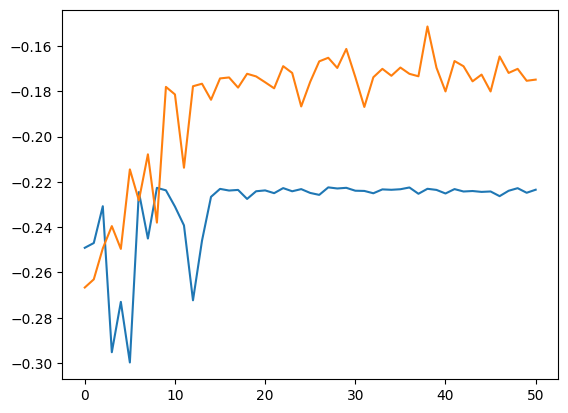

In [53]:
plt.plot(optimizer.scores.values())
plt.plot(optimizer_xgb.scores.values())

In [63]:
list(optimizer.scores.keys())[0]

Configuration(values={
  'bootstrap': True,
  'criterion': 'friedman_mse',
  'max_features': 11,
  'max_leaf_nodes': 560,
  'min_samples_leaf': 18,
  'min_samples_split': 4,
  'min_weight_fraction_leaf': 0.4298044929275989,
  'n_estimators': 41,
})

In [64]:
list(optimizer.scores.keys())[-1]

Configuration(values={
  'bootstrap': True,
  'criterion': 'friedman_mse',
  'max_features': 10,
  'max_leaf_nodes': 574,
  'min_samples_leaf': 7,
  'min_samples_split': 16,
  'min_weight_fraction_leaf': 0.2793606911588493,
  'n_estimators': 48,
})